---
# News Article Title Generation with LLMs

This Jupyter Notebook documents a **Natural Language Processing (NLP)** project focused on **Title Generation**, a sequence-to-sequence task where a news article's content is used to predict its title.

---
**Author Information:**
* **Author:** Radin Khayyam
* **Contact:** radinkhayyam@gmail.com

---
The project aims to systematically compare two powerful **Large Language Models (LLMs)**:
* **Gemma 3 - 4B - IT** (Instruction-Tuned)
* **Llama 3.1 - 8B - IT** (Instruction-Tuned)

---
## Project Steps

The notebook is structured into four main, distinct phases:

1.  **Data Loading & Exploration:** Load a public news article dataset and perform initial analysis of its structure and content statistics (e.g., length distribution of articles and titles).

2.  **Prompt-Based Evaluation (Zero-shot & Few-shot):** Evaluate the LLMs' inherent title generation capabilities by testing different **prompt engineering** strategies (zero-shot and few-shot) and analyzing their immediate impact on output quality.

3.  **Fine-Tuning with LoRA:** Enhance the LLMs' performance on this specific task by applying **Low-Rank Adaptation (LoRA)**, a parameter-efficient fine-tuning technique.

4.  **Inference and Evaluation:** Generate titles for the held-out test set using both the instruction-tuned (IT) and LoRA-fine-tuned models, and rigorously evaluate the results using industry-standard numerical metrics (e.g., ROUGE, BLEU).

---
## Goal

The ultimate goal is to determine the most effective strategy—direct instruction-tuning vs. LoRA fine-tuning—for optimizing these LLMs for the news title generation task and to establish a performance benchmark.

---

## Setup: Dependency Installation and Library Imports

This critical section establishes the project's computational environment. We install all necessary libraries for **Large Language Model (LLM)** handling, specifically focusing on the `unsloth` library for **parameter-efficient fine-tuning (PEFT)**. We install specific versions of `transformers` and `trl` for stability, along with a suite of **NLP evaluation metrics** (`rouge_score`, `bert_score`, `sacrebleu`, `nltk`) and text processing utilities (`hazm`). This ensures a robust and reproducible environment for the entire notebook.

In [2]:
%%capture
import os, re

# Install unsloth and required dependencies based on environment (Colab vs. local)
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Optimized installation for Google Colab with specific dependency versions for faster training
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth

# Install specific versions for general NLP and LLM operations
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

# Install libraries for popular NLP evaluation metrics
!pip install rouge_score
!pip install bert_score
!pip install nltk
!pip install sacrebleu

# Install text processing libraries, using --no-deps for specific control
!pip install hazm --no-deps
!pip install python-crfsuite flashtext

# Remove unnecessary embedding imports from hazm to prevent potential conflicts or excessive memory use
!sed -i '/from hazm.embedding import SentEmbedding/d' /usr/local/lib/python3.12/dist-packages/hazm/__init__.py
!sed -i '/from hazm.embedding import WordEmbedding/d' /usr/local/lib/python3.12/dist-packages/hazm/__init__.py

In [1]:
# Core Data, ML, and Utility Libraries
import pandas as pd
import torch
import numpy as np
import gc # For garbage collection and memory management
from tqdm.auto import tqdm # For smart progress bars
import os
# osgeo_utils is typically for geospatial; removed for clean NLP context
from sklearn.model_selection import train_test_split # For data splitting

# Hugging Face and LLM-Specific Libraries
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForCausalLM,
)
from peft import (
    PeftModel,
    LoraConfig,
    get_peft_model
)
from datasets import Dataset # Hugging Face Dataset object for efficient data handling

# Unsloth and TRL for Efficient Fine-Tuning
from unsloth import FastLanguageModel
from trl import SFTConfig, SFTTrainer # Supervised Fine-Tuning Trainer
from unsloth.chat_templates import train_on_responses_only # Utility for chat template formatting

# Data Visualization and Rich Output
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap # For formatting text output
from rich.console import Console
from rich.markdown import Markdown # For structured console output

# NLP Preprocessing and Evaluation Metrics
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction # BLEU metric calculation
from nltk.translate.meteor_score import meteor_score # METEOR metric calculation
from rouge_score import rouge_scorer # ROUGE metric calculation
from bert_score import score as bert_score_calc # BERTScore calculation
from hazm import Normalizer, word_tokenize # Farsi/Persian text normalization and tokenization
import sacrebleu # Robust standard for BLEU/chrf metrics

# Download NLTK data required for metrics (run silently)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

/tmp/ipython-input-1024299500.py:23: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## Hugging Face Authentication

To enable downloading the proprietary **Gemma 3 - 4B - IT** and **Llama 3.1 - 8B - IT** models, which are gated on the Hugging Face Hub, **authentication is required**. This step uses the `huggingface_hub` library to prompt the user to securely log in using their valid personal access token. This is a prerequisite for subsequent model loading steps.

In [4]:
# If you want to load the models from Hugging Face Hub
# Authentication is required to access gated or proprietary models (e.g., Llama, Gemma)
from huggingface_hub import login
login()

## Data Acquisition and Stratified Split

Following authentication, the raw dataset is loaded from a local file path. The data is then immediately divided into training and testing sets. A **90/10 split** is applied using `train_test_split`, reserving 10% of the data for final inference and unbiased evaluation. Using a fixed `random_state` ensures the split is reproducible across multiple executions. This partitioning is essential to prevent data leakage and provide a robust measure of model generalization.

In [4]:
# Load the dataset from the specified file path (assuming the file is available in the environment)
data = pd.read_excel("/content/Dataset.xlsx")

# Split the dataset into training and testing sets (90% for training, 10% for testing)
# Using a fixed random_state (42) ensures reproducibility of the split
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# Print the dimensions of the resulting datasets for verification
print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

Training set shape: (1044, 3)
Test set shape: (116, 3)


## Step 1: Exploratory Data Analysis (EDA)

This section performs **Exploratory Data Analysis (EDA)** to characterize the statistical properties of the dataset. Specifically, we analyze the **word count distributions** for both the article content and the corresponding titles. Understanding these distributions (average, standard deviation, and visual histograms) is crucial for:

1.  **Tokenization Strategy:** Informing decisions regarding maximum input and output sequence lengths for the LLMs.
2.  **Quality Assurance:** Identifying outliers or potential data entry errors (e.g., extremely short articles or excessively long titles).

We also calculate the **correlation** between content and title length to assess if longer articles tend to have longer titles, followed by a final check for **missing data** and a presentation of **random samples** to ground the numerical analysis in the actual text.

Average Content Word Count: 290.81
Standard Deviation of Content Word Count: 414.27
Average Title Word Count: 14.11
Standard Deviation of Title Word Count: 5.63


,content_length,title_length
count,1160.000000,1160.000000
mean,290.811207,14.106034
std,414.269845,5.626110
min,10.000000,4.000000
25%,125.000000,10.000000
50%,186.500000,13.000000
75%,314.250000,17.000000
max,5985.000000,70.000000


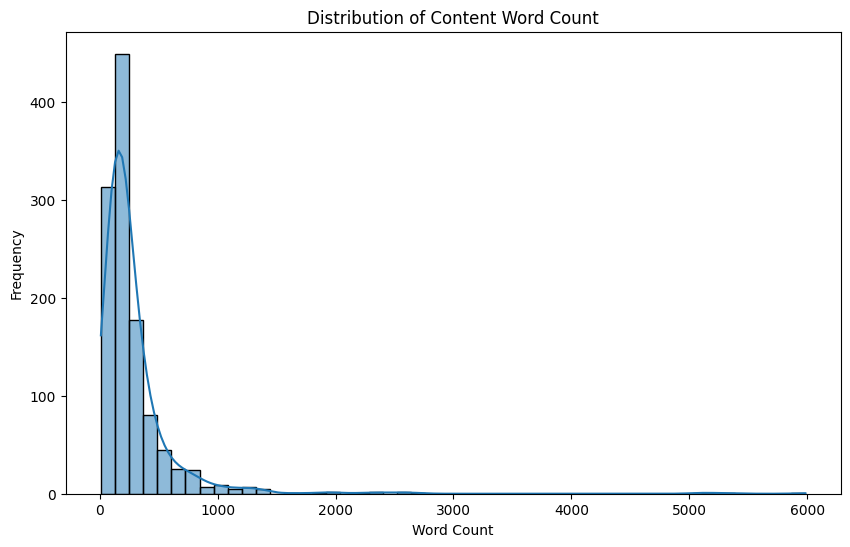

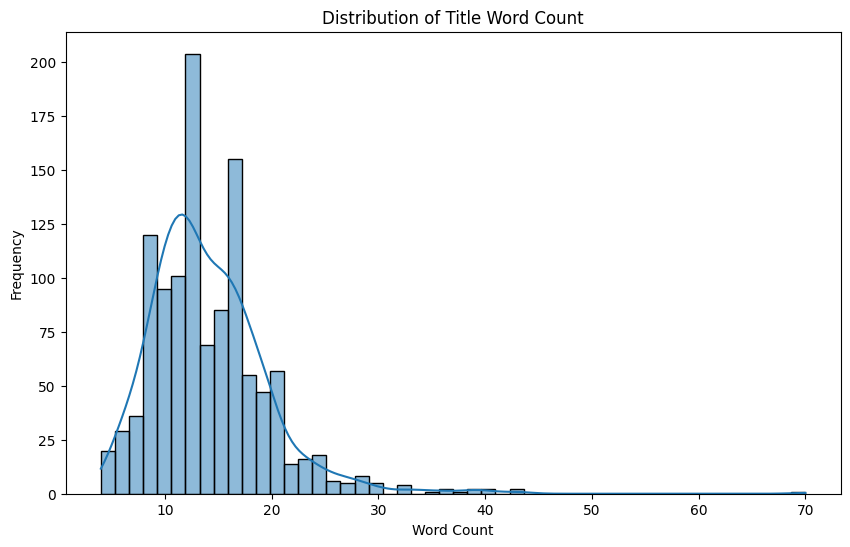

In [ ]:
# Calculate the number of words in the 'content' and 'title' columns using string splitting
data['content_length'] = data['content'].str.split().str.len()
data['title_length'] = data['title'].str.split().str.len()

# Calculate the mean and standard deviation for the newly created length columns
avg_content_length = data['content_length'].mean()
std_content_length = data['content_length'].std()
avg_title_length = data['title_length'].mean()
std_title_length = data['title_length'].std()

# Print key summary statistics
print(f"Average Content Word Count: {avg_content_length:.2f}")
print(f"Standard Deviation of Content Word Count: {std_content_length:.2f}")
print(f"Average Title Word Count: {avg_title_length:.2f}")
print(f"Standard Deviation of Title Word Count: {std_title_length:.2f}")

# Display comprehensive descriptive statistics for the length columns
display(data[['content_length', 'title_length']].describe())

# Visualize the distribution of content length using a histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(data['content_length'], kde=True, bins=50)
plt.title('Distribution of Content Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of title length using a histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(data['title_length'], kde=True, bins=50)
plt.title('Distribution of Title Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Correlation between Content Length and Title Length: 0.23


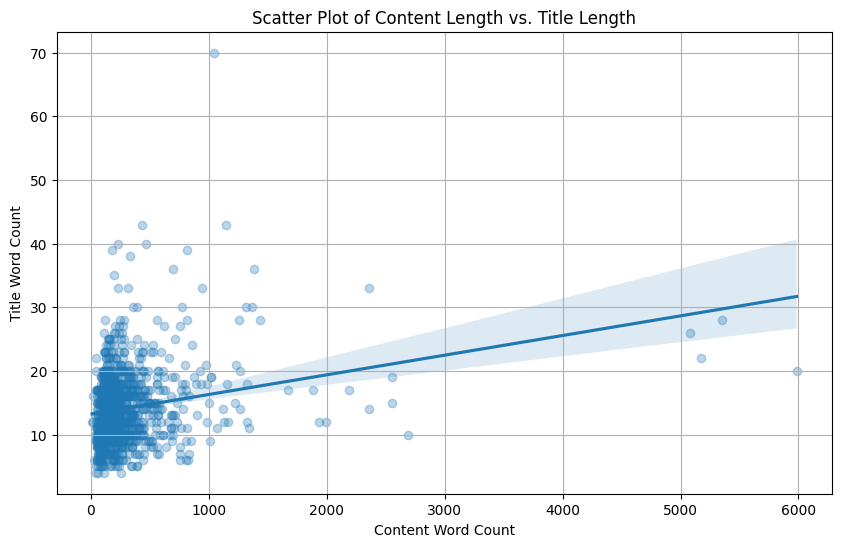

In [ ]:
# Calculate the Pearson correlation coefficient between article content length and title length
correlation_coefficient = data['content_length'].corr(data['title_length'])
print(f"Correlation between Content Length and Title Length: {correlation_coefficient:.2f}")

# Visualize the relationship between content and title length using a regression plot
plt.figure(figsize=(10, 6))
# Use alpha=0.3 to better visualize density of overlapping points
sns.regplot(x='content_length', y='title_length', data=data, scatter_kws={'alpha':0.3})
plt.title('Scatter Plot of Content Length vs. Title Length')
plt.xlabel('Content Word Count')
plt.ylabel('Title Word Count')
plt.grid(True)
plt.show()

In [ ]:
# Final check for any remaining missing values across all columns
print("\nMissing values per column:")
display(data.isnull().sum())


Missing values per column:


,0
Unnamed: 0,0
content,0
title,0
content_length,0
title_length,0


In [ ]:
# Select 5 random samples from the training dataset for manual inspection
random_samples = train_data.sample(5, random_state=42) # Use fixed state for reproducibility

# Iterate through the random samples and print the title and content, wrapped for readability
for index, row in random_samples.iterrows():
  # Wrap the text to a standard width (60 characters) for cleaner display
  wrapped_content = textwrap.fill(row['content'], width=90) # Increased width for better article content display
  wrapped_title = textwrap.fill(row['title'], width=90)
  print('Title:')
  print(wrapped_title + '\n')
  print('Content:')
  print(wrapped_content)
  print("-" * 50)

Title:
قرار بود که با پایان سند چشم انداز ۲۰ ساله، ایران از هر لحاظ
قدرت اول منطقه باشد

Content:
شرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرده‌است که قرار
بود امسال با پایان سند چشم‌انداز ۲۰ ساله، ایران از هر لحاظ
قدرت اول منطقه باشد. نتیجه بررسی بر اساس متن سند چشم‌انداز
۲۰ساله یا سند چشم‌انداز جمهوری اسلامی ایران در افق ۱۴۰۴، که
در تاریخ ۱۳ آبان ۱۳۸۲ به سران قوا ابلاغ شده است، جمهوری
اسلامی ایران باید به جایگاه اول اقتصادی، علمی و فناوری در
سطح منطقه‌ی آسیای جنوب غربی (شامل آسیای میانه، قفقاز،
خاورمیانه و کشورهای همسایه) برسد. همچنین در این سند، به
پیشرفت و توسعه در عرصه‌های متفاوتی مثل امنیت، سلامت، رفاه،
امنیت غذایی، تامین اجتماعی، فرصت‌های برابر و … اشاره شده
است. همچنین در ملاحظه این سند، بیان شده‌است که: در تهیه،
تدوین و تصویب برنامه‌های توسعه و بودجه‌های سالیانه، این نکته
مورد توجه قرار گیرد که شاخص‌های کمی کلان آن‌ها از قبیل نرخ
سرمایه‌گذاری، درآمد سرانه، تولید ناخالص ملی، نرخ اشتغال و
تورم، کاهش فاصله‌ی درآمد میان دهک‌های بالا و پایین جامعه،
رشد فرهنگ و آموزش و پژوهش و توان

## Step 2: Prompt-Based Evaluation - Defining Instruction Templates

This section defines four distinct instruction templates used to benchmark the zero-shot and few-shot capabilities of the instruction-tuned LLMs. These prompts progressively increase in complexity and constraints to assess their impact on output quality in the context of Persian news title generation:

1.  **`simple_prompt`**: A minimal instruction for a direct, unguided baseline evaluation.
2.  **`zero_shot_prompt`**: A detailed, **persona-based instruction** that imposes explicit constraints on the output (language, length, format, focus) without examples.
3.  **`few_shot_prompt`**: Expands on the zero-shot template by incorporating five high-quality example pairs, guiding the model toward the expected output style.
4.  **`refined_prompt`**: This is the most specialized template. It includes **explicit domain-specific guidance** that, for fact-check articles, the generated title **must summarize the original claim (شرح ادعا)**, regardless of the subsequent verification (نتیجه بررسی). This is crucial, as the examples demonstrate that the title should report the claim itself, even if it is incorrect, and must **not** include the verification outcome.

## **Prompts**

In [7]:
# --- 1. Simple, Minimalist Prompt Template (Zero-Shot Baseline) ---
# A concise, direct instruction for title generation with minimal constraints.
simple_prompt = """
Generate a high-quality headline for the following news report, responding only with the Persian title and no other text.

News report:
"""

# --- 2. Detailed, Persona-Based Prompt Template (Zero-Shot) ---
# Establishes an expert persona and formal constraints to maximize zero-shot output quality.
zero_shot_prompt = """You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.

## **Instructions and Constraints:**

* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original news content provided.
* **Length**: The title must be approximately **15 words** long.
* **Format**: The title **MUST** be a **declarative sentence**. It should state a fact or summarize the main point directly. It must **not** be phrased as a question.
* **Focus**: The primary goal is to be **informative and accurate**. The title must be 100% relevant to the provided news content and precisely summarize its core subject or most significant finding.

Analyze the provided news content, identify its most critical information, and then craft a single headline that meets all of the above criteria.

## **Output Format:**

Respond **only** with the generated Persian title. Do not add any commentary, explanations, or introductory text.

News report:
"""

# --- 3. Few-Shot Prompt Template (Examples without explicit domain logic) ---
# Extends the Zero-Shot prompt with five examples to guide the model's output style.
few_shot_prompt = """You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.

## **Instructions and Constraints:**

* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original news content provided.
* **Length**: The title must be approximately **15 words** long.
* **Format**: The title **MUST** be a **declarative sentence**. It should state a fact or summarize the main point directly. It must **not** be phrased as a question.
* **Focus**: The primary goal is to be **informative and accurate**. The title must be 100% relevant to the provided news content and precisely summarize its core subject or most significant finding.

Analyze the provided news content, identify its most critical information, and then craft a single headline that meets all of the above criteria.

## **Examples:**

Here are five examples of correct `Content` to `Title` generation:

---
**Example 1**

**Content:**
شرح ادعا کاربری در ایکس ادعا کرده است که بیش از هزار کارگر
طی شش ماه در حوادث ضمن کار جان خود را از دست داده‌اند. نتیجه
بررسی براساس آمار اختصاصی سازمان پزشکی قانونی : در شش ماهه
نخست سال جاری ۱۰۷۷ نفر در حوادث کار جان خود را از دست دادند.
این رقم در مقایسه با مدت مشابه سال قبل با آمار فوتی ۹۳۱ نفر،
۱۵/۷ درصد افزایش داشته است. آمار اختصاصی سازمان پزشکی قانونی
در سایت باشگاه خبرنگاران جوان براساس سالنامه آماری وزارت کار
در سال ۱۴۰۱ : تعداد متوفیان حوادث ناشی از کار ثبت شده در
مراکز پزشکی قانونی در سال ۱۴۰۱ ، ۱۹۰۰ نفر بوده است. سالنامه
آماری وزارت کار در سال ۱۴۰۱

**Title:**
بیش از هزار کارگر طی شش ماه در حوادث ضمن کار کشته شده‌اند

---
**Example 2**

**Content:**
حسن روحانی در آیین افتتاح طرح‌های ملی وزارت جهاد کشاورزی، در
هشتاد و دومین پویش تدبیر و امید برای جهش تولید گفت: « مردم
خوزستان علی‌رغم اینکه توصیه ما این بود که آنجا برنج‌کاری
نشود، اما سال‌هاست برنج‌کاری هم انجام می‌دهند که خودِ آن هم
مزید بر علت شده و این‌ها همه دست به دست هم داده و مردم عزیز
در سختی قرار گرفتند.» صفحه شبکه منوتو در اینستاگرام به نقل
از حسن روحانی نوشته است: «مردم خوزستان علی‌Rateرغم اینکه توصیه
ما این بود که در آنجا برنج‌کاری نشود، اما سال‌هاست برنج‌کاری
هم انجام می‌ده دهند که خود آن هم مزید بر علت در بحران کم‌آبی
شده است.» به گزارش سایت رسمی پایگاه اطلاع رسانی ریاست جمهوری
به تاریخ ۲۸ تیرماه، حسن روحانی در آیین افتتاح طرح‌های ملی
وزارت جهاد کشاورزی در هشتاد و دومین پویش تدبیر و امید برای
جهش تولید گفت: «مردم خوزستان علی‌رغم اینکه توصیه ما این بود
که آنجا برنج‌کاری نشود؛ اما سال‌هاست برنج‌کاری هم انجام
می‌دهند که خودِ آن هم مزید بر علت شده و این‌ها همه دست به
دست هم داده و مردم عزیز در سختی قرار گرفتند.» سایت رسمی
پایگاه اطلاع رسانی ریاست جمهوری

**Title:**
حسن روحانی گفته‌است: «برنج‌کاری مردم خوزستان از دلایل بحران
کم‌آبی است.»

---
**Example 3**

**Content:**
شرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرده‌است که فقط در
۸ ماه، ۴ هزار و ۵۰۰ پزشک و پرستار از ایران مهاجرت کرده‌اند.
نتیجه بررسی این آمار، براساس گزارش روزنامه ایران از شمار
گواهی‌های صادر شده گود استندینگ (Good standing) صادر شده
توسط سازمان نظام پزشکی است. گواهی گود استندینگ یکی از مدارکی
است که اعضای کادر درمان باید برای مهاجTرت و فعالیت حرفه‌ای در
کشورهای خارجی ارائه دهند؛ این گواهی حسن سابقه افراد را مشخص
می‌کند و یعنی این افراد صلاحیت لازم را برای فعالیت در کشور
مقصد را دارند. بر اساس این گزارش، در 8 ماه ابتدایی امسال،
4500 نفر گواهی گود استندینگ دریافت کرده‌اند، اما صرف دریافت
این گواهی به معنای مهاجTرت قطعی نیست. بنابراین، اگرچه دریافت
گواهی گوداستندینگ برای اقدام در راستای مهاجرت است؛ اما به
این معنا که هر کس این گواهی را دریافت کرده، سپس مهاجرت
نموده، نیست. پس ادعای این کاربر گمراه‌کننده ارزیابی می‌شود.

**Title:**
در 8 ماه ابتدایی سال جاری، 4500 پزشک و پرستار مهاجرت
کرده‌اند

---
**Example 4**

**Content:**
گرفتن حق اشتراک و پخش آگهی قبل از انتشار محتوا توسط
پلتفرم‌های اینترنتی در هیچ جای دنیا مرسوم نیست و به زودی
برای آن دستورالعمل قانونی نوشته و پس از مصوب‌ شدن، به آن‌ها
ابلاغ می‌شود. در حال حاضر، قانونی که پلتفرم‌ها را از این عمل
منع کند وجود ندارد. مصطفی قاسمیان، روزنامه‌نگار سینما و
تلویزیون، در توییتر ادعا کرده است: «با وجودی که ۵ ماه پیش
ساترا صراحتا اعلام کرد پلتفرم‌هایی که هزینه اشتراک می‌گیرند،
حق نمایش آگهی پیش از پخش محتوا ندارند، اما فیلیمو و نماوا
همچنان این عمل غیرقانونی را انجام می‌دهند.» توییت قاسمیان
درباره پخش آگهی فیلیمو و نماوا علی سعد، معاون کاربران و
تنظیم مقررات اجتماعی ساترا (سازمان تنظیم مقررات صوت و تصویر
فراگیر در فضای مجازی) در تماس تلفنی با فکت‌یار گفت : «ما
فروردین ماه اعلام کردیم... در حال حاضر
این دو پلتفرم کار غیر‌قانونی انجام نمی‌دهند چون هنوز قانون
آن مصوب و ابلاغ نشده است.»

**Title:**
با وجود اعلام ساترا مبنی بر اینکه پلتفرم‌هایی که هزینه
اشتراک می‌گیرند، حق نمایش آگهی پیش از پخش محتوا را ندارند،
فیلیمو و نماوا با انتشار آگهی قبل از نمایش محتوا عمل
غیرقانونی انجام می‌دهند.

---
**Example 5**

**Content:**
شرح ادعا عبدالرضا داوری با انتشار فیلمی از مردی که برای
دریافت هزینه اشتراک تلویزیون BBC به خانه یکی از شهروندان این
کشور رفته‌است، گفت: «در حالیکه مردم بریتانیا مجبور هستند
برای شبکه BBC حق اشتراک بپردازند، شبکه BBC چه منافعی در
ایران دارد که برنامه‌های بخش فارسی آن، بصورت رایگان و ۲۴
ساعته برای ملت ایران پخش می‌شود؟». نتیجه بررسی براساس
آیین‌نامه‌ای که در وبسایت دولت بریتانیا برای دریافت مجوز
دیدن تلویزیون وجود دارد ؛ شهروندان برای دیدن برنامه‌های زنده
تلویزیون، به صورت کلی و برای همه شبکه‌ها (اعم از BBC)، باید
۱۶۹.۵پوند پرداخت کنند. دیدن بی بی سی فارسی، به صورت آنلاین
یا با استفاده از آنتن‌های ماهواره، برای مخاطبان رایگان است.
بنابراین، ادعای عبدالرضا داوری در مورد اینکه مردم بریتانیا
باید برای دیدن BBC اشتراک تهیه کنند اما این شبکه به طور
رایگان برای مردم ایران به طور 24 ساعته برنامه‌سازی می‌کند،
درست ارزیابی می‌شود.

**Title:**
مردم بریتانیا باید برای دیدن BBC اشتراک بخرند؛ در حالی که
دیدن BBC فارسی برای مردم ایران رایگان است

---

## **Output Format:**

Respond **only** with the generated Persian title. Do not add any commentary, explanations, or introductory text.

News report:
"""

# --- 4. Highly Refined Prompt Template (With Explicit Domain Logic) ---
refined_prompt = """
You are an expert-level, highly experienced Persian news editor. Your task is to generate a single, high-quality, informative headline (title) based on a given news report.

The content you will receive is a fact-check, which contains two main parts:
1.  A **"شرح ادعا" (Claim Description)**
2.  A **"نتیجه بررسی" (Verification / Result)**

## **Core Logic: Handling Claims vs. Verifications**

Your primary task is to identify the most newsworthy part of the article to summarize as a headline.

* The content you receive is a fact-check. In this format, the **"Claim" (ادعا)** is almost always the main subject and the most newsworthy part.
* **Crucial Instruction:** In many cases, even when the **"Verification" (نتیجه بررسی)** finds that the "Claim" is **incorrect (نادرست)** or **misleading (گمراه‌کننده)**, the claim is *still* the main subject of the article.
* **In these specific cases, your headline MUST be a declarative statement of that incorrect or semi-correct claim.**
* The examples (especially Example 3 and Example 4) clearly demonstrate this rule. In both, the verification finds the claim to be false or misleading, but the correct `Title` is still a statement of the `Claim`. **Do not include the verification outcome (e.g., 'incorrect', 'false') in the final title.**

## **Instructions and Constraints:**

* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original "شرح ادعا".
* **Length**: The title must be approximately **15 words** long.
* **Format**: The title **MUST** be a **declarative sentence**. It must **not** be phrased as a question.

Analyze the provided news content, identify the core claim, and then craft a single headline that meets all of the above criteria based on the Core Logic.

## **Examples:**

Here are five examples showing how the `Content` (which includes a claim and a verification) is used to create a `Title` (which is *only* the claim).

---
**Example 1**

**Content:**
شرح ادعا کاربری در ایکس ادعا کرده است که بیش از هزار کارگر
طی شش ماه در حوادث ضمن کار جان خود را از دست داده‌اند. نتیجه
بررسی براساس آمار اختصاصی سازمان پزشکی قانونی : در شش ماهه
نخست سال جاری ۱۰۷۷ نفر در حوادث کار جان خود را از دست دادند.
این رقم در مقایسه با مدت مشابه سال قبل با آمار فوتی ۹۳۱ نفر،
۱۵/۷ درصد افزایش داشته است. آمار اختصاصی سازمان پزشکی قانونی
در سایت باشگاه خبرنگاران جوان براساس سالنامه آماری وزارت کار
در سال ۱۴۰۱ : تعداد متوفیان حوادث ناشی از کار ثبت شده در
مراکز پزشکی قانونی در سال ۱۴۰۱ ، ۱۹۰۰ نفر بوده است. سالنامه
آماری وزارت کار در سال ۱۴۰۱

**Title:**
بیش از هزار کارگر طی شش ماه در حوادث ضمن کار کشته شده‌اند

---
**Example 2**

**Content:**
حسن روحانی در آیین افتتاح طرح‌های ملی وزارت جهاد کشاورزی، در
هشتاد و دومین پویش تدبیر و امید برای جهش تولید گفت: « مردم
خوزستان علی‌رغم اینکه توصیه ما این بود که آنجا برنج‌کاری
نشود، اما سال‌هاست برنج‌کاری هم انجام می‌دهند که خودِ آن هم
مزید بر علت شده و این‌ها همه دست به دست هم داده و مردم عزیز
در سختی قرار گرفتند.» صفحه شبکه منوتو در اینستاگرام به نقل
از حسن روحانی نوشته است: «مردم خوزستان علی‌Rateرغم اینکه توصیه
ما این بود که در آنجا برنج‌کاری نشود، اما سال‌هاست برنج‌کاری
هم انجام می‌ده دهند که خود آن هم مزید بر علت در بحران کم‌آبی
شده است.» به گزارش سایت رسمی پایگاه اطلاع رسانی ریاست جمهوری
به تاریخ ۲۸ تیرماه، حسن روحانی در آیین افتتاح طرح‌های ملی
وزارت جهاد کشاورزی در هشتاد و دومین پویش تدبیر و امید برای
جهش تولید گفت: «مردم خوزستان علی‌رغم اینکه توصیه ما این بود
که آنجا برنج‌کاری نشود؛ اما سال‌هاست برنج‌کاری هم انجام
می‌دهند که خودِ آن هم مزید بر علت شده و این‌ها همه دست به
دست هم داده و مردم عزیز در سختی قرار گرفتند.» سایت رسمی
پایگاه اطلاع رسانی ریاست جمهوری

**Title:**
حسن روحانی گفته‌است: «برنج‌کاری مردم خوزستان از دلایل بحران
کم‌آبی است.»

---
**Example 3**

**Content:**
شرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرده‌است که فقط در
۸ ماه، ۴ هزار و ۵۰۰ پزشک و پرستار از ایران مهاجرت کرده‌اند.
نتیجه بررسی این آمار، براساس گزارش روزنامه ایران از شمار
گواهی‌های صادر شده گود استندینگ (Good standing) صادر شده
توسط سازمان نظام پزشکی است. گواهی گود استندینگ یکی از مدارکی
است که اعضای کادر درمان باید برای مهاجTرت و فعالیت حرفه‌ای در
کشورهای خارجی ارائه دهند؛ این گواهی حسن سابقه افراد را مشخص
می‌کند و یعنی این افراد صلاحیت لازم را برای فعالیت در کشور
مقصد را دارند. بر اساس این گزارش، در 8 ماه ابتدایی امسال،
4500 نفر گواهی گود استندینگ دریافت کرده‌اند، اما صرف دریافت
این گواهی به معنای مهاجTرت قطعی نیست. بنابراین، اگرچه دریافت
گواهی گوداستندینگ برای اقدام در راستای مهاجرت است؛ اما به
این معنا که هر کس این گواهی را دریافت کرده، سپس مهاجرت
نموده، نیست. پس ادعای این کاربر گمراه‌کننده ارزیابی می‌شود.

**Title:**
در 8 ماه ابتدایی سال جاری، 4500 پزشک و پرستار مهاجرت
کرده‌اند

---
**Example 4**

**Content:**
گرفتن حق اشتراک و پخش آگهی قبل از انتشار محتوا توسط
پلتفرم‌های اینترنتی در هیچ جای دنیا مرسوم نیست و به زودی
برای آن دستورالعمل قانونی نوشته و پس از مصوب‌ شدن، به آن‌ها
ابلاغ می‌شود. در حال حاضر، قانونی که پلتفرم‌ها را از این عمل
منع کند وجود ندارد. مصطفی قاسمیان، روزنامه‌نگار سینما و
تلویزیون، در توییتر ادعا کرده است: «با وجودی که ۵ ماه پیش
ساترا صراحتا اعلام کرد پلتفرم‌هایی که هزینه اشتراک می‌گیرند،
حق نمایش آگهی پیش از پخش محتوا ندارند، اما فیلیمو و نماوا
همچنان این عمل غیرقانونی را انجام می‌دهند.» توییت قاسمیان
درباره پخش آگهی فیلیمو و نماوا علی سعد، معاون کاربران و
تنظیم مقررات اجتماعی ساترا (سازمان تنظیم مقررات صوت و تصویر
فراگیر در فضای مجازی) در تماس تلفنی با فکت‌یار گفت : «ما
فروردین ماه اعلام کردیم... در حال حاضر
این دو پلتفرم کار غیر‌قانونی انجام نمی‌دهند چون هنوز قانون
آن مصوب و ابلاغ نشده است.»

**Title:**
با وجود اعلام ساترا مبنی بر اینکه پلتفرم‌هایی که هزینه
اشتراک می‌گیرند، حق نمایش آگهی پیش از پخش محتوا را ندارند،
فیلیمو و نماوا با انتشار آگهی قبل از نمایش محتوا عمل
غیرقانونی انجام می‌دهند.

---
**Example 5**

**Content:**
شرح ادعا عبدالرضا داوری با انتشار فیلمی از مردی که برای
دریافت هزینه اشتراک تلویزیون BBC به خانه یکی از شهروندان این
کشور رفته‌است، گفت: «در حالیکه مردم بریتانیا مجبور هستند
برای شبکه BBC حق اشتراک بپردازند، شبکه BBC چه منافعی در
ایران دارد که برنامه‌های بخش فارسی آن، بصورت رایگان و ۲۴
ساعته برای ملت ایران پخش می‌شود؟». نتیجه بررسی براساس
آیین‌نامه‌ای که در وبسایت دولت بریتانیا برای دریافت مجوز
دیدن تلویزیون وجود دارد ؛ شهروندان برای دیدن برنامه‌های زنده
تلویزیون، به صورت کلی و برای همه شبکه‌ها (اعم از BBC)، باید
۱۶۹.۵پوند پرداخت کنند. دیدن بی بی سی فارسی، به صورت آنلاین
یا با استفاده از آنتن‌های ماهواره، برای مخاطبان رایگان است.
بنابراین، ادعای عبدالرضا داوری در مورد اینکه مردم بریتانیا
باید برای دیدن BBC اشتراک تهیه کنند اما این شبکه به طور
رایگان برای مردم ایران به طور 24 ساعته برنامه‌سازی می‌کند،
درست ارزیابی می‌شود.

**Title:**
مردم بریتانیا باید برای دیدن BBC اشتراک بخرند؛ در حالی که
دیدن BBC فارسی برای مردم ایران رایگان است

---

## **Output Format:**

Respond **only** with the generated Persian title. Do not add any commentary, explanations, or introductory text.

News report:
"""

## Step 2.1: Qualitative Evaluation with Gemma 3 – 4B – IT

This phase loads the **Gemma 3 – 4B – IT** model and its tokenizer for initial zero-shot and few-shot inference. Since instruction-tuned models often require specific input schemas, a helper function is defined to format the article content and the instruction template according to Gemma's required **`chat_template`**.

We then execute a **qualitative analysis** by applying the four defined prompt strategies (`simple`, `zero-shot`, `few-shot`, `refined`) to a small, fixed subset of the test data (15 samples). The generated titles are compared against the ground truth titles for a preliminary assessment of each prompt's efficacy. The LLM parameters are set to allow for diverse generation (**sampling**) while limiting the output length to focus on the title.

In [ ]:
# Define the Hugging Face ID for the Gemma model
GEMMA_3_4B_IT = "google/gemma-3-4b-it"

# Load the Gemma 3-4B-IT model, using bfloat16 for efficiency and VRAM conservation
# Device mapping 'auto' handles parallel loading across available GPUs
gemma_3_4b_it_model = AutoModelForCausalLM.from_pretrained(
    GEMMA_3_4B_IT,
    dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True,
)

# Load the corresponding tokenizer and set the pad token for batched generation readiness
gemma_3_4b_it_tokenizer = AutoTokenizer.from_pretrained(GEMMA_3_4B_IT)
if gemma_3_4b_it_tokenizer.pad_token is None:
    gemma_3_4b_it_tokenizer.pad_token = gemma_3_4b_it_tokenizer.eos_token

# Create a text generation pipeline for streamlined inference
gemma_3_4b_it_pipe = pipeline(
    task="text-generation",
    model=gemma_3_4b_it_model,
    tokenizer=gemma_3_4b_it_tokenizer,
    dtype=torch.bfloat16
)

# Define generation parameters (kwargs) to be used consistently across all prompt tests
gemma_3_4b_it_pipe_kwargs = {
    "max_new_tokens": 128,  # Limit output length, as titles are relatively short
    "return_full_text": False,  # Return only the generated text, not the prompt
    "do_sample": True,  # Enable sampling for varied, less deterministic output
    "temperature": 0.7,  # Moderate temperature for balanced creativity and coherence
    "top_p": 0.9  # Set high top_p for broad token consideration
}

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def format_for_gemma(system_prompt_text, query_text):
    """
    Formats the instructional system prompt and the article content into the
    Gemma model's required conversation structure (chat_template).

    Args:
        system_prompt_text (str): The specific instruction template (e.g., zero_shot_prompt).
        query_text (str): The news article content to be summarized.

    Returns:
        list: A list of dictionaries conforming to the Hugging Face `messages` format.
    """
    # Note: Gemma models often combine system and user instruction within the 'user' role,
    # but using this structure is robust for instruction tuning models.
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt_text}]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": query_text}]
        }
    ]
    return messages

In [ ]:
# Select a small, reproducible subset of the test data for qualitative inspection
random_samples_for_evaluation = test_data.sample(15, random_state=77)

# Initialize console for formatted, colored output display
console = Console()

# Iterate through the selected samples and generate titles using all four prompt strategies
for index, row in random_samples_for_evaluation.iterrows():
    sample_content = row['content']
    correct_title = row['title']

    # --- Simple Prompt Generation ---
    formatted_simple_prompt = format_for_gemma(simple_prompt, sample_content)
    simple_generated_title = gemma_3_4b_it_pipe(formatted_simple_prompt, **gemma_3_4b_it_pipe_kwargs)[0]["generated_text"]

    # --- Zero-Shot Prompt Generation ---
    formatted_zero_shot_prompt = format_for_gemma(zero_shot_prompt, sample_content)
    zero_shot_generated_title = gemma_3_4b_it_pipe(formatted_zero_shot_prompt, **gemma_3_4b_it_pipe_kwargs)[0]["generated_text"]

    # --- Few-Shot Prompt Generation ---
    formatted_few_shot_prompt = format_for_gemma(few_shot_prompt, sample_content)
    few_shot_generated_title = gemma_3_4b_it_pipe(formatted_few_shot_prompt, **gemma_3_4b_it_pipe_kwargs)[0]["generated_text"]

    # --- Refined Prompt Generation (Includes domain-specific logic) ---
    formatted_refined_prompt = format_for_gemma(refined_prompt, sample_content)
    refined_generated_title = gemma_3_4b_it_pipe(formatted_refined_prompt, **gemma_3_4b_it_pipe_kwargs)[0]["generated_text"]

    # Display results for side-by-side comparison
    console.print(f"[yellow]--- Sample {index} ---[/yellow]")
    console.print(f"[green]Original Content:[/green] {textwrap.fill(sample_content, width=80)}\n")
    console.print(f"[green]Actual Title (Dataset):[/green] {correct_title}\n")
    console.print(f"[deep_sky_blue1]Generated Title (Gemma - Simple Prompt):[/deep_sky_blue1] {simple_generated_title}")
    console.print(f"[deep_sky_blue1]Generated Title (Gemma - Zero-Shot Prompt):[/deep_sky_blue1] {zero_shot_generated_title}")
    console.print(f"[deep_sky_blue1]Generated Title (Gemma - Few-Shot Prompt):[/deep_sky_blue1] {few_shot_generated_title}")
    console.print(f"[deep_sky_blue1]Generated Title (Gemma - Refined Prompt):[/deep_sky_blue1] {refined_generated_title}\n")
    console.print("-" * 100)

--- Sample 938 ---

Original Content: بررسی‌های فکت‌یار نشان می‌دهد که اولاً حکم انفصال از خدمت آقای سید صولت مرتضوی
به شکایت فردی که تقاضای حکم استخدام در دولت را داشت و به دلیل مشکلات قانونی
فرایند استخدام وی طی نشد؛ صادر شده است. ثانیاً استنکاف آقای سید صولت مرتضوی از
اجرای قانون صحت دارد و شکایت شاکی به دلیل نبود استدلال کافی توسط دادگاه تجدید
نظر رد شده است و ثالثاً ایشان به سمت وزارت کار، تعاون و رفاه اجتماعی منصوب
شده‌اند. یکی از کاربران اینستاگرام با انتشار تصویری از حکم انفصال، درخواست تجدید
نظر و حکم برائت جناب آقای سید صولت مرتضوی _معاون اجرایی رئیس جمهور و سرپرست نهاد
ریاست جمهوری_ چنین گفته است: «سید صولت مرتضوی در 11/07/1401 محکوم شده به 5 سال
انفصال از خدمت در تاریخ 19/07/1401 درخواست تجدید نظر داد 26/07/1401 یعنی یک هفته
بعد دادگاه تجدید نظر حکم به برائتش داده! یک روز بعد هم در تاریخ 27/07/1401 وزیر
کار شده. دنبال فساد ساختاری در آسمانها میگردید؟!» متن توئیت کاربر بررسی فکت‌یار
نشان می‌دهد که شعبه ۲۸ تجدید نظر دیوان عدالت اداری طبق دادنامۀ مورخ 11/07/1401
به استناد تبصره 3 ماده 110 و ماده 112 قانون تشکیلات و آئین دادرسی دیوان عدالت
اداری که در تصاویر زیر قابل مشاهده است: تبصره 3 ماده 110 قانون تشکیلات و آئین
دادرسی دیوان عدالت اداری ( مصوب 1392 ) ماده 112 قانون تشکیلات و آئین دادرسی
دیوان عدالت اداری ( مصوب 1392 ) سید صولت مرتضوی را به پنج سال انفصال از خدمات
دولتی محکوم کرده بود. تصویر دادنامه در ذیل قابل ملاحظه است: حکم اولیه شعبه 28
تجدید نظر اما در تاریخ 26 مهرماه 1401حکم دیگری از سوی شعبه ۲۴ تجدیدنظر دیوان
عدالت اداری صادر شد که بر اساس آن، دادگاه رأی به رد شکایت شاکی نسبت به آقای سید
صولت مرتضوی داده است. بر اساس این حکم تجدید نظر، استنکاف آقای سید صولت مرتضوی از
اجرای قانون، رد شده است و حکم قبلی به دلیل نبود استدلال کافی نقض شده است. تصویر
رأی دادگاه به برائت آقای سید صولت مرتضوی در زیر قابل ملاحظه است: حکم جدید شعبه
24 تجدید نظر و رد شکایت از مرتضوی مراجعه تیم فکت‌یار به « سایت پایگاه ملی
اطلا‌ع‌رسانی قوانین و مقررات کشور » و ملاحظۀ خلاصه مذاکرات جلسه علنی روز
چهارشنبه ۲۷ مهر ۱۴۰۱ مجلس شورای اسلامی، مهر تأییدی بر ادعای سوم این کاربر، یعنی
انتصاب جناب آقای سید صولت مرتضوی به سمت وزارت تعاون، کار و رفاه اجتماعی گذاشت.
تصویر زیر مؤید این قضیه است. خلاصه مذاکرات مجلس شورای اسلامی در تاریخ 27/07/1401
اهم مذاکرات این جلسه به شرح زیر است: 1- بررسی برنامه و صلاحیت آقای دکتر سید صولت
مرتضوی برای تصدی وزارت تعاون، کار و رفاه اجتماعی ( آقای دکتر مرتضوی موفق به اخذ
رای اعتماد از مجلس شورای اسلامی گردیدند .) 2- ادامه رسیدگی به گزارش کمیسیون
برنامه و بودجه و محاسبات در مورد لایحه دو فوریتی متناسب سازی حقوق کارکنان دولت و
بازنشستگان کشوری و لشگری 3- اعلام وصول طرح استیضاح وزیر صنعت، معدن و تجارت پس از
قرائت گزارش کمیسیون‌های اجتماعی، آموزش و تحقیقات و بهداشت و درمان و اظهارات
مخالفین، موافقین و بیانات آقای دکتر مرتضوی، وزیر پیشنهادی موفق به اخذ رأی اعتماد
از مجلس شورای اسلامی گردید. بنابراین بر اساس بررسی‌های تیم فکت‌یار، هر سه ادعای
این کاربر مورد تأیید است. منابع: سایت پایگاه ملی اطلا‌ع‌رسانی قوانین و مقررات
کشور، خلاصه مذاکرات جلسه علنی چهارشنبه ۲۷ مهر ۱۴۰۱ مجلس شورای اسلامی . مرکز
پژوهش‌های مجلس شورای اسلامی، تبصره 3 ماده 110 قانون تشکیلات و آیین دادرسی دیوان
عدالت اداری . مرکز پژوهش‌های مجلس شورای اسلامی، ماده 112 قانون تشکیلات و آیین
دادرسی دیوان عدالت اداری .

Actual Title (Dataset): سید صولت مرتضوی 16 روز قبل از وزیر شدن محکوم به انفصال از خدمت شده ولی یک هفته بعد از آن 
تبرئه شد.

Generated Title (Gemma - Simple Prompt): انتصاب وزیر با حکم و پرونده‌های حقوقی مرتضوی

Generated Title (Gemma - Zero-Shot Prompt): سید صولت مرتضوی: حکم انفصال، برائت، و انتصاب جدید در دولت/

Generated Title (Gemma - Few-Shot Prompt): سید صولت مرتضوی پس از حکم انفصال از خدمت، وزیر کار شد.

Generated Title (Gemma - Refined Prompt): سید صولت مرتضوی پس از حکم انفصال از خدمت، وزیر کار شد.

----------------------------------------------------------------------------------------------------

--- Sample 1137 ---

Original Content: جلیل محبی، هیئت‌علمی‌ و‌ معاون‌ مطالعات‌ حکمرانی‌ مرکز پژوهش‌های‌ مجلس‌
شورای‌اسلامی در توییتر گفته است: در کلاب هاوس از آقای همتی درباره الزام به
پایبندی در FATF سوال کرده و آقای همتی در پاسخ گفتند: اگر پایبند نباشیم
نمی‌توانیم مبادله کنیم و قطعا باید اینکار را انجام دهیم. همتی در دقایق ابتدایی
(دقیقه 3) در گفتگوی زنده خود در کلاب‌هاوس ، به سوال جلیل محبی در زمینه FATF پاسخ
داد و اظهار کرد: من یک بار گفتم بیشترین نظر را در این زمینه باید رئیس بانک مرکزی
بدهند. اما من کمترین نظر را داشتم. این ایده که اف ای تی اف را بپذیریم دیگر
تحریم‌ها را نمی‌توانیم دور بزنیم کاملا غلط است. نزدیک ۲۰۰ نهاد و کشور عضو هستند
اما ما و یک کشور دیگر فقط می فهمیم و عضو نیستیم؟ جلیلی در پاسخ به ادعای همتی در
مورد عدم اظهار نظر رئیس بانک مرکزی در این زمینه و تاثیر FATF در مبادلات اقتصادی
فیلمی از صحبت های همتی در رابطه با FATF که از سایت نود اقتصاد منتشر شده را به
اشتراک گذاشته که در آن همتی می‌گوید مسئله FATF و تحریم بر اثر آن تاثیری در تجارت
و اقتصاد ما ندارد. در مجموع، بررسی اظهارات رییس کل بانک مرکزی درباره FATF نشان
می‌دهد که همتی هم از بی‌اثر بودن عدم تصویب FATF سخن گفته و هم از آن ابراز نگرانی
کرده و در مجموع واکنش‌های متفاوتی را نسبت به این موضوع نشان داده است. همتی در 4
دی ماه  سال 98 نیز در جمع خبرنگاران  به تاثیر FATF اشاره می‌کند و می‌گوید «… من
به صلاح سیستم بانکی می‌دانم که در FATF  عضو بشیم و خدایی نکرده در لیست سیاه قرار
نگیریم.» این فیلم آن در صفحه شخصی اینستاگرام او منتشر شده است. به گزارش باشگاه
خبرنگاران جوان در تاریخ 24 بهمن 97، عبدالناصر همتی، رییس وقت بانک مرکزی در حاشیه
جلسه هیئت دولت در جمع خبرنگاران گفته است: پذیرش FATF  به نفع ماست زیرا همه
کشورها آن را پذیرفتند و ما نمی‌خواهیم کشور وارد لیست سیاه شود. اگر این مسئله
تصویب نشود، اثر خوبی نخواهد داشت. اما در فیلم منتشر شده از سایت خبرگزاری مشرق در
تاریخ 29 بهمن 98، عبدالناصر همتی، رئیس وقت بانک مرکزی در پاسخ به باشگاه
خبرنگاران جوان، که پرسیده بود: بعضی ها معتقدند اگر FATF  تصویب نشود، ارتباط
بانکی با کشورهای دوست هم از بین می‌رود و آن‌ها دیگر با ما همکاری نمی‌کنند. آیا
این نظر درست است؟ چنین پاسخ می‌دهد: هرکسی یک نظری دارد، اولا این که چه اتفاقی
خواهد افتاد هنوز معلوم نیست، احتمال دارد بگویند ایران برود در لیست سیاه و احتمال
قوی تر اینکه اینکار را نکنند چون بعید است وارد این مسیر بشوند. من قبلا هم گفتم،
الان مبادلات تجاری ما از مسیرهایی که تحریم ناپذیر است در حال انجام است و این‌ها
در این مقطع روی ما تاثیرگذار نیست. الان بانک‌های کشورهای دنیا حتی کشورهای دوست
بخاطر فشارهای آمریکا با ما همکاری نمی‌کنند ولی چگونه از اول سال تا بحال 35.5
میلیارد دلار تامین ارز کردیم برای واردات کشور؟ خب همین روش را ادامه می‌دهیم.
لازم به ذکر است که این مصاحبه‌ها، گفتگوها و اظهار نظرات همتی به عنوان رییس کل
بانک مرکزی، نشان‌دهنده این است که ایشان در این مورد نظرات خود را اعلام کرده است
و این بخش از پاسخ به جلیلی محبی که مدعی شده است کمترین نظر را در مورد FATF داشت
است، درست نمی‌باشد.

Actual Title (Dataset): همتی درباره مسئله FATF  و تاثیر آن بر مبادلات اقتصادی تناقض‌گویی دارد.

Generated Title (Gemma - Simple Prompt): بحث همتی درباره الزام به عضویت در FATF و تاثیر تحریم‌ها

Generated Title (Gemma - Zero-Shot Prompt): عبدالناصر همتی: عدم تصویب FATF، مانع مبادلات اقتصادی و تجارت کشور خواهد
بود.

Generated Title (Gemma - Few-Shot Prompt): همتی: عدم تصویب FATF، مانع مبادلات اقتصادی ایران می‌شود.

Generated Title (Gemma - Refined Prompt): همتی ادعا کرده‌است که عدم تصویب FATF تاثیر اقتصادی ندارد.

----------------------------------------------------------------------------------------------------

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


--- Sample 771 ---

Original Content: خلاصه نتیجه بررسی مطابق با نظرسنجی Associated Press-NORC : ۱- ۲۶ درصد از
آمریکایی‌­ها موافق نامزدی جو بایدن در انتخابات ۲۰۲۴ هستند. ۲- ۴۷ درصد
دموکرات­‌ها موافق نامزدی جو بایدن در انتخابات هستند. ۳- ۴۷ درصد دموکرات‌­ها
موافق نامزدی جو بایدن در انتخابات هستند. ۴- ۵۶ درصد آمریکایی‌ها بعید است از
بایدن حمایت کنند. ۵- ۶۵ درصد آمریکایی‌­ها از ترامپ حمایت نمی­‌کنند. ۶- آماری از
حمایت یا مخالفت حزب جمهوری­­خواه با نامزدی دونالد ترامپ در انتخابات ۲۰۲۴ وجود
ندارد. شرح ادعا کانال تلگرامی پایش آمریکا اخیراْ مطلبی به نقل از نظرسنجی
خبرگزاری آسوشیتدپرس منتشر کرده که در آن ادعا می­کند: بیشتر آمریکایی­ها مخالف
نامزدی مجدد بایدن و ترامپ در انتخابات ریاست­جمهوری ۲۰۲۴ هستند. ۷۳ درصد
آمریکایی­ها خواهان نامزدی مجدد جو­بایدن در انتخابات نیستند. ۷۰ درصد آمریکایی­ها
مخالف کاندیداتوری مجدد ترامپ هستند. ۵۲ درصد از دموکرات­ها خواهان نامزدی مجدد
جوبایدن نیستند. ۴۵ درصد جمهوری­خواهان مخالف کاندیداتوری مجدد ترامپ هستند. تصویر
ادعای کانال تلگرامی پایش آمریکا درباره کاندیداتوری دونالد ترامپ و جوبایدن در
انتخابات ۲۰۲۴

Actual Title (Dataset): اکثر آمریکایی‌ها مخالف نامزدی بایدن و ترامپ در انتخابات ریاست­ جمهوری ۲۰۲۴ هستند

Generated Title (Gemma - Simple Prompt): نتایج نظرسنجی: حمایت از بایدن و ترامپ در انتخابات ۲۰۲۴ کاهش یافته

Generated Title (Gemma - Zero-Shot Prompt): اکثریت آمریکایی‌ها در نظرسنجی، نامزدی مجدد بایدن و ترامپ در انتخابات 
۲۰۲۴ را نگران‌کننده می‌دانند.

Generated Title (Gemma - Few-Shot Prompt): اکثریت آمریکایی‌ها مخالف نامزدی مجدد بایدن و ترامپ هستند

Generated Title (Gemma - Refined Prompt): اکثریت آمریکایی‌ها مخالف نامزدی مجدد بایدن و ترامپ هستند

----------------------------------------------------------------------------------------------------

--- Sample 1147 ---

Original Content: یک کاربر توییتر نوشته که رحیم مشاعی و حمید بقایی هر دو آزاد هستند و یکی در شمال
کشور و در تنهایی مشغول زندگی است و دیگری دچار بیماری عصبی شده است. به گزارش
پایگاه خبری دولت بهار در تاریخ 5 خرداد 1400، محمود احمدی‌نژاد بعد از اطلاع از
عدم احراز صلاحیتش توسط شورای نگهبان، با انتشار بیانیه تصویری ضمن اعلام اعتراض
خود نسبت به این رای، در مورد دو همراه همیشگی خود، رحیم مشایی و حمید بقایی گفت که
«آقای مشایی را آنقدر تحت فشار قرار دادند که امروز در نقطه نامعلومی در شمال کشور
خود را از جامعه کنار کشیده و به تنهایی زندگی می کند.» و در مورد آقای حمید بقایی
نیز گفت: «بلایی به  سرش(بقایی) می آورند که روزانه دهها قرص اعصاب می خورد و نمی
تواند تعادلش را در راه رفتن حفظ کند و از انجام امور شخصی و خانوادگی خود ناتوان
است.»

Actual Title (Dataset): رحیم مشایی در شمال کشور و دور از مردم زندگی می‌کند و حمید بقایی به بیماری عصبی دچار شده است.

Generated Title (Gemma - Simple Prompt): آزادی مشایی و بقایی: اعتراف احمدی‌نژاد به فشار و مشکلات آن‌ها

Generated Title (Gemma - Zero-Shot Prompt): رحیم مشایی و حمید بقایی در انزوا و بیماری، پس از انتقادات احمدی‌نژاد.

Generated Title (Gemma - Few-Shot Prompt): رحیم مشایی و حمید بقایی به تنهایی و با مشکلات جسمی زندگی می‌کنند

Generated Title (Gemma - Refined Prompt): رحیم مشایی و حمید بقایی به تنهایی و با مشکلات در شمال کشور زندگی می‌کنند

----------------------------------------------------------------------------------------------------

--- Sample 727 ---

Original Content: خلاصه بررسی طبق اطلاعات مقاله منتشرشده در پژوهشگاه علوم انتظامی و مطالعات
اجتماعی و بررسی کمیسیون توسعه پایدار اتاق بازرگانی ایران: رودخانه ارس از طریق
رودخانه‌هاي الحاقي در کشور ارمنستان و آذربایجان با پساب‌هاي صنعتي، معدني و
رادیواكتيو، به طرز نگران‌کننده‌ای آلوده شده است. آلودگی رادیواکتیو در نتیجه
فعالیت‌های نیروگاه اتمی متسامور کشور ارمنستان به وجود آمده است. این نوع آلودگي
منجر به آلودگي آب آشاميدني و بخش كشاورزي مناطق اطراف این رودخانه مي‌شود و در
آینده می‌تواند دسترسی به منابع آبی ارس را محدودتر کند. همچنین بخش بزرگي از جامعه
انساني و زیستي كشور با خطر بيماري‌ها و از بین رفتن امنیت انسانی و غذایی مواجه
خواهند شد. درنتیجه ادعای فوق درست است. شرح ادعا کاربری در توییتر مدعی شده که
رودخانه ارس به ویژه در محدوده سد «خدا آفرین»، به مواد رادیو اکتیو آلوده است؛ این
درحالی است که آب مخزن این سد برای مصرف عمومی استفاده می‌شود. لینک توییت مرتبط با
آلودگی رود ارس تصاویر مربوط به حوضه آبریز رود ارس و مناطق درگیر آلودگی لینک
مقاله مرتبط با مناطق درگیر آلودگی رود ارس (ص ۱۳۶) لینک مقاله مرتبط با حوضه آبریز
رود ارس (ص ۱۳۹)

Actual Title (Dataset): آب رودخانه‌ ارس به مواد رادیو اکتیو آلوده است

Generated Title (Gemma - Simple Prompt): آلودگی رادیواکتیو رود ارس: خطر جدی برای سلامت و امنیت غذایی

Generated Title (Gemma - Zero-Shot Prompt): رودخانه ارس به دلیل آلودگی صنعتی و رادیواکتیو، سلامت مردم و کشاورزی را 
تهدید می‌کند.

Generated Title (Gemma - Few-Shot Prompt): رود ارس به دلیل آلودگی صنعتی و رادیواکتیو در خطر است.

Generated Title (Gemma - Refined Prompt): رود ارس به ویژه در سد خدا آفرین، به مواد رادیو اکتیو آلوده است.

----------------------------------------------------------------------------------------------------

--- Sample 553 ---

Original Content: شرح ادعا کاربری در ایکس ادعا کرده است که یک مسافر مصری در پرواز پاریس روی یک تکه
کاغذ برای خودش می نویسد «خدایا دوستت دارم»، مهماندار می‌بیند و به خلبان اطلاع
می‌دهد و وی را دستگیر می‌کنند. نتیجه بررسی این مسافر پس از اعلام اینکه حال
مساعدی ندارد، روی فرم پزشکی مصرف دارو این جمله را نوشته و به این دلیل که یک
نوشته شخصی نبوده؛ ادعای کاربر نیمه‌درست است. طبق اطلاعات France 24 و Business
insider: هواپیمایی که از پاریس به قاهره می‌رفت، پس از آن که مسافری روی برگه
پزشکی نوشت «من خدا را دوست دارم» در ایتالیا فرود اضطراری داشت . خدمه پس از اینکه
مسافر در فرم پزشکی نوشت “I love allah” به او مشکوک شدند. او در نهایت آزاد شد و
هیچ اقدام قانونی علیه وی صورت نگرفت. به گفته مقامات ایتالیایی، این مرد ۲۹ساله،
در پرواز دچار بدحالی شده و مجبور شد فرمی را امضا کند که در آن قید شده بود با
مسئولیت خود دارو مصرف می‌کند و در این فرم، عبارت فوق را نوشت. یکی از شاهدان عینی
به فرانس 24 گفت که به نظر نمی‌رسد مسافر مزاحمتی در طول پرواز ایجاد کند.

Actual Title (Dataset): مسافر مصری که در پرواز پاریس برای خودش نوشت الله را دوست دارم، دستگیر شد

Generated Title (Gemma - Simple Prompt): دستگیری مسافر مصری به دلیل نوشته در فرم پزشکی

Generated Title (Gemma - Zero-Shot Prompt): مصری در پرواز پاریس-قاهره پس از نوشتن عبارت «خدایا دوستت دارم» در فرم 
پزشکی، دچار فرود اضطراری در ایتالیا شد.

Generated Title (Gemma - Few-Shot Prompt): مسافر مصری به دلیل نوشتن جمله «خدایا دوستت دارم» دستگیر شد.

Generated Title (Gemma - Refined Prompt): مسافر مصری به دلیل نوشتن "خدایا دوستت دارم" در فرم پزشکی دستگیر شد

----------------------------------------------------------------------------------------------------

--- Sample 884 ---

Original Content: در «تبصره ۲۰، بند د» لایحه بودجه ۱۴۰۲ که دی ماه ۱۴۰۱ به مجلس ارائه شد، آمده است:
«سنوات خدمت مورد قبول برای بازنشستگی تمام مستخدمین مرد و زن دارای حداقل مدرک
کارشناسی معتبر در مشاغل اختصاصی در تمام صندوقهای بازنشستگی اعم از لشکری و کشوری
که در سال ۱۴۰۲ بازنشسته می‌شوند, در صورت اعلام نیاز دستگاه و رضایت مستخدم بدون
رعایت شرط سنی به مدت دوسال افزایش می‌یابد.» شرح ادعا: چندی پیش کاربری تويیت زیر
را منتشر کرد: ادعای کاربر طبق « تبصره ۲۰، بند د » لایحه بودجه ۱۴۰۲، افزایش دوسال
سنوات خدمت برای کسانی است که اولا دارای حداقل مدرک کارشناسی باشند و در سال۱۴۰۲
بازنشسته شوند، ثانیا دستگاه کارفرما به حضورآن نیرو نیاز داشته باشد، ثالثا مستخدم
رضایت داشته باشد که به کار ادامه دهد. تصویر بند د تبصره ۲۰ لایحه بودجه ۱۴۰۲ پس
این افزایش سنوات به‌ طور عام و برای همه مستخدمین، اعمال نمی‌شود. این بند در خصوص
مواردی است که مستخدم و کارفرما رضایت دوطرفه داشته باشند. بنابراین ادعای فوق
نیمه‌درست است.

Actual Title (Dataset): سنوات بازنشستگی دوسال افزایش یافت

Generated Title (Gemma - Simple Prompt): افزایش سنوات خدمت بازنشستگی: شرایط جدید در لایحه بودجه ۱۴۰۲

Generated Title (Gemma - Zero-Shot Prompt): افزایش دوسال سنوات خدمت بازنشستگان متخصص در صورت نیاز دستگاه و رضایت 
آن‌ها در لایحه بودجه ۱۴۰۲ مصوب شد.

Generated Title (Gemma - Few-Shot Prompt): افزایش دوسال سنوات خدمت برای بازنشستگان در صورت رضایت
دو طرفه، بنابر تبصره ۲۰ لایحه بودجه ۱۴۰۲، اعمال می‌شود.

Generated Title (Gemma - Refined Prompt): افزایش دوسال سنوات خدمت تنها برای کارکنان مورد نیاز و با
رضایت طرفین، طبق تبصره ۲۰ لایحه بودجه ۱۴۰۲

----------------------------------------------------------------------------------------------------

--- Sample 581 ---

Original Content: شرح ادعا صفحه جهان باستان با انتشار ویدیویی، مدعی شده که مزار لطفعلی‌خان زند در
«امامزاده زید» بازار تهران تبدیل به انبار فرش شده است. نتیجه بررسی در گفتگوی
فکت‌یار با تولیت امامزاده زید مشخص شد: • ماجرای قرار گرفتن تعدادی فرش در محوطه
اطراف مزار مربوط به سال‌های گذشته بوده و در حال حاضر محوطه در حال مرمت است. • در
دو سال اخیر محوطه مزار به دلیل مرمت توسط سازمان میراث فرهنگی، بسته شده و ورود
مردم به آن ممکن نیست. • دلیل انبارشدن فرش‌ها در محوطه مزار، نبودن فضایی برای
انبار بوده و مسئولان بعدا فرش‌ها را از این محوطه خارج کرده اند. • به گفته
مسئولان امامزاده زید در گفتگو با فکت‌یار، روند مرمت بنا به پایان رسیده، اما به
دلیل اینکه هنوز درب ورودی آن تعویض نشده، کماکان ورود به محوطه مزار وجود ندارد.
باتوجه به اینکه انبار شدن فرش در این محوطه مربوط به گذشته بوده و سازمان میراث
فرهنگی در حال مرمت بنا است، این ادعا نیمه نادرست است. وضعیت مزار لطفعلی‌خان زند
• طبق گزارش ایسنا در سال ۱۳۹۴، پیش‌تر سنگ مزار لطفعلی‌خان آسیب دیده و دو قطعه
کاشی سرامیکی روی آن نصب شده بود و حالا این سنگ نیز مورد مرمت قرار گرفته است.

Actual Title (Dataset): مقبره لطفعلی خان‌ زند به انبار فرش تبدیل شده است

Generated Title (Gemma - Simple Prompt): تغییر کاربری مزار زند در بازار تهران: ادعاها در مقابل واقعیت

Generated Title (Gemma - Zero-Shot Prompt): ادعای انبار فرش در مزار لطفعلی‌خان زند، با مرمت و بازسازی بنای تاریخی 
نادرست است.

Generated Title (Gemma - Few-Shot Prompt): ادعای صفحه جهان باستان درباره انبار فرش در مزار لطفعلی‌خان زند نادرست 
است.

Generated Title (Gemma - Refined Prompt): مزار لطفعلی‌خان زند در بازار تهران، انبار فرش شده است.

----------------------------------------------------------------------------------------------------

--- Sample 862 ---

Original Content: چندی پیش یکی از نمایندگان سابق مجلس در تویییتی ادعا کرد که یکی از وزیران دولت
روحانی در رابطه با پرونده مهدی اکبری بازداشت شده است. قدوسی در توییت خود از کسی
نام نبرده است اما عده‌ای در فضای مجازی اعلام کرده‌اند که وزیر دستگیر شده آذری
جهرمی است. توییت ادعای قدوسی طبق صحبت‌های امروز (۱۱ بهمن ۱۴۰۱) سخنگوی قوه
قضاییه، این ادعا نادرست است و تا کنون هیچ یک از وزرای دولت سابق در ارتباط با این
پرونده دستگیر نشده‌اند. تصویر صحبت سخن‌گوی قوه‌قضاییه در خصوص بازداشت یکی از
وزرای روحانی منبع: www.mizan.news همچنین آذری جهرمی نیز در کانال تلگرام خود به
این ادعا واکنش نشان داد. پست کانال تلگرامی آذری جهرمی

Actual Title (Dataset): یکی از وزرای دولت روحانی در رابطه با پرونده مهدی اکبری دستگیر شده است

Generated Title (Gemma - Simple Prompt): ادعای بازداشت وزیر روحانی: قوه قضاییه صحت آن را رد کرد

Generated Title (Gemma - Zero-Shot Prompt): ادعای بازداشت وزیر در پرونده مهدی اکبری توسط نماینده سابق مجلس، توسط 
قوه قضاییه رد شد.

Generated Title (Gemma - Few-Shot Prompt): ادعای قدوسی درباره بازداشت وزیر روحانی نادرست است.

Generated Title (Gemma - Refined Prompt): نماینده سابق مجلس ادعا کرد که یکی از وزرای روحانی بازداشت شده است.

----------------------------------------------------------------------------------------------------

--- Sample 881 ---

Original Content: خلاصه گزارش در تماس تلفنی فکت‌یار با خانم دکتر مینو محرز، ایشان فرموند که: ١-
ایران امکان خرید واکسن‌های از نوع واکسن کوویدـ19 از نوع (mRNA) را داشته است، اما
تصمیمی برای خرید نداشته است. ٢- توان تولید واکسن دوظرفیته در کشور وجود دارد، اما
به‌دلیل تغییرات مستمر ویروس و پیدایش سویه‌های جدید، تولید واکسن دوظرفیتی صرفه
اقتصادی ندارد. همچنین خانم دکتر محرز اخیرا در یک برنامه تلویزیونی فرمودند که
“واکسن برای جلوگیری از ابتلا نیست و فقط یک مقدار ایمنی بدن را بالا می‌برد … از
اول هم هیچ واکسنی برای این [جلوگیری از ابتلا] نبود”. شرح گزارش در روزهای اخیر
شاهد شیوع مجدد کرونا و افزایش تعداد مبتلایان و فوتی ها در جهان هستیم. در همین
راستا، کاربری در توییتر ادعا کرد: «مردم ایران هیچ‌وقت به واکسن کوویدـ19 از نوع
(mRNA) دسترسی نداشتند. الان هم به واکسن دو ظرفیتی شامل (BA.4/BA5) دسترسی ندارند»
(تصویر زیر). توییت کاربر مبنی بر عدم دسترسی مردم ایران به واکسن کووید-۱۹ از نوع
mRNA (واکسن ارجح برای دز بوستر) ویروس کرونا در چند سال گذشته به مهمترین چالش در
تمامی کشور ها تبدیل شده است. از زمان ظهور این بیماری تا 17دی 1401 طبق آمار
سازمان بهداشت جهانی (who) حدود 657 میلیون مورد جدید ابتلا به کرونا گزارش شده است
و  بیش از 13 میلیارد دوز واکسن نیز تزریق شده است (تصویر زیر). آمار واکسن و مرگ
میر کرونا تا تاریخ 17 دی 1401 طبق آمار سازمان بهداشت جهانی (who)
https://covid19.who.int طبق آمار سازمان بهداشت جهانی (who)، ایران نیز تا ابتدای
سال 2023، 144,696 فوتی و 154,773,070 دوز واکسن تزریق کرده است (تصویر زیر). آمار
واکسن و مرگ میر کرونای ایران تا تاریخ 17 دی 1401 طبق آمار سازمان بهداشت جهانی
(who) منبع : www.covid19.who.int واکسن mRNA واکسن RNA یا واکسن mRNA،  گونه‌ای
واکسن است که از نسخه یک ماده شیمیایی طبیعی به نام آران‌ای پیام‌رسان (mRNA) برای
ایجاد پاسخ ایمنی استفاده می‌کند. در میان روش‌های درمانی RNA، واکسن‌های mRNA،
به‌عنوان واکسن‌هایی برای کووید ۱۹، به میزان چشمگیری مورد استقبال قرار گرفته‌ شد.
واکسن کووید-۱۹ مدرنا (mRNA) و واکسن کووید-۱۹ فایزر-بیوان‌تک (BN2)‏ دو واکسن از
نوع (mRNA) است که FDA  آن‌ها را تایید کردند (تصویر زیر). تعریف واکسن mRNA   و
واکسن فایزر و مدرنا از نوع واکسن mRNA در ویکی‌پدیا منبع: wikipedia.org تعریف
واکسن mRNA   و واکسن فایزر و مدرنا از نوع واکسن mRNA در ویکی‌پدیا منبع:
wikipedia.org تعریف واکسن های دو ظرفیتی کووید-19 ویروسی که باعث COVID-19 می شود
در طول زمان تغییر می کند. با دریافت دوز تقویت کننده دو ظرفیتی واکسن کووید-۱۹،
بدن در برابر کووید-۱۹ محافظت می‌شود. واکسن‌های دو ظرفیتی COVID-19 شامل یک جزء از
سویه ویروس اصلی برای ایجاد محافظت گسترده در برابر COVID-19 و یک جزء از نوع
(omicron) برای ارائه محافظت بهتر در برابر COVID-19 ناشی از نوع omicron است. این
همان تعریف واکسن‌های دو ظرفیتی کووید-۱۹ است که حاوی این دو جزء هستند. واکسن دو
ظرفیتی کووید-19 به عنوان دوز تقویت کننده واکسن کووید-19 نیز گفته می‌شود (تصویر
زیر). تعریف واکسن دوظرفیتی در FDA منبع: www.fda.gov. واکسن های دو ظرفیتی
کووید-19 تایید شده FDA به عنوان دوز تقویت کننده FDA  فرمول‌های دو ظرفیتی
واکسن‌های کووید-19 مدرنا (Moderna) و فایزر-بیون‌تک (Pfizer-BioNTech) را برای
استفاده به‌عنوان یک دوز تقویت‌کننده مجاز کرده است (تصویر زیر). وزارت بهداشت
انگلیس نیز واکسن دو ظرفیتی و اولین واکسن تقویت‌کننده کووید-۱۹را که اثر بخشی خوبی
به (BA.5 و BA.4) Omicron دارد نیز تایید کرده است (تصویر زیر). واکسن های دو
ظرفیتی کووید-19تایید شده FDA منبع: www.fda.gov واکسن مدرنا اثربخشی به (BA.4 و
BA.5) Omicron و مورد تایید وزارت بهداشت انگلیس منبع: www.gov.uk اثربخشی
واکسن‌های کووید-19 در تازه‌ترین پژوهش در ژورنال (Biomedical Science) آمده است که
واکسن‌های کوید-۱۹ در جلوگیری از بستری شدن و شدت بیماری و مرگ موثر بوده‌اند.
واکسن‌های مدرنا (Moderna) و فایزر(Pfizer) به ترتیب ۹۳٪ و ۹۱٪ اثربخشی در جلوگیری
از بستری شدن و مرگ دارند. در این پژوهش نیز برای واکسن‌ آسترازنکا (AstraZeneca)
و  سینوفارم (Sinopharm) به ترتیب ۷۴٪ و ۷۸٪ اثر بخشی ثبت شده است ( تصویر زیر).
اثربخشی واکسن‌های مختلف کرونا در ژورنال (Biomedical Science) منبع:
jbiomedsci.biomedcentral.com با تماس مستقیم فکت‌یار با دکتر مینو محرز، عضو کمیته
علمی ستاد ملی مقابله با کرونا و مسئول ارزیابی علمی واکسن کرونای تولید ایران در
دوره‌ی کرونا، تایید شد که ایران امکان خرید واکسن‌های از نوع واکسن کوویدـ19 از
نوع (mRNA) را دا

Actual Title (Dataset): مردم ایران هیچ‌وقت به واکسن کوویدـ19 از نوع (mRNA) دسترسی نداشتند. در حال حاضر نیز به واکسن
دوظرفیتی (omicron) دسترسی ندارند.

Generated Title (Gemma - Simple Prompt): واکسن کرونا: چالش دسترسی و دیدگاه محرز

Generated Title (Gemma - Zero-Shot Prompt): ایران امکان خرید واکسن‌های mRNA را داشت، اما تولید واکسن دوظرفیتی به‌دلیل
تغییرات ویروس، صرفه اقتصادی ندارد.

Generated Title (Gemma - Few-Shot Prompt): ایران امکان خرید واکسن mRNA را داشته، اما تولید واکسن دوظرفیتی صرفه 
اقتصادی ندارد.

Generated Title (Gemma - Refined Prompt): مردم ایران به واکسن mRNA کووید-۱۹ دسترسی نداشتند.

----------------------------------------------------------------------------------------------------

--- Sample 992 ---

Original Content: توییتر |  کاربر | 1 شهریور 1400 نتیجه بررسی | نیمه نادرست: گزاره مورد بررسی
دارای عناصری از واقعیت است اما فکت‌های مهمی را نادیده گرفته است که می‌تواند منجر
به گمراهی خواننده شود. فیلم نمایش خانگی زخم کاری، مجوز ساخت را از وزارت ارشاد
دریافت کرده و بر مبنای همان فیلم ساخته شده است ؛ ولی پروانه نمایش که مربوط به
اصلاحات و ممیزی‌ها است را از ساترا دریافت کرده است. یک کاربر در توییتر با انتشار
تصویر یک خبر از خبرگزاری مشرق گفته است: «توجه کنید سریال زخم کاری، اولین سریال
نمایش خانگی است که از وزارت ارشاد مجوز نگرفته و فقط از ساترا که زیر نظر صدا و
سیما است مجوز گرفته!!!» تصویر توییت منتشر شده که به خبر خبرگزاری مشرق استناد
کرده است خبرگزاری مشرق در تاریخ 9 تیر نوشت: «مصطفی قاسمیان، روزنامه‌نگار سینمایی
در توییتر خود نوشت: سریال زخم‌کاری اولین سریال خانگی است که بی‌مجوز سازمان
سینمایی (ارشاد) منتشر شده و فقط از ساترا (صداوسیما) مجوز دارد.» توییت مصطفی
قاسمیان درباره زخم کاری و عدم دریافت مجوز از وزارت ارشاد علی سعد، معاون کاربران
و تنظیم مقررات اجتماعی ساترا (سازمان تنظیم مقررات صوت و تصویر فراگیر در فضای
مجازی)، در تماس تلفنی با فکت‌یار گفت : «فیلم زخم کاری مجوز ساخت را از وزارت
ارشاد گرفته و بر اساس همان مجوز تولید شده است ولی مجوز نمایش که مربوط به ممیزی و
اصلاحات است را از ساترا دریافت کرده که به آن پروانه نمایش می‌گویند.»

Actual Title (Dataset): سریال &#8220;زخم کاری&#8221; از وزارت ارشاد مجوز نگرفته و فقط مجوز ساترا را دریافت کرده 
است.

Generated Title (Gemma - Simple Prompt): نیمه‌درست: ادعای مجوز بی‌کفایتی سریال "زخم کاری" صحت ندارد

Generated Title (Gemma - Zero-Shot Prompt): فیلم «زخم کاری» مجوز ساخت از ارشاد دارد، اما پروانه نمایش از ساترا 
دریافت کرده است.

Generated Title (Gemma - Few-Shot Prompt): سریال زخم کاری مجوز ساخت از ارشاد، ولی پروانه نمایش از ساترا دارد.

Generated Title (Gemma - Refined Prompt): سریال زخم کاری مجوز ساخت از ارشاد، ولی نه نمایش از ساترا دارد

----------------------------------------------------------------------------------------------------

--- Sample 527 ---

Original Content: شرح ادعا سیامک قاسمی، کارشناس اقتصادی، در ایکس ادعا کرده است که علی‌رغم نزدیک به
یک سال تثبیت دلار ۵۰ هزار تومانی، تورم همچنان ۴۰درصد است. علاوه‌براین، در ماه
گذشته تورم سه درصد افزایش یافت. خلاصه نتیجه بررسی بنابراین، با تورم ۴۴ درصدی،
قیمت دلار تقریبا از ابتدای سال با نرخ ۵۰ هزار تومان ثابت مانده و ادعای کاربر
درست است. نتیجه بررسی براساس گزارش مرکز آمار در آذرماه ۱۴۰۲: شاخص قیمت
مصرف‌کننده (تورم) نسبت به ماه قبل ٢.٩ درصد افزایش داشت. این مقدار نسبت به ماه
مشابه سال قبل ۴۰.۲ درصد افزایش داشته است. تورم در دوازده ماهه منتهی به آذر، نسبت
به دوره مشابه سال قبل، ۴۴.۴ درصد روند صعودی داشت. تورم ماهانه و نقطه به نقطه در
ده سال اخیر براساس اطلاعات شبکه اطلاع‌رسانی طلا، سکه و ارز: در ۱۲ دی ۱۴۰۲، قیمت
دلار ۵۰ هزار و ۵۰۵ تومان است. در ۷ فروردین ۱۴۰۲ نیز دلار با قیمت ۵۱ هزار و ۶۱۰
تومان معامله شد. نمودار تثبیت نرخ ارز از هفتم فروردین سال ۱۴۰۲

Actual Title (Dataset): علی‌رغم تثبیت دلار ۵۰ هزار تومانی، تورم زیر ۴۰ درصد نیامده است

Generated Title (Gemma - Simple Prompt): تورم ۴۴ درصدی با دلار ۵۰ هزار تومانی

Generated Title (Gemma - Zero-Shot Prompt): تورم ۴۴ درصدی همچنان با نرخ ۵۰ هزار تومانی دلار، با افزایش قیمت‌ها در 
سال ۱۴۰۲.

Generated Title (Gemma - Few-Shot Prompt): علی‌رغم تثبیت دلار ۵۰ هزار تومانی، تورم همچنان ۴۴ درصد است.

Generated Title (Gemma - Refined Prompt): علی‌رغم تثبیت دلار ۵۰ هزار تومانی، تورم همچنان ۴۰ درصد است.

----------------------------------------------------------------------------------------------------

--- Sample 845 ---

Original Content: کاربری در توییتر ادعا کرده بود که  خیلی از ایرانی‌ها برای پناهندگی آلمان و
دریافت اقامت، دین‌شان را عوض کردند. توییت کاربر طبق قانون مربوط به پناهندگی که
سال ۱۹۵۳ در ژنو تصویب شد، پناهنده کسی است که به دلیل ترس از آزار و اذیت به دلایل
نژادی، مذهبی، ملیت، عضویت در یک گروه اجتماعی خاص یا عقیده سیاسی نمی‌خواهد به
کشورش برگردد. 1تعریف پناهنده در قانون حمایت از پناهندگان، صفحه ۳
منبع:https://www.unhcr.org/3b66c2aa10 از راه‌های زیادی می‌توان در یک کشور
پناهنده شد و یکی از انواع پناهندگی، پناهندگی مذهبی است. اما پس از پناهنده شدن
هیچ قانونی وجود ندارد که پناهندگان را ملزم کند که مسیحی شوند. طبق قانون
کنوانسیون ژنو، افراد آزاد هستند هر دینی داشته باشند و اگر فردی به علت عقاید
مذهبی، در کشورش تحت تعقیب قرار بگیرد، می‌تواند به کشوری امن پناهنده شوند. نکته
این جاست که طبق همین قانون هیچ الزامی برای تغییر دین پناهندگان وجود ندارد و کشور
مبدا باید با پناهندگان مانند اتباع خودش رفتار کند و آن‌ها را درانتخاب دین آزاد
بگذارد. (تصویر زیر) قانون حمایت از پناهندگان صفحه۱۷   منبع:
https://www.unhcr.org/3b66c2aa10 در ایران تغییر دین ازاسلام به ادیان دیگر مجازات
سنگینی دارد، بنابراین عده‌ای از پناهندگان ایرانی برای دریافت اقامت از این موضوع
استفاده می‌کنند. آن‌ها به عنوان پناهنده مذهبی درخواست می‌دهند و اعلام می‌کنند
قصد دارند مسیحی باشند تا به این وسیله بتوانند در کشورهای دیگر اقامت بگیرند.
عده‌ای از این افراد مدتی در کلیسا فعالیت مذهبی می‌کنند و غسل تعمید می‌کنند.
همانطور که پیش‌تر ذکر کردیم در تغییر دین اجباری نیست اما شانس بیشتری برای دریافت
اقامت به پناهندگان می‌دهد. طبق بررسی‌ها فکت‌یار هیچ قانونی مرتبط با الزام تغییر
دین در قوانین مهاجرت فدرال آلمان وجود ندارد و این امر کاملا اختیاری است. علاوه
بر این‌ها آمار دقیق از تعداد افرادی که از این روش پناهندگی گرفته‌اند در دست
نیست. بنابراین ادعای فوق نیمه نادرست چون عده‌ای از افراد از این روش استفاده
می‌کنند دلیلی بر اجباری بودن تغییر دین نیست. تصویر قانون پناهندگان آلمان   
منبع: http://www.gesetze-im-
internet.de/englisch_asylvfg/englisch_asylvfg.html#p0299

Actual Title (Dataset): افراد برای پناهدگی آلمان باید مسیحی شوند و در کلیسا غسل تعمید داده شوند

Generated Title (Gemma - Simple Prompt): تغییر دین برای پناهندگی: ادعاها و واقعیت‌ها

Generated Title (Gemma - Zero-Shot Prompt): تغییر دین برای پناهندگی به آلمان، ادعایی نادرست است و هیچ قانونی این 
موضوع را اجباری نمی‌داند.

Generated Title (Gemma - Few-Shot Prompt): تغییر دین برای پناهندگی به آلمان اجباری نیست.

Generated Title (Gemma - Refined Prompt): برخی از ایرانیان برای پناهندگی به آلمان، دین خود را تغییر می‌دهند.

----------------------------------------------------------------------------------------------------

--- Sample 551 ---

Original Content: شرح ادعا کاربری در توییتر ادعا کرده است که افزایش سن بازنشستگی در اروپا حتی یک
یا دو سال با اعتراضات سندیکا و اعتصابات گسترده روبرو شده است. نتیجه بررسی • بر
اساس اطلاعات رویترز و France24 ، Newyork Times و گاردین : • سن بازنشستگی در
کشورهای مختلف اروپا متفاوت است. • تغییرات و اصلاحات سن بازنشستگی در اغلب کشورهای
اروپایی اتفاق افتاده، اما در همه‌ی کشورها منجر به اعتراض و اعتصاب نشده است. • در
ژانویه ۲۰۲۳، مجموعه‌ای از اعتراضات در سراسر فرانسه برای افزایش سن بازنشستگی از
۶۲ به ۶۴ سال اتفاق افتاد. • در جریان این اعتراضات، جمع‌آوران زباله و کارگران
حمل‌ونقل در پاریس اعتصاب کردند. این اعتصابات باعث شد که نزدیک به ۱۰ هزار تن
زباله در خیابان‌های پاریس جمع‌آوری نشود. • در سال ۲۰۱۸ نیز در انگلستان ، هزار زن
در اعتراض به افزایش سن بازنشستگی دولتی زنان از ۶۰ به ۶۶ سال به سوی پارلمان
انگلستان راه‌پیمایی کردند. • بنابراین فرانسه و انگلستان کشورهایی هستند که افزایش
سن بازنشستگی در آن‌ها موجب اعتراضات و اعتصابات شده است اما در باقی کشورهای
اروپایی این اتفاق نیفتاده است.

Actual Title (Dataset): مردم اروپا به دلیل افزایش دوساله سن بازنشستگی، اعتراض و اعتصاب کردند

Generated Title (Gemma - Simple Prompt): افزایش سن بازنشستگی در اروپا با اعتراضات و اعتصابات مواجه شد

Generated Title (Gemma - Zero-Shot Prompt): افزایش سن بازنشستگی در اروپا: اعتصابات گسترده در فرانسه و انگلستان، اما
نه در سایر کشورها.

Generated Title (Gemma - Few-Shot Prompt): افزایش سن بازنشستگی در اروپا با اعتراضات گسترده روبرو شده است.

Generated Title (Gemma - Refined Prompt): افزایش سن بازنشستگی در اروپا با اعتراضات گسترده روبرو شده است.

----------------------------------------------------------------------------------------------------

--- Sample 677 ---

Original Content: خلاصه بررسی برای مقایسه سرانه مصرف برق هر کشور باید شاخص‌های مختلفی از جمله
درآمد سرانه، شرایط آب و هوایی، ترکیب تولیدات صنعتی و قوانین مربوط به مصرف برق در
هر کشور در نظر گرفته شود. شرح ادعا همت قلی‌زاده، کارشناس مسائل اقتصادی، در
توییتر خود ادعا کرده است که براساس گزارش‌های بین‌المللی، سرانه مصرف برق سالانه
ایرانی‌ها در مقایسه با بسیاری از کشورها و از میانگین جهانی کمتر است. ادعای همت
قلی زاده، کارشناس انرژی درباره سرانه مصرف برق ایرانیان در مقایسه با دیگر مردم
جهان راستی‌آزمایی بر اساس اطلاعات آژانس بین‌المللی انرژی ، اداره اطلاعات انرژی
آمریکا : با وجود اینکه در داده‌های خام، سرانه مصرف برق هر ایرانی‌ تا سال ۲۰۱۸
تقریبا با میانگین مصرف برق هر فرد در جهان برابر است؛ اما تحلیل این آمار نیازمند
درنظر داشتن سایر شاخص‌‌ها است. بنابراین مقایسه داده‌ی خام میزان مصرف برق کشورها
با یکدیگر از نظر آماری کافی نیست و گمراه کننده به‌ نظر می‌رسد.

Actual Title (Dataset): سرانه مصرف برق سالانه ایرانی‌ها، کمتر از میانگین جهانی است

Generated Title (Gemma - Simple Prompt): مقایسه مصرف برق ایران با جهان: واقعیت چیست؟

Generated Title (Gemma - Zero-Shot Prompt): مصرف برق ایران در مقایسه با جهان، نیازمند بررسی دقیق‌تر شاخص‌های اقتصادی
و آب و هوایی است.

Generated Title (Gemma - Few-Shot Prompt): سرانه مصرف برق ایران کمتر از میانگین جهانی است.

Generated Title (Gemma - Refined Prompt): سرانه مصرف برق ایرانیان در مقایسه با جهان، به‌طور قابل‌توجهی کمتر است.

----------------------------------------------------------------------------------------------------

## 🤖 Step 2.2: Qualitative Evaluation with Llama 3.1 – 8B – IT

This phase mirrors the previous step, focusing on the **Llama 3.1 – 8B – IT** model. Given the larger parameter count (8B vs. 4B), **memory management** is critical, so we explicitly clear the CUDA memory of the previously loaded Gemma model.

We load the Llama model, define a specific function to format inputs according to the Llama instruction template, and then perform the same **qualitative analysis** on the fixed 15 test samples. The generated titles from Llama across the four prompt strategies are then displayed for visual comparison against Gemma's performance.

In [ ]:
# --- 1. Cleanup Memory from Previous Model (Gemma) ---
print("Gemma model inference complete. Explicitly clearing memory...")
# Delete model, pipeline, and tokenizer objects to free VRAM
del gemma_3_4b_it_model, gemma_3_4b_it_pipe, gemma_3_4b_it_tokenizer
# Run Python garbage collection and empty the CUDA cache
gc.collect()
torch.cuda.empty_cache()
print("Memory cleared successfully.")

In [ ]:
# --- 2. Load Llama 3.1 Model and Setup Pipeline ---
# Define the Hugging Face ID for the Llama model
Llama_31_8B_IT = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# Load the Llama 3.1-8B-IT model, using bfloat16 and automatic device mapping
llama_31_8b_it_model = AutoModelForCausalLM.from_pretrained(
    Llama_31_8B_IT,
    dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True, # Reduces CPU overhead during loading
)

# Load the corresponding tokenizer and ensure padding token is defined
llama_31_8b_it_tokenizer = AutoTokenizer.from_pretrained(Llama_31_8B_IT)
if llama_31_8b_it_tokenizer.pad_token is None:
    llama_31_8b_it_tokenizer.pad_token = llama_31_8b_it_tokenizer.eos_token

# Create a text generation pipeline for streamlined inference
llama_31_8b_it_pipe = pipeline(
    task="text-generation",
    model=llama_31_8b_it_model,
    tokenizer=llama_31_8b_it_tokenizer,
    dtype=torch.bfloat16
)

# Define generation parameters (kwargs) for consistent inference.
# Slightly higher temperature (0.8) used here compared to Gemma (0.7) for potential comparison diversity.
llama_31_8b_it_pipe_kwargs = {
    "max_new_tokens": 128,  # Limit output length
    "return_full_text": False,  # Return only the generated text
    "do_sample": True,  # Enable sampling
    "temperature": 0.8,
    "top_p": 0.9
}

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def format_for_llama(system_prompt_text, query_text):
    """
    Formats the instructional system prompt and the article content into the
    Llama model's required conversation structure (chat_template).

    Args:
        system_prompt_text (str): The specific instruction template.
        query_text (str): The news article content.

    Returns:
        list: A list of dictionaries conforming to the Hugging Face `messages` format,
              suitable for Llama instruction-tuned models.
    """
    messages = [
        {
            "role": "system",
            "content": system_prompt_text
        },
        {
            "role": "user",
            "content": query_text
        }
    ]
    return messages

In [ ]:
# --- 4. Run Qualitative Inference on Llama 3.1 ---
# Use the same 15 random samples selected previously (fixed random_state=77)
random_samples_for_evaluation = test_data.sample(15, random_state=77)

console = Console()

# Iterate through the selected samples and generate titles using all four prompt strategies
for index, row in random_samples_for_evaluation.iterrows():
    sample_content = row['content']
    correct_title = row['title']

    # --- Simple Prompt Generation (Llama) ---
    formatted_simple_prompt = format_for_llama(simple_prompt, sample_content)
    simple_generated_title = llama_31_8b_it_pipe(formatted_simple_prompt, **llama_31_8b_it_pipe_kwargs)[0]["generated_text"]

    # --- Zero-Shot Prompt Generation (Llama) ---
    formatted_zero_shot_prompt = format_for_llama(zero_shot_prompt, sample_content)
    zero_shot_generated_title = llama_31_8b_it_pipe(formatted_zero_shot_prompt, **llama_31_8b_it_pipe_kwargs)[0]["generated_text"]

    # --- Few-Shot Prompt Generation (Llama) ---
    formatted_few_shot_prompt = format_for_llama(few_shot_prompt, sample_content)
    few_shot_generated_title = llama_31_8b_it_pipe(formatted_few_shot_prompt, **llama_31_8b_it_pipe_kwargs)[0]["generated_text"]

    # --- Refined Prompt Generation (Llama) ---
    formatted_refined_prompt = format_for_llama(refined_prompt, sample_content)
    refined_generated_title = llama_31_8b_it_pipe(formatted_refined_prompt, **llama_31_8b_it_pipe_kwargs)[0]["generated_text"]

    # Display results for side-by-side comparison
    console.print(f"[yellow]--- Sample {index} ---[/yellow]")
    console.print(f"[green]Original Content:[/green] {textwrap.fill(sample_content, width=80)}\n")
    console.print(f"[green]Actual Title (Dataset):[/green] {correct_title}\n")
    console.print(f"[deep_sky_blue1]Generated Title (Llama - Simple Prompt):[/deep_sky_blue1] {simple_generated_title}")
    console.print(f"[deep_sky_blue1]Generated Title (Llama - Zero-Shot Prompt):[/deep_sky_blue1] {zero_shot_generated_title}")
    console.print(f"[deep_sky_blue1]Generated Title (Llama - Few-Shot Prompt):[/deep_sky_blue1] {few_shot_generated_title}")
    console.print(f"[deep_sky_blue1]Generated Title (Llama - Refined Prompt):[/deep_sky_blue1] {refined_generated_title}\n")
    console.print("-" * 100)

--- Sample 938 ---

Original Content: بررسی‌های فکت‌یار نشان می‌دهد که اولاً حکم انفصال از خدمت آقای سید صولت مرتضوی
به شکایت فردی که تقاضای حکم استخدام در دولت را داشت و به دلیل مشکلات قانونی
فرایند استخدام وی طی نشد؛ صادر شده است. ثانیاً استنکاف آقای سید صولت مرتضوی از
اجرای قانون صحت دارد و شکایت شاکی به دلیل نبود استدلال کافی توسط دادگاه تجدید
نظر رد شده است و ثالثاً ایشان به سمت وزارت کار، تعاون و رفاه اجتماعی منصوب
شده‌اند. یکی از کاربران اینستاگرام با انتشار تصویری از حکم انفصال، درخواست تجدید
نظر و حکم برائت جناب آقای سید صولت مرتضوی _معاون اجرایی رئیس جمهور و سرپرست نهاد
ریاست جمهوری_ چنین گفته است: «سید صولت مرتضوی در 11/07/1401 محکوم شده به 5 سال
انفصال از خدمت در تاریخ 19/07/1401 درخواست تجدید نظر داد 26/07/1401 یعنی یک هفته
بعد دادگاه تجدید نظر حکم به برائتش داده! یک روز بعد هم در تاریخ 27/07/1401 وزیر
کار شده. دنبال فساد ساختاری در آسمانها میگردید؟!» متن توئیت کاربر بررسی فکت‌یار
نشان می‌دهد که شعبه ۲۸ تجدید نظر دیوان عدالت اداری طبق دادنامۀ مورخ 11/07/1401
به استناد تبصره 3 ماده 110 و ماده 112 قانون تشکیلات و آئین دادرسی دیوان عدالت
اداری که در تصاویر زیر قابل مشاهده است: تبصره 3 ماده 110 قانون تشکیلات و آئین
دادرسی دیوان عدالت اداری ( مصوب 1392 ) ماده 112 قانون تشکیلات و آئین دادرسی
دیوان عدالت اداری ( مصوب 1392 ) سید صولت مرتضوی را به پنج سال انفصال از خدمات
دولتی محکوم کرده بود. تصویر دادنامه در ذیل قابل ملاحظه است: حکم اولیه شعبه 28
تجدید نظر اما در تاریخ 26 مهرماه 1401حکم دیگری از سوی شعبه ۲۴ تجدیدنظر دیوان
عدالت اداری صادر شد که بر اساس آن، دادگاه رأی به رد شکایت شاکی نسبت به آقای سید
صولت مرتضوی داده است. بر اساس این حکم تجدید نظر، استنکاف آقای سید صولت مرتضوی از
اجرای قانون، رد شده است و حکم قبلی به دلیل نبود استدلال کافی نقض شده است. تصویر
رأی دادگاه به برائت آقای سید صولت مرتضوی در زیر قابل ملاحظه است: حکم جدید شعبه
24 تجدید نظر و رد شکایت از مرتضوی مراجعه تیم فکت‌یار به « سایت پایگاه ملی
اطلا‌ع‌رسانی قوانین و مقررات کشور » و ملاحظۀ خلاصه مذاکرات جلسه علنی روز
چهارشنبه ۲۷ مهر ۱۴۰۱ مجلس شورای اسلامی، مهر تأییدی بر ادعای سوم این کاربر، یعنی
انتصاب جناب آقای سید صولت مرتضوی به سمت وزارت تعاون، کار و رفاه اجتماعی گذاشت.
تصویر زیر مؤید این قضیه است. خلاصه مذاکرات مجلس شورای اسلامی در تاریخ 27/07/1401
اهم مذاکرات این جلسه به شرح زیر است: 1- بررسی برنامه و صلاحیت آقای دکتر سید صولت
مرتضوی برای تصدی وزارت تعاون، کار و رفاه اجتماعی ( آقای دکتر مرتضوی موفق به اخذ
رای اعتماد از مجلس شورای اسلامی گردیدند .) 2- ادامه رسیدگی به گزارش کمیسیون
برنامه و بودجه و محاسبات در مورد لایحه دو فوریتی متناسب سازی حقوق کارکنان دولت و
بازنشستگان کشوری و لشگری 3- اعلام وصول طرح استیضاح وزیر صنعت، معدن و تجارت پس از
قرائت گزارش کمیسیون‌های اجتماعی، آموزش و تحقیقات و بهداشت و درمان و اظهارات
مخالفین، موافقین و بیانات آقای دکتر مرتضوی، وزیر پیشنهادی موفق به اخذ رأی اعتماد
از مجلس شورای اسلامی گردید. بنابراین بر اساس بررسی‌های تیم فکت‌یار، هر سه ادعای
این کاربر مورد تأیید است. منابع: سایت پایگاه ملی اطلا‌ع‌رسانی قوانین و مقررات
کشور، خلاصه مذاکرات جلسه علنی چهارشنبه ۲۷ مهر ۱۴۰۱ مجلس شورای اسلامی . مرکز
پژوهش‌های مجلس شورای اسلامی، تبصره 3 ماده 110 قانون تشکیلات و آیین دادرسی دیوان
عدالت اداری . مرکز پژوهش‌های مجلس شورای اسلامی، ماده 112 قانون تشکیلات و آیین
دادرسی دیوان عدالت اداری .

Actual Title (Dataset): سید صولت مرتضوی 16 روز قبل از وزیر شدن محکوم به انفصال از خدمت شده ولی یک هفته بعد از آن 
تبرئه شد.

Generated Title (Llama - Simple Prompt): کابوس قانونی برای وزیر جدید کار: حکم انفصال و سپس برائت و انتصاب!

Generated Title (Llama - Zero-Shot Prompt): سید صولت مرتضوی به‌رغم حکم پنج‌ساله انفصال از خدمات دولتی، به‌عنوان وزیر
کار، تعاون و رفاه اجتماعی منصوب شد.

Generated Title (Llama - Few-Shot Prompt): سید صولت مرتضوی پس از محکومیت به پنج سال انفصال از خدمات دولتی، به‌طور 
فوری به سمت وزیر کار، تعاون و رفاه اجتماعی منصوب شد.

Generated Title (Llama - Refined Prompt): سید صولت مرتضوی با حکم دیوان عدالت اداری به پنج سال انفصال از خدمات دولتی
محکوم شده است.

----------------------------------------------------------------------------------------------------

--- Sample 1137 ---

Original Content: جلیل محبی، هیئت‌علمی‌ و‌ معاون‌ مطالعات‌ حکمرانی‌ مرکز پژوهش‌های‌ مجلس‌
شورای‌اسلامی در توییتر گفته است: در کلاب هاوس از آقای همتی درباره الزام به
پایبندی در FATF سوال کرده و آقای همتی در پاسخ گفتند: اگر پایبند نباشیم
نمی‌توانیم مبادله کنیم و قطعا باید اینکار را انجام دهیم. همتی در دقایق ابتدایی
(دقیقه 3) در گفتگوی زنده خود در کلاب‌هاوس ، به سوال جلیل محبی در زمینه FATF پاسخ
داد و اظهار کرد: من یک بار گفتم بیشترین نظر را در این زمینه باید رئیس بانک مرکزی
بدهند. اما من کمترین نظر را داشتم. این ایده که اف ای تی اف را بپذیریم دیگر
تحریم‌ها را نمی‌توانیم دور بزنیم کاملا غلط است. نزدیک ۲۰۰ نهاد و کشور عضو هستند
اما ما و یک کشور دیگر فقط می فهمیم و عضو نیستیم؟ جلیلی در پاسخ به ادعای همتی در
مورد عدم اظهار نظر رئیس بانک مرکزی در این زمینه و تاثیر FATF در مبادلات اقتصادی
فیلمی از صحبت های همتی در رابطه با FATF که از سایت نود اقتصاد منتشر شده را به
اشتراک گذاشته که در آن همتی می‌گوید مسئله FATF و تحریم بر اثر آن تاثیری در تجارت
و اقتصاد ما ندارد. در مجموع، بررسی اظهارات رییس کل بانک مرکزی درباره FATF نشان
می‌دهد که همتی هم از بی‌اثر بودن عدم تصویب FATF سخن گفته و هم از آن ابراز نگرانی
کرده و در مجموع واکنش‌های متفاوتی را نسبت به این موضوع نشان داده است. همتی در 4
دی ماه  سال 98 نیز در جمع خبرنگاران  به تاثیر FATF اشاره می‌کند و می‌گوید «… من
به صلاح سیستم بانکی می‌دانم که در FATF  عضو بشیم و خدایی نکرده در لیست سیاه قرار
نگیریم.» این فیلم آن در صفحه شخصی اینستاگرام او منتشر شده است. به گزارش باشگاه
خبرنگاران جوان در تاریخ 24 بهمن 97، عبدالناصر همتی، رییس وقت بانک مرکزی در حاشیه
جلسه هیئت دولت در جمع خبرنگاران گفته است: پذیرش FATF  به نفع ماست زیرا همه
کشورها آن را پذیرفتند و ما نمی‌خواهیم کشور وارد لیست سیاه شود. اگر این مسئله
تصویب نشود، اثر خوبی نخواهد داشت. اما در فیلم منتشر شده از سایت خبرگزاری مشرق در
تاریخ 29 بهمن 98، عبدالناصر همتی، رئیس وقت بانک مرکزی در پاسخ به باشگاه
خبرنگاران جوان، که پرسیده بود: بعضی ها معتقدند اگر FATF  تصویب نشود، ارتباط
بانکی با کشورهای دوست هم از بین می‌رود و آن‌ها دیگر با ما همکاری نمی‌کنند. آیا
این نظر درست است؟ چنین پاسخ می‌دهد: هرکسی یک نظری دارد، اولا این که چه اتفاقی
خواهد افتاد هنوز معلوم نیست، احتمال دارد بگویند ایران برود در لیست سیاه و احتمال
قوی تر اینکه اینکار را نکنند چون بعید است وارد این مسیر بشوند. من قبلا هم گفتم،
الان مبادلات تجاری ما از مسیرهایی که تحریم ناپذیر است در حال انجام است و این‌ها
در این مقطع روی ما تاثیرگذار نیست. الان بانک‌های کشورهای دنیا حتی کشورهای دوست
بخاطر فشارهای آمریکا با ما همکاری نمی‌کنند ولی چگونه از اول سال تا بحال 35.5
میلیارد دلار تامین ارز کردیم برای واردات کشور؟ خب همین روش را ادامه می‌دهیم.
لازم به ذکر است که این مصاحبه‌ها، گفتگوها و اظهار نظرات همتی به عنوان رییس کل
بانک مرکزی، نشان‌دهنده این است که ایشان در این مورد نظرات خود را اعلام کرده است
و این بخش از پاسخ به جلیلی محبی که مدعی شده است کمترین نظر را در مورد FATF داشت
است، درست نمی‌باشد.

Actual Title (Dataset): همتی درباره مسئله FATF  و تاثیر آن بر مبادلات اقتصادی تناقض‌گویی دارد.

Generated Title (Llama - Simple Prompt): واکنش‌های متناقض رییس کل بانک مرکزی در مورد FATF

Generated Title (Llama - Zero-Shot Prompt): رییس کل بانک مرکزی در پاسخ به انتقادات نسبت به FATF اظهار داشت: اگر 
پایبند نباشیم نمی‌توانیم مبادله کنیم و قطعا باید اینکار را انجام دهیم.

Generated Title (Llama - Few-Shot Prompt): رییس‌ کل بانک مرکزی در گفت‌وگوهای مختلفی نظر مختلفی نسبت به پذیرش FATF 
ابراز کرده است.

Generated Title (Llama - Refined Prompt): عبدالناصر همتی گفته است: اگر پایبند نباشیم نمی‌توانیم مبادله کنیم و قطعا 
باید این کار را انجام دهیم.

----------------------------------------------------------------------------------------------------

--- Sample 771 ---

Original Content: خلاصه نتیجه بررسی مطابق با نظرسنجی Associated Press-NORC : ۱- ۲۶ درصد از
آمریکایی‌­ها موافق نامزدی جو بایدن در انتخابات ۲۰۲۴ هستند. ۲- ۴۷ درصد
دموکرات­‌ها موافق نامزدی جو بایدن در انتخابات هستند. ۳- ۴۷ درصد دموکرات‌­ها
موافق نامزدی جو بایدن در انتخابات هستند. ۴- ۵۶ درصد آمریکایی‌ها بعید است از
بایدن حمایت کنند. ۵- ۶۵ درصد آمریکایی‌­ها از ترامپ حمایت نمی­‌کنند. ۶- آماری از
حمایت یا مخالفت حزب جمهوری­­خواه با نامزدی دونالد ترامپ در انتخابات ۲۰۲۴ وجود
ندارد. شرح ادعا کانال تلگرامی پایش آمریکا اخیراْ مطلبی به نقل از نظرسنجی
خبرگزاری آسوشیتدپرس منتشر کرده که در آن ادعا می­کند: بیشتر آمریکایی­ها مخالف
نامزدی مجدد بایدن و ترامپ در انتخابات ریاست­جمهوری ۲۰۲۴ هستند. ۷۳ درصد
آمریکایی­ها خواهان نامزدی مجدد جو­بایدن در انتخابات نیستند. ۷۰ درصد آمریکایی­ها
مخالف کاندیداتوری مجدد ترامپ هستند. ۵۲ درصد از دموکرات­ها خواهان نامزدی مجدد
جوبایدن نیستند. ۴۵ درصد جمهوری­خواهان مخالف کاندیداتوری مجدد ترامپ هستند. تصویر
ادعای کانال تلگرامی پایش آمریکا درباره کاندیداتوری دونالد ترامپ و جوبایدن در
انتخابات ۲۰۲۴

Actual Title (Dataset): اکثر آمریکایی‌ها مخالف نامزدی بایدن و ترامپ در انتخابات ریاست­ جمهوری ۲۰۲۴ هستند

Generated Title (Llama - Simple Prompt): آمریکایی‌ها از نامزدی مجدد جو بایدن و دونالد ترامپ در انتخابات ریاست‌جمهوری
۲۰۲۴ ناخشنودند

Generated Title (Llama - Zero-Shot Prompt): بیشتر آمریکایی‌ها مخالف نامزدی مجدد دونالد ترامپ و جو بایدن در انتخابات
ریاست‌جمهوری ۲۰۲۴ هستند.

Generated Title (Llama - Few-Shot Prompt): ۷۳ درصد آمریکایی­ها نامزدی مجدد جو بایدن را نمی‌پسندند و ۷۰ درصد مخالف 
کاندیداتوری مجدد دونالد ترامپ هستند

Generated Title (Llama - Refined Prompt): ۷۳ درصد آمریکایی‌ها مخالف نامزدی مجدد جو بایدن در انتخابات ریاست‌جمهوری 
۲۰۲۴ هستند.

----------------------------------------------------------------------------------------------------

--- Sample 1147 ---

Original Content: یک کاربر توییتر نوشته که رحیم مشاعی و حمید بقایی هر دو آزاد هستند و یکی در شمال
کشور و در تنهایی مشغول زندگی است و دیگری دچار بیماری عصبی شده است. به گزارش
پایگاه خبری دولت بهار در تاریخ 5 خرداد 1400، محمود احمدی‌نژاد بعد از اطلاع از
عدم احراز صلاحیتش توسط شورای نگهبان، با انتشار بیانیه تصویری ضمن اعلام اعتراض
خود نسبت به این رای، در مورد دو همراه همیشگی خود، رحیم مشایی و حمید بقایی گفت که
«آقای مشایی را آنقدر تحت فشار قرار دادند که امروز در نقطه نامعلومی در شمال کشور
خود را از جامعه کنار کشیده و به تنهایی زندگی می کند.» و در مورد آقای حمید بقایی
نیز گفت: «بلایی به  سرش(بقایی) می آورند که روزانه دهها قرص اعصاب می خورد و نمی
تواند تعادلش را در راه رفتن حفظ کند و از انجام امور شخصی و خانوادگی خود ناتوان
است.»

Actual Title (Dataset): رحیم مشایی در شمال کشور و دور از مردم زندگی می‌کند و حمید بقایی به بیماری عصبی دچار شده است.

Generated Title (Llama - Simple Prompt): احمدی‌نژاد: رحیم مشایی در شمال تنهایی زندگی می‌کند و حمید بقایی دچار بیماری
عصبی شده است.

Generated Title (Llama - Zero-Shot Prompt): احمدی‌نژاد نسبت به فشار بر رحیم مشایی و وضع وخیم حمید بقایی اعتراض کرد

Generated Title (Llama - Few-Shot Prompt): محمود احمدی‌نژاد مدعی است رحیم مشاعی و حمید بقایی در شرایط سختی قرار 
دارند

Generated Title (Llama - Refined Prompt): محمود احمدی‌نژاد گفته است که رحیم مشایی در تنهایی در شمال کشور زندگی 
می‌کند.

----------------------------------------------------------------------------------------------------

--- Sample 727 ---

Original Content: خلاصه بررسی طبق اطلاعات مقاله منتشرشده در پژوهشگاه علوم انتظامی و مطالعات
اجتماعی و بررسی کمیسیون توسعه پایدار اتاق بازرگانی ایران: رودخانه ارس از طریق
رودخانه‌هاي الحاقي در کشور ارمنستان و آذربایجان با پساب‌هاي صنعتي، معدني و
رادیواكتيو، به طرز نگران‌کننده‌ای آلوده شده است. آلودگی رادیواکتیو در نتیجه
فعالیت‌های نیروگاه اتمی متسامور کشور ارمنستان به وجود آمده است. این نوع آلودگي
منجر به آلودگي آب آشاميدني و بخش كشاورزي مناطق اطراف این رودخانه مي‌شود و در
آینده می‌تواند دسترسی به منابع آبی ارس را محدودتر کند. همچنین بخش بزرگي از جامعه
انساني و زیستي كشور با خطر بيماري‌ها و از بین رفتن امنیت انسانی و غذایی مواجه
خواهند شد. درنتیجه ادعای فوق درست است. شرح ادعا کاربری در توییتر مدعی شده که
رودخانه ارس به ویژه در محدوده سد «خدا آفرین»، به مواد رادیو اکتیو آلوده است؛ این
درحالی است که آب مخزن این سد برای مصرف عمومی استفاده می‌شود. لینک توییت مرتبط با
آلودگی رود ارس تصاویر مربوط به حوضه آبریز رود ارس و مناطق درگیر آلودگی لینک
مقاله مرتبط با مناطق درگیر آلودگی رود ارس (ص ۱۳۶) لینک مقاله مرتبط با حوضه آبریز
رود ارس (ص ۱۳۹)

Actual Title (Dataset): آب رودخانه‌ ارس به مواد رادیو اکتیو آلوده است

Generated Title (Llama - Simple Prompt): آلودگی رادیواکتیو رودخانه ارس: خطر ناشی از آلودگی آب آشامیدنی و امنیت 
غذایی

Generated Title (Llama - Zero-Shot Prompt): رودخانه ارس به طرز نگران‌کننده‌ای با پساب‌هاي صنعتي، معدني و رادیواکتيو
آلوده شده است.

Generated Title (Llama - Few-Shot Prompt): رودخانه ارس به طرز نگران‌کننده‌ای به دلیل مواد رادیواکتیو آلوده شده است.

Generated Title (Llama - Refined Prompt): آب سد خدا آفرین در محدوده رودخانه ارس به مواد رادیواکتیو آلوده است.

----------------------------------------------------------------------------------------------------

--- Sample 553 ---

Original Content: شرح ادعا کاربری در ایکس ادعا کرده است که یک مسافر مصری در پرواز پاریس روی یک تکه
کاغذ برای خودش می نویسد «خدایا دوستت دارم»، مهماندار می‌بیند و به خلبان اطلاع
می‌دهد و وی را دستگیر می‌کنند. نتیجه بررسی این مسافر پس از اعلام اینکه حال
مساعدی ندارد، روی فرم پزشکی مصرف دارو این جمله را نوشته و به این دلیل که یک
نوشته شخصی نبوده؛ ادعای کاربر نیمه‌درست است. طبق اطلاعات France 24 و Business
insider: هواپیمایی که از پاریس به قاهره می‌رفت، پس از آن که مسافری روی برگه
پزشکی نوشت «من خدا را دوست دارم» در ایتالیا فرود اضطراری داشت . خدمه پس از اینکه
مسافر در فرم پزشکی نوشت “I love allah” به او مشکوک شدند. او در نهایت آزاد شد و
هیچ اقدام قانونی علیه وی صورت نگرفت. به گفته مقامات ایتالیایی، این مرد ۲۹ساله،
در پرواز دچار بدحالی شده و مجبور شد فرمی را امضا کند که در آن قید شده بود با
مسئولیت خود دارو مصرف می‌کند و در این فرم، عبارت فوق را نوشت. یکی از شاهدان عینی
به فرانس 24 گفت که به نظر نمی‌رسد مسافر مزاحمتی در طول پرواز ایجاد کند.

Actual Title (Dataset): مسافر مصری که در پرواز پاریس برای خودش نوشت الله را دوست دارم، دستگیر شد

Generated Title (Llama - Simple Prompt): پرواز اضطراری به دلیل یک جمله روی فرم پزشکی

Generated Title (Llama - Zero-Shot Prompt): مسافر مصری در پرواز پاریس به دلیل نوشتن «من خدا را دوست دارم» در فرم 
پزشکی به خلبان اطلاع داده شد.

Generated Title (Llama - Few-Shot Prompt): مسافر مصری در پرواز پاریس به دلیل نوشتن "من خدا را دوست دارم" در فرم 
پزشکی دستگیر شد

Generated Title (Llama - Refined Prompt): یک مسافر در پرواز پاریس روی فرم پزشکی نوشته است: "من خدا را دوست دارم"

----------------------------------------------------------------------------------------------------

--- Sample 884 ---

Original Content: در «تبصره ۲۰، بند د» لایحه بودجه ۱۴۰۲ که دی ماه ۱۴۰۱ به مجلس ارائه شد، آمده است:
«سنوات خدمت مورد قبول برای بازنشستگی تمام مستخدمین مرد و زن دارای حداقل مدرک
کارشناسی معتبر در مشاغل اختصاصی در تمام صندوقهای بازنشستگی اعم از لشکری و کشوری
که در سال ۱۴۰۲ بازنشسته می‌شوند, در صورت اعلام نیاز دستگاه و رضایت مستخدم بدون
رعایت شرط سنی به مدت دوسال افزایش می‌یابد.» شرح ادعا: چندی پیش کاربری تويیت زیر
را منتشر کرد: ادعای کاربر طبق « تبصره ۲۰، بند د » لایحه بودجه ۱۴۰۲، افزایش دوسال
سنوات خدمت برای کسانی است که اولا دارای حداقل مدرک کارشناسی باشند و در سال۱۴۰۲
بازنشسته شوند، ثانیا دستگاه کارفرما به حضورآن نیرو نیاز داشته باشد، ثالثا مستخدم
رضایت داشته باشد که به کار ادامه دهد. تصویر بند د تبصره ۲۰ لایحه بودجه ۱۴۰۲ پس
این افزایش سنوات به‌ طور عام و برای همه مستخدمین، اعمال نمی‌شود. این بند در خصوص
مواردی است که مستخدم و کارفرما رضایت دوطرفه داشته باشند. بنابراین ادعای فوق
نیمه‌درست است.

Actual Title (Dataset): سنوات بازنشستگی دوسال افزایش یافت

Generated Title (Llama - Simple Prompt): تبصره ۲۰ لایحه بودجه ۱۴۰۲: چه زمانی سن بازنشستگی با رضایت دوطرفه افزایش 
می‌یابد؟

Generated Title (Llama - Zero-Shot Prompt): تبصره ۲۰ لایحه بودجه ۱۴۰۲: افزایش سنوات خدمت برای برخی مستخدمین در صورت
رضایت و نیاز دستگاه

Generated Title (Llama - Few-Shot Prompt): مستخدمین دارای حداقل مدرک کارشناسی که در سال ۱۴۰۲ بازنشسته شوند، در صورت
نیاز دستگاه و رضایت مستخدم، دوسال سنوات خدمت را افزایش می‌یابند.

Generated Title (Llama - Refined Prompt): در سال ۱۴۰۲ بازنشستگان با مدرک کارشناسی می‌توانند در صورت نیاز دستگاه و 
رضایت خود ۲ سال بیشتر کار کنند.

----------------------------------------------------------------------------------------------------

--- Sample 581 ---

Original Content: شرح ادعا صفحه جهان باستان با انتشار ویدیویی، مدعی شده که مزار لطفعلی‌خان زند در
«امامزاده زید» بازار تهران تبدیل به انبار فرش شده است. نتیجه بررسی در گفتگوی
فکت‌یار با تولیت امامزاده زید مشخص شد: • ماجرای قرار گرفتن تعدادی فرش در محوطه
اطراف مزار مربوط به سال‌های گذشته بوده و در حال حاضر محوطه در حال مرمت است. • در
دو سال اخیر محوطه مزار به دلیل مرمت توسط سازمان میراث فرهنگی، بسته شده و ورود
مردم به آن ممکن نیست. • دلیل انبارشدن فرش‌ها در محوطه مزار، نبودن فضایی برای
انبار بوده و مسئولان بعدا فرش‌ها را از این محوطه خارج کرده اند. • به گفته
مسئولان امامزاده زید در گفتگو با فکت‌یار، روند مرمت بنا به پایان رسیده، اما به
دلیل اینکه هنوز درب ورودی آن تعویض نشده، کماکان ورود به محوطه مزار وجود ندارد.
باتوجه به اینکه انبار شدن فرش در این محوطه مربوط به گذشته بوده و سازمان میراث
فرهنگی در حال مرمت بنا است، این ادعا نیمه نادرست است. وضعیت مزار لطفعلی‌خان زند
• طبق گزارش ایسنا در سال ۱۳۹۴، پیش‌تر سنگ مزار لطفعلی‌خان آسیب دیده و دو قطعه
کاشی سرامیکی روی آن نصب شده بود و حالا این سنگ نیز مورد مرمت قرار گرفته است.

Actual Title (Dataset): مقبره لطفعلی خان‌ زند به انبار فرش تبدیل شده است

Generated Title (Llama - Simple Prompt): پاسخ ادعای انبار شدن فرش در مزار لطفعلی‌خان زند

Generated Title (Llama - Zero-Shot Prompt): مرمت امامزاده زید در تهران؛ ادعای انبار شدن فرش در مزار لطفعلی‌خان نیمه
نادرست شناخته شد

Generated Title (Llama - Few-Shot Prompt): مزار لطفعلی‌خان زند در امامزاده زید به انبار فرش تبدیل نشده است، بلکه آن
را به دلیل نداشتن فضایی برای انبار، سپس خارج کرده‌اند.

Generated Title (Llama - Refined Prompt): مزار لطفعلی‌خان زند در «امامزاده زید» بازار تهران تبدیل به انبار فرش شده 
است.

----------------------------------------------------------------------------------------------------

--- Sample 862 ---

Original Content: چندی پیش یکی از نمایندگان سابق مجلس در تویییتی ادعا کرد که یکی از وزیران دولت
روحانی در رابطه با پرونده مهدی اکبری بازداشت شده است. قدوسی در توییت خود از کسی
نام نبرده است اما عده‌ای در فضای مجازی اعلام کرده‌اند که وزیر دستگیر شده آذری
جهرمی است. توییت ادعای قدوسی طبق صحبت‌های امروز (۱۱ بهمن ۱۴۰۱) سخنگوی قوه
قضاییه، این ادعا نادرست است و تا کنون هیچ یک از وزرای دولت سابق در ارتباط با این
پرونده دستگیر نشده‌اند. تصویر صحبت سخن‌گوی قوه‌قضاییه در خصوص بازداشت یکی از
وزرای روحانی منبع: www.mizan.news همچنین آذری جهرمی نیز در کانال تلگرام خود به
این ادعا واکنش نشان داد. پست کانال تلگرامی آذری جهرمی

Actual Title (Dataset): یکی از وزرای دولت روحانی در رابطه با پرونده مهدی اکبری دستگیر شده است

Generated Title (Llama - Simple Prompt): وزیر دستگیر شده در پرونده مهدی اکبری کیست؟

Generated Title (Llama - Zero-Shot Prompt): سخنگوی قوه قضاییه، ادعای وزیر سابق را نادرست خواند: هیچ وزیری در ارتباط
با پرونده مهدی اکبری دستگیر نشده است.

Generated Title (Llama - Few-Shot Prompt): ادعا نماینده سابق مجلس مبنی بر بازداشت وزیری در پرونده مهدی اکبری نادرست
است.

Generated Title (Llama - Refined Prompt): وزیر سابق دولت روحانی در رابطه با پرونده مهدی اکبری بازداشت شده است.

----------------------------------------------------------------------------------------------------

--- Sample 881 ---

Original Content: خلاصه گزارش در تماس تلفنی فکت‌یار با خانم دکتر مینو محرز، ایشان فرموند که: ١-
ایران امکان خرید واکسن‌های از نوع واکسن کوویدـ19 از نوع (mRNA) را داشته است، اما
تصمیمی برای خرید نداشته است. ٢- توان تولید واکسن دوظرفیته در کشور وجود دارد، اما
به‌دلیل تغییرات مستمر ویروس و پیدایش سویه‌های جدید، تولید واکسن دوظرفیتی صرفه
اقتصادی ندارد. همچنین خانم دکتر محرز اخیرا در یک برنامه تلویزیونی فرمودند که
“واکسن برای جلوگیری از ابتلا نیست و فقط یک مقدار ایمنی بدن را بالا می‌برد … از
اول هم هیچ واکسنی برای این [جلوگیری از ابتلا] نبود”. شرح گزارش در روزهای اخیر
شاهد شیوع مجدد کرونا و افزایش تعداد مبتلایان و فوتی ها در جهان هستیم. در همین
راستا، کاربری در توییتر ادعا کرد: «مردم ایران هیچ‌وقت به واکسن کوویدـ19 از نوع
(mRNA) دسترسی نداشتند. الان هم به واکسن دو ظرفیتی شامل (BA.4/BA5) دسترسی ندارند»
(تصویر زیر). توییت کاربر مبنی بر عدم دسترسی مردم ایران به واکسن کووید-۱۹ از نوع
mRNA (واکسن ارجح برای دز بوستر) ویروس کرونا در چند سال گذشته به مهمترین چالش در
تمامی کشور ها تبدیل شده است. از زمان ظهور این بیماری تا 17دی 1401 طبق آمار
سازمان بهداشت جهانی (who) حدود 657 میلیون مورد جدید ابتلا به کرونا گزارش شده است
و  بیش از 13 میلیارد دوز واکسن نیز تزریق شده است (تصویر زیر). آمار واکسن و مرگ
میر کرونا تا تاریخ 17 دی 1401 طبق آمار سازمان بهداشت جهانی (who)
https://covid19.who.int طبق آمار سازمان بهداشت جهانی (who)، ایران نیز تا ابتدای
سال 2023، 144,696 فوتی و 154,773,070 دوز واکسن تزریق کرده است (تصویر زیر). آمار
واکسن و مرگ میر کرونای ایران تا تاریخ 17 دی 1401 طبق آمار سازمان بهداشت جهانی
(who) منبع : www.covid19.who.int واکسن mRNA واکسن RNA یا واکسن mRNA،  گونه‌ای
واکسن است که از نسخه یک ماده شیمیایی طبیعی به نام آران‌ای پیام‌رسان (mRNA) برای
ایجاد پاسخ ایمنی استفاده می‌کند. در میان روش‌های درمانی RNA، واکسن‌های mRNA،
به‌عنوان واکسن‌هایی برای کووید ۱۹، به میزان چشمگیری مورد استقبال قرار گرفته‌ شد.
واکسن کووید-۱۹ مدرنا (mRNA) و واکسن کووید-۱۹ فایزر-بیوان‌تک (BN2)‏ دو واکسن از
نوع (mRNA) است که FDA  آن‌ها را تایید کردند (تصویر زیر). تعریف واکسن mRNA   و
واکسن فایزر و مدرنا از نوع واکسن mRNA در ویکی‌پدیا منبع: wikipedia.org تعریف
واکسن mRNA   و واکسن فایزر و مدرنا از نوع واکسن mRNA در ویکی‌پدیا منبع:
wikipedia.org تعریف واکسن های دو ظرفیتی کووید-19 ویروسی که باعث COVID-19 می شود
در طول زمان تغییر می کند. با دریافت دوز تقویت کننده دو ظرفیتی واکسن کووید-۱۹،
بدن در برابر کووید-۱۹ محافظت می‌شود. واکسن‌های دو ظرفیتی COVID-19 شامل یک جزء از
سویه ویروس اصلی برای ایجاد محافظت گسترده در برابر COVID-19 و یک جزء از نوع
(omicron) برای ارائه محافظت بهتر در برابر COVID-19 ناشی از نوع omicron است. این
همان تعریف واکسن‌های دو ظرفیتی کووید-۱۹ است که حاوی این دو جزء هستند. واکسن دو
ظرفیتی کووید-19 به عنوان دوز تقویت کننده واکسن کووید-19 نیز گفته می‌شود (تصویر
زیر). تعریف واکسن دوظرفیتی در FDA منبع: www.fda.gov. واکسن های دو ظرفیتی
کووید-19 تایید شده FDA به عنوان دوز تقویت کننده FDA  فرمول‌های دو ظرفیتی
واکسن‌های کووید-19 مدرنا (Moderna) و فایزر-بیون‌تک (Pfizer-BioNTech) را برای
استفاده به‌عنوان یک دوز تقویت‌کننده مجاز کرده است (تصویر زیر). وزارت بهداشت
انگلیس نیز واکسن دو ظرفیتی و اولین واکسن تقویت‌کننده کووید-۱۹را که اثر بخشی خوبی
به (BA.5 و BA.4) Omicron دارد نیز تایید کرده است (تصویر زیر). واکسن های دو
ظرفیتی کووید-19تایید شده FDA منبع: www.fda.gov واکسن مدرنا اثربخشی به (BA.4 و
BA.5) Omicron و مورد تایید وزارت بهداشت انگلیس منبع: www.gov.uk اثربخشی
واکسن‌های کووید-19 در تازه‌ترین پژوهش در ژورنال (Biomedical Science) آمده است که
واکسن‌های کوید-۱۹ در جلوگیری از بستری شدن و شدت بیماری و مرگ موثر بوده‌اند.
واکسن‌های مدرنا (Moderna) و فایزر(Pfizer) به ترتیب ۹۳٪ و ۹۱٪ اثربخشی در جلوگیری
از بستری شدن و مرگ دارند. در این پژوهش نیز برای واکسن‌ آسترازنکا (AstraZeneca)
و  سینوفارم (Sinopharm) به ترتیب ۷۴٪ و ۷۸٪ اثر بخشی ثبت شده است ( تصویر زیر).
اثربخشی واکسن‌های مختلف کرونا در ژورنال (Biomedical Science) منبع:
jbiomedsci.biomedcentral.com با تماس مستقیم فکت‌یار با دکتر مینو محرز، عضو کمیته
علمی ستاد ملی مقابله با کرونا و مسئول ارزیابی علمی واکسن کرونای تولید ایران در
دوره‌ی کرونا، تایید شد که ایران امکان خرید واکسن‌های از نوع واکسن کوویدـ19 از
نوع (mRNA) را دا

Actual Title (Dataset): مردم ایران هیچ‌وقت به واکسن کوویدـ19 از نوع (mRNA) دسترسی نداشتند. در حال حاضر نیز به واکسن
دوظرفیتی (omicron) دسترسی ندارند.

Generated Title (Llama - Simple Prompt): فناوری واکسن mRNA در ایران: چرا مردم ایران هنوز به واکسن کووید-۱۹ از نوع 
mRNA دسترسی ندارند؟

Generated Title (Llama - Zero-Shot Prompt): ایران امکان خرید واکسن‌های mRNA را داشت اما به دلیل عدم صرفه اقتصادی، 
اقدام به خرید نکرد

Generated Title (Llama - Few-Shot Prompt): دولت ایران امکان خرید واکسن کووید-۱۹ mRNA را داشته است، اما تصمیمی برای 
خرید نداشته است

Generated Title (Llama - Refined Prompt): مردم ایران هیچ‌وقت به واکسن کووید-۱۹ از نوع mRNA دسترسی نداشتند.

----------------------------------------------------------------------------------------------------

--- Sample 992 ---

Original Content: توییتر |  کاربر | 1 شهریور 1400 نتیجه بررسی | نیمه نادرست: گزاره مورد بررسی
دارای عناصری از واقعیت است اما فکت‌های مهمی را نادیده گرفته است که می‌تواند منجر
به گمراهی خواننده شود. فیلم نمایش خانگی زخم کاری، مجوز ساخت را از وزارت ارشاد
دریافت کرده و بر مبنای همان فیلم ساخته شده است ؛ ولی پروانه نمایش که مربوط به
اصلاحات و ممیزی‌ها است را از ساترا دریافت کرده است. یک کاربر در توییتر با انتشار
تصویر یک خبر از خبرگزاری مشرق گفته است: «توجه کنید سریال زخم کاری، اولین سریال
نمایش خانگی است که از وزارت ارشاد مجوز نگرفته و فقط از ساترا که زیر نظر صدا و
سیما است مجوز گرفته!!!» تصویر توییت منتشر شده که به خبر خبرگزاری مشرق استناد
کرده است خبرگزاری مشرق در تاریخ 9 تیر نوشت: «مصطفی قاسمیان، روزنامه‌نگار سینمایی
در توییتر خود نوشت: سریال زخم‌کاری اولین سریال خانگی است که بی‌مجوز سازمان
سینمایی (ارشاد) منتشر شده و فقط از ساترا (صداوسیما) مجوز دارد.» توییت مصطفی
قاسمیان درباره زخم کاری و عدم دریافت مجوز از وزارت ارشاد علی سعد، معاون کاربران
و تنظیم مقررات اجتماعی ساترا (سازمان تنظیم مقررات صوت و تصویر فراگیر در فضای
مجازی)، در تماس تلفنی با فکت‌یار گفت : «فیلم زخم کاری مجوز ساخت را از وزارت
ارشاد گرفته و بر اساس همان مجوز تولید شده است ولی مجوز نمایش که مربوط به ممیزی و
اصلاحات است را از ساترا دریافت کرده که به آن پروانه نمایش می‌گویند.»

Actual Title (Dataset): سریال &#8220;زخم کاری&#8221; از وزارت ارشاد مجوز نگرفته و فقط مجوز ساترا را دریافت کرده 
است.

Generated Title (Llama - Simple Prompt): زخم کاری: سریال خانگی که از وزارت ارشاد مجوز ساخت گرفت، اما از ساترا مجوز 
نمایش

Generated Title (Llama - Zero-Shot Prompt): سریال زخم کاری اولین سریال نمایش خانگی است که بدون مجوز وزارت ارشاد و 
فقط با مجوز ساترا منتشر شده است.

Generated Title (Llama - Few-Shot Prompt): سریال زخم کاری اولین سریال خانگی نیست که بدون مجوز از وزارت ارشاد منتشر 
شده است.

Generated Title (Llama - Refined Prompt): سریال زخم کاری اولین سریال نمایش خانگی است که از وزارت ارشاد مجوز نگرفته

----------------------------------------------------------------------------------------------------

--- Sample 527 ---

Original Content: شرح ادعا سیامک قاسمی، کارشناس اقتصادی، در ایکس ادعا کرده است که علی‌رغم نزدیک به
یک سال تثبیت دلار ۵۰ هزار تومانی، تورم همچنان ۴۰درصد است. علاوه‌براین، در ماه
گذشته تورم سه درصد افزایش یافت. خلاصه نتیجه بررسی بنابراین، با تورم ۴۴ درصدی،
قیمت دلار تقریبا از ابتدای سال با نرخ ۵۰ هزار تومان ثابت مانده و ادعای کاربر
درست است. نتیجه بررسی براساس گزارش مرکز آمار در آذرماه ۱۴۰۲: شاخص قیمت
مصرف‌کننده (تورم) نسبت به ماه قبل ٢.٩ درصد افزایش داشت. این مقدار نسبت به ماه
مشابه سال قبل ۴۰.۲ درصد افزایش داشته است. تورم در دوازده ماهه منتهی به آذر، نسبت
به دوره مشابه سال قبل، ۴۴.۴ درصد روند صعودی داشت. تورم ماهانه و نقطه به نقطه در
ده سال اخیر براساس اطلاعات شبکه اطلاع‌رسانی طلا، سکه و ارز: در ۱۲ دی ۱۴۰۲، قیمت
دلار ۵۰ هزار و ۵۰۵ تومان است. در ۷ فروردین ۱۴۰۲ نیز دلار با قیمت ۵۱ هزار و ۶۱۰
تومان معامله شد. نمودار تثبیت نرخ ارز از هفتم فروردین سال ۱۴۰۲

Actual Title (Dataset): علی‌رغم تثبیت دلار ۵۰ هزار تومانی، تورم زیر ۴۰ درصد نیامده است

Generated Title (Llama - Simple Prompt): ادعای کاربر در مورد تثبیت قیمت دلار با تورم ۴۰ درصدی درست است؟

Generated Title (Llama - Zero-Shot Prompt): تورم ۴۴درصدی و دلار با نرخ ثابت ۵۰ هزار تومانی در یک سال

Generated Title (Llama - Few-Shot Prompt): تورم در دوازده ماهه منتهی به آذر، ۴۴.۴ درصد افزایش داشت.

Generated Title (Llama - Refined Prompt): تورم در دوازده ماهه منتهی به آذر سال جاری ۴۴.۴ درصد بوده است.

----------------------------------------------------------------------------------------------------

--- Sample 845 ---

Original Content: کاربری در توییتر ادعا کرده بود که  خیلی از ایرانی‌ها برای پناهندگی آلمان و
دریافت اقامت، دین‌شان را عوض کردند. توییت کاربر طبق قانون مربوط به پناهندگی که
سال ۱۹۵۳ در ژنو تصویب شد، پناهنده کسی است که به دلیل ترس از آزار و اذیت به دلایل
نژادی، مذهبی، ملیت، عضویت در یک گروه اجتماعی خاص یا عقیده سیاسی نمی‌خواهد به
کشورش برگردد. 1تعریف پناهنده در قانون حمایت از پناهندگان، صفحه ۳
منبع:https://www.unhcr.org/3b66c2aa10 از راه‌های زیادی می‌توان در یک کشور
پناهنده شد و یکی از انواع پناهندگی، پناهندگی مذهبی است. اما پس از پناهنده شدن
هیچ قانونی وجود ندارد که پناهندگان را ملزم کند که مسیحی شوند. طبق قانون
کنوانسیون ژنو، افراد آزاد هستند هر دینی داشته باشند و اگر فردی به علت عقاید
مذهبی، در کشورش تحت تعقیب قرار بگیرد، می‌تواند به کشوری امن پناهنده شوند. نکته
این جاست که طبق همین قانون هیچ الزامی برای تغییر دین پناهندگان وجود ندارد و کشور
مبدا باید با پناهندگان مانند اتباع خودش رفتار کند و آن‌ها را درانتخاب دین آزاد
بگذارد. (تصویر زیر) قانون حمایت از پناهندگان صفحه۱۷   منبع:
https://www.unhcr.org/3b66c2aa10 در ایران تغییر دین ازاسلام به ادیان دیگر مجازات
سنگینی دارد، بنابراین عده‌ای از پناهندگان ایرانی برای دریافت اقامت از این موضوع
استفاده می‌کنند. آن‌ها به عنوان پناهنده مذهبی درخواست می‌دهند و اعلام می‌کنند
قصد دارند مسیحی باشند تا به این وسیله بتوانند در کشورهای دیگر اقامت بگیرند.
عده‌ای از این افراد مدتی در کلیسا فعالیت مذهبی می‌کنند و غسل تعمید می‌کنند.
همانطور که پیش‌تر ذکر کردیم در تغییر دین اجباری نیست اما شانس بیشتری برای دریافت
اقامت به پناهندگان می‌دهد. طبق بررسی‌ها فکت‌یار هیچ قانونی مرتبط با الزام تغییر
دین در قوانین مهاجرت فدرال آلمان وجود ندارد و این امر کاملا اختیاری است. علاوه
بر این‌ها آمار دقیق از تعداد افرادی که از این روش پناهندگی گرفته‌اند در دست
نیست. بنابراین ادعای فوق نیمه نادرست چون عده‌ای از افراد از این روش استفاده
می‌کنند دلیلی بر اجباری بودن تغییر دین نیست. تصویر قانون پناهندگان آلمان   
منبع: http://www.gesetze-im-
internet.de/englisch_asylvfg/englisch_asylvfg.html#p0299

Actual Title (Dataset): افراد برای پناهدگی آلمان باید مسیحی شوند و در کلیسا غسل تعمید داده شوند

Generated Title (Llama - Simple Prompt): پناهندگان ایرانی به ادعای تغییر دین برای دریافت اقامت

Generated Title (Llama - Zero-Shot Prompt): پناهندگان ایرانی با ادعای تغییر دین به مسیحیت برای دریافت اقامت در 
آلمان در معرض نقد هستند

Generated Title (Llama - Few-Shot Prompt): ادعای تغییر دین برای دریافت پناهندگی در آلمان نیمه نادرست است.

Generated Title (Llama - Refined Prompt): بسیاری از پناهندگان ایرانی به‌منظور دریافت اقامت، دین‌شان را عوض می‌کنند.

----------------------------------------------------------------------------------------------------

--- Sample 551 ---

Original Content: شرح ادعا کاربری در توییتر ادعا کرده است که افزایش سن بازنشستگی در اروپا حتی یک
یا دو سال با اعتراضات سندیکا و اعتصابات گسترده روبرو شده است. نتیجه بررسی • بر
اساس اطلاعات رویترز و France24 ، Newyork Times و گاردین : • سن بازنشستگی در
کشورهای مختلف اروپا متفاوت است. • تغییرات و اصلاحات سن بازنشستگی در اغلب کشورهای
اروپایی اتفاق افتاده، اما در همه‌ی کشورها منجر به اعتراض و اعتصاب نشده است. • در
ژانویه ۲۰۲۳، مجموعه‌ای از اعتراضات در سراسر فرانسه برای افزایش سن بازنشستگی از
۶۲ به ۶۴ سال اتفاق افتاد. • در جریان این اعتراضات، جمع‌آوران زباله و کارگران
حمل‌ونقل در پاریس اعتصاب کردند. این اعتصابات باعث شد که نزدیک به ۱۰ هزار تن
زباله در خیابان‌های پاریس جمع‌آوری نشود. • در سال ۲۰۱۸ نیز در انگلستان ، هزار زن
در اعتراض به افزایش سن بازنشستگی دولتی زنان از ۶۰ به ۶۶ سال به سوی پارلمان
انگلستان راه‌پیمایی کردند. • بنابراین فرانسه و انگلستان کشورهایی هستند که افزایش
سن بازنشستگی در آن‌ها موجب اعتراضات و اعتصابات شده است اما در باقی کشورهای
اروپایی این اتفاق نیفتاده است.

Actual Title (Dataset): مردم اروپا به دلیل افزایش دوساله سن بازنشستگی، اعتراض و اعتصاب کردند

Generated Title (Llama - Simple Prompt): اعتراضات بر سر افزایش سن بازنشستگی در اروپا

Generated Title (Llama - Zero-Shot Prompt): افزایش سن بازنشستگی در اروپا به‌ویژه در فرانسه و انگلستان موجب اعتراضات
و اعتصابات شده است.

Generated Title (Llama - Few-Shot Prompt): افزایش سن بازنشستگی در اروپا با اعتراضات و اعتصابات در فرانسه و انگلستان
روبرو شد.

Generated Title (Llama - Refined Prompt): اعتراضات سندیکا و اعتصابات گسترده در اروپا به دلیل افزایش سن بازنشستگی 
اتفاق افتاده است

----------------------------------------------------------------------------------------------------

--- Sample 677 ---

Original Content: خلاصه بررسی برای مقایسه سرانه مصرف برق هر کشور باید شاخص‌های مختلفی از جمله
درآمد سرانه، شرایط آب و هوایی، ترکیب تولیدات صنعتی و قوانین مربوط به مصرف برق در
هر کشور در نظر گرفته شود. شرح ادعا همت قلی‌زاده، کارشناس مسائل اقتصادی، در
توییتر خود ادعا کرده است که براساس گزارش‌های بین‌المللی، سرانه مصرف برق سالانه
ایرانی‌ها در مقایسه با بسیاری از کشورها و از میانگین جهانی کمتر است. ادعای همت
قلی زاده، کارشناس انرژی درباره سرانه مصرف برق ایرانیان در مقایسه با دیگر مردم
جهان راستی‌آزمایی بر اساس اطلاعات آژانس بین‌المللی انرژی ، اداره اطلاعات انرژی
آمریکا : با وجود اینکه در داده‌های خام، سرانه مصرف برق هر ایرانی‌ تا سال ۲۰۱۸
تقریبا با میانگین مصرف برق هر فرد در جهان برابر است؛ اما تحلیل این آمار نیازمند
درنظر داشتن سایر شاخص‌‌ها است. بنابراین مقایسه داده‌ی خام میزان مصرف برق کشورها
با یکدیگر از نظر آماری کافی نیست و گمراه کننده به‌ نظر می‌رسد.

Actual Title (Dataset): سرانه مصرف برق سالانه ایرانی‌ها، کمتر از میانگین جهانی است

Generated Title (Llama - Simple Prompt): سرانه مصرف برق ایرانیان از میانگین جهانی کمتر است

Generated Title (Llama - Zero-Shot Prompt): سرانه مصرف برق ایرانیان در سال ۲۰۱۸ با میانگین جهانی برابر بود، اما با 
در نظر گرفتن سایر عوامل تفاوت ایجاد می‌شود.

Generated Title (Llama - Few-Shot Prompt): سرانه مصرف برق ایرانیان با میانگین جهانی تقریباً برابر است

Generated Title (Llama - Refined Prompt): سرانه مصرف برق ایرانیان در مقایسه با دیگر کشورها کمتر از میانگین جهانی 
است.

----------------------------------------------------------------------------------------------------

## Step 3: Fine-Tuning The Models using LoRA

This major phase involves specializing the pre-trained instruction-tuned LLMs (**Gemma 3 – 4B – IT** and **Llama 3.1 – 8B – IT**) for the target task: Persian news title generation. We use **Low-Rank Adaptation (LoRA)**, a Parameter-Efficient Fine-Tuning (PEFT) technique, to significantly reduce computational overhead by only training a small fraction of new, low-rank parameters (adapters) while keeping the massive weights of the base model frozen.

This process consists of the following critical sub-steps:
1.  **Configuration and Model Loading:** Define model paths and load the base model/tokenizer.
2.  **LoRA Adapter Attachment:** Attach a new LoRA configuration to the base model.
3.  **Data Preparation:** Convert the raw text pairs into the model's required multi-turn chat format (`system`, `user`, `assistant`).
4.  **SFTTrainer Configuration:** Use the `trl.SFTTrainer` for supervised instruction tuning with specialized training arguments.
5.  **Training and Saving:** Execute the training loop and save the resulting LoRA adapter weights.

## Step 3.1: Fine-Tuning Gemma 3 – 4B – IT using LoRA


In [8]:
# --- Configuration ---
# Define the Hugging Face ID for the base instruction-tuned model
GEMMA_3_4B_IT = "google/gemma-3-4b-it"

# Define the output directory for saving the LoRA adapter checkpoints
# Ensure this path is valid, typically pointing to Google Drive in Colab
ADAPTER_OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/Radin/Gemma_Output"

In [9]:
# --- Load The Base Model ---
# Load the pre-trained Gemma model using bfloat16 precision and auto device mapping
gemma_3_4b_it_model = AutoModelForCausalLM.from_pretrained(
    GEMMA_3_4B_IT,
    dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True, # Reduces CPU memory usage during loading
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
# --- Load The Tokenizer ---
gemma_3_4b_it_tokenizer = AutoTokenizer.from_pretrained(GEMMA_3_4B_IT)

# Set the pad token to the EOS token for consistent sequence padding
if gemma_3_4b_it_tokenizer.pad_token is None:
    gemma_3_4b_it_tokenizer.pad_token = gemma_3_4b_it_tokenizer.eos_token

# Verify the model's chat template which dictates the required input format for tuning
print("\n--- Model's Chat Template ---")
print(gemma_3_4b_it_tokenizer.chat_template)
print("-----------------------------\n")


--- Model's Chat Template ---
{{ bos_token }}
{%- if messages[0]['role'] == 'system' -%}
    {%- if messages[0]['content'] is string -%}
        {%- set first_user_prefix = messages[0]['content'] + '

' -%}
    {%- else -%}
        {%- set first_user_prefix = messages[0]['content'][0]['text'] + '

' -%}
    {%- endif -%}
    {%- set loop_messages = messages[1:] -%}
{%- else -%}
    {%- set first_user_prefix = "" -%}
    {%- set loop_messages = messages -%}
{%- endif -%}
{%- for message in loop_messages -%}
    {%- if (message['role'] == 'user') != (loop.index0 % 2 == 0) -%}
        {{ raise_exception("Conversation roles must alternate user/assistant/user/assistant/...") }}
    {%- endif -%}
    {%- if (message['role'] == 'assistant') -%}
        {%- set role = "model" -%}
    {%- else -%}
        {%- set role = message['role'] -%}
    {%- endif -%}
    {{ '<start_of_turn>' + role + '
' + (first_user_prefix if loop.first else "") }}
    {%- if message['content'] is string -%}
        {

In [11]:
# --- Attach NEW LoRA Adapter for Instruction-Tuning ---
# Define the LoRA configuration parameters
lora_config = LoraConfig(
    lora_alpha=32, # Scaling factor for LoRA weights
    lora_dropout=0.05, # Dropout rate for LoRA layers
    r=16, # Rank of the update matrices (lower rank = fewer trainable parameters)
    bias="none", # Do not fine-tune bias parameters
    # Target all linear layers (QKV, MLP projections) critical for effective LoRA
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM", # Specify the task as Causal Language Modeling
)

# Apply the LoRA adapter to the base model
gemma_3_4b_it_model = get_peft_model(gemma_3_4b_it_model, lora_config)

print("New LoRA adapter attached. Trainable parameters:")
# Display the proportion of trainable vs. total parameters (usually <1%)
gemma_3_4b_it_model.print_trainable_parameters()

New adapter attached. Trainable parameters:
trainable params: 32,788,480 || all params: 4,332,867,952 || trainable%: 0.7567


In [12]:
# --- Load and Prepare Content and Title Dataset for Instruction-Tuning ---
# Define the fixed system prompt used for fine-tuning the model's behavior
SYSTEM_PROMPT = """You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.

## **Instructions and Constraints:**

* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original news content provided.
* **Length**: The title must be approximately **15 words** long.
* **Format**: The title **MUST** be a **declarative sentence**. It should state a fact or summarize the main point directly. It must **not** be phrased as a question.
* **Focus**: The primary goal is to be **informative and accurate**. The title must be 100% relevant to the provided news content and precisely summarize its core subject or most significant finding.

Analyze the provided news content, identify its most critical information, and then craft a single headline that meets all of the above criteria.

## **Output Format:**

Respond **only** with the generated Persian title. Do not add any commentary, explanations, or introductory text.

News report:
"""

chat_data = []
# Iterate through the training data to structure it into the model's chat message format
for index, row in train_data.iterrows():
    # Sanitize inputs
    content = str(row['content']).strip()
    title = str(row['title']).strip()

    if content and title:
        chat_data.append({
            # The instruction tuning format: System -> User (Content) -> Assistant (Target Title)
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": content},
                {"role": "assistant", "content": title}
            ]
        })

print(f"Loaded {len(chat_data)} filtered Content and Title pairs for instruction-tuning.")

# Convert the list of messages into a Hugging Face Dataset object
dataset = Dataset.from_list(chat_data)
# Shuffle the dataset for better training robustness
dataset = dataset.shuffle(seed=42)

# Display a sample of the structured data
print("\n--- Example Data Sample (Unformatted Messages) ---")
print(dataset[0]['messages'][0])
print(dataset[0]['messages'][1])
print(dataset[0]['messages'][2])
print("---------------------------\n")

Loaded 1044 filtered Content and Title pairs for instruction-tuning.

--- Example Data Sample ---
{'content': 'You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.\n\nYour task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.\n\n## **Instructions and Constraints:**\n\n* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original news content provided.\n* **Length**: The title must be approximately **15 words** long.\n* **Format**: The title **MUST** be a **declarative sentence**. It should state a fact or summarize the main point directly. It must **not** be phrased as 

In [13]:
# --- Tokenization and Chat Template Application ---
def formatting_prompts_func(examples):
    """Converts the list of chat messages into a single string formatted according to the tokenizer's chat template."""
    texts = []
    for messages in examples["messages"]:
        # Apply the chat template to convert messages to the proper model input string
        text = gemma_3_4b_it_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
        # Remove the leading <bos> token since the trainer will add it later during tokenization
        texts.append(text.removeprefix(gemma_3_4b_it_tokenizer.bos_token))
    return {"text": texts}

# Apply the formatting function to the entire dataset in a batched manner
dataset = dataset.map(formatting_prompts_func, batched=True)

# Inspect the final formatted data string
print("Formatted example (first 500 characters):")
print(dataset[0]["text"][:500] + "..." if len(dataset[0]["text"]) > 500 else dataset[0]["text"])
print("\n" + "="*50)

# Optional: Check multiple examples to ensure formatting is correct
print("Sample formatted outputs:")
for i in range(min(2, len(dataset))):  # Show first 2 examples
    print(f"\nExample {i+1}:")
    print(dataset[i]["text"])

# Final data verification
print(f"Loaded {len(dataset)} examples")

Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

Formatted example (first 500 characters):
<start_of_turn>user
You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.

## **Instructions and Constraints:**

* **Language**: The generated title **MUST** be written primarily in the Persian language. Eng...

Sample formatted outputs:

Example 1:
<start_of_turn>user
You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.

## **Instructions and Constraints:**

* **Langu

In [14]:
# --- Configure Trainer (TRL SFTTrainer) ---
print("Configuring SFTTrainer...")

# Define the training arguments using SFTConfig for Supervised Fine-Tuning
training_args = SFTConfig(
    output_dir=ADAPTER_OUTPUT_DIR,
    num_train_epochs=4, # Number of passes over the training data
    per_device_train_batch_size=2, # Batch size per GPU
    gradient_accumulation_steps=4, # Effectively increases batch size to 8
    optim="adamw_torch", # Optimizer choice
    logging_steps=5,
    save_strategy="epoch", # Save checkpoint after each epoch
    save_total_limit=10, # Limit the number of saved checkpoints
    learning_rate=1e-4, # Fine-tuning learning rate
    weight_decay=0.01,
    max_grad_norm=0.3,
    warmup_ratio=0.03, # Small warmup to stabilize training
    lr_scheduler_type="cosine", # Cosine schedule is generally robust
    gradient_checkpointing=True, # Saves memory at the cost of slight speed reduction
    gradient_checkpointing_kwargs={"use_reentrant": False},
    report_to="none", # Disable reporting to external platforms (e.g., W&B)
    dataset_text_field = "text", # Point the trainer to the formatted text column
)

# Initialize the SFTTrainer
trainer = SFTTrainer(
    model=gemma_3_4b_it_model,
    # The tokenizer must be passed for processing and padding
    tokenizer=gemma_3_4b_it_tokenizer,
    train_dataset=dataset,
    args=training_args,
)

# Crucial step: Mask the loss calculation so that only the model's generated response (assistant role)
# is used for backpropagation, not the system or user instructions.
trainer = train_on_responses_only(
    trainer,
    instruction_part = gemma_3_4b_it_tokenizer.apply_chat_template([{"role": "user", "content": ""}], tokenize=False, add_generation_prompt=False).replace("<bos>", "").replace("user\n", ""),
    response_part = gemma_3_4b_it_tokenizer.apply_chat_template([{"role": "assistant", "content": ""}], tokenize=False, add_generation_prompt=False).replace("<bos>", "").replace("assistant\n", ""),
)
# Note: The `train_on_responses_only` implementation is complex and often model-specific.
# The original code's approach using hardcoded markers might be safer if the template is guaranteed.
# Reverting to the simpler, likely intended approach, assuming the template is consistent:
# trainer = train_on_responses_only(
#     trainer,
#     instruction_part = "<start_of_turn>user\n",
#     response_part = "<start_of_turn>model\n",
# )

Configuring SFTTrainer...


Tokenizing train dataset (num_proc=16):   0%|          | 0/1044 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=16):   0%|          | 0/1044 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/1044 [00:00<?, ? examples/s]

In [15]:
# --- Start Training ---
print("Starting instruction fine-tuning...")
# Begin the training process
trainer.train()
print("Training finished.")

# --- Save the final adapter ---
# Create a dedicated path for the final LoRA adapter weights
final_adapter_path = os.path.join(ADAPTER_OUTPUT_DIR, "final_checkpoint")
# Save only the LoRA weights, not the entire base model
trainer.save_model(final_adapter_path)
print(f"Instruction-tuning adapter saved to: {final_adapter_path}")

Starting instruction fine-tuning...


Step,Training Loss
5,16.011600
10,12.676700
15,5.839400
20,4.361800
25,3.980000
30,4.419600
35,4.179400
40,3.928800
45,4.646800
50,4.007000


Step,Training Loss
5,16.011600
10,12.676700
15,5.839400
20,4.361800
25,3.980000
30,4.419600
35,4.179400
40,3.928800
45,4.646800
50,4.007000


Training finished.
Instruction-tuning adapter saved to: /content/drive/MyDrive/Colab Notebooks/Radin/Gemma_Output/final_checkpoint


## Step 3.2: Fine-Tuning Gemma 3 – 4B – IT using LoRA


In [6]:
# --- Configuration ---
# Llama 3.1 - 8B instruction-tuned model identifier
LLAMA_31_8B_IT = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# Defined output directory for saving the LoRA adapter checkpoints
ADAPTER_OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/Radin/Llama_Output"

In [7]:
# --- Load The Base Model ---
llama_model = AutoModelForCausalLM.from_pretrained(
    LLAMA_31_8B_IT,
    torch_dtype=torch.bfloat16, # Use bfloat16 for speed and VRAM efficiency
    device_map="auto", # Automatically map model layers to available devices
    low_cpu_mem_usage=True, # Optimized loading
)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [8]:
## --- Load The Tokenizer ---
llama_tokenizer = AutoTokenizer.from_pretrained(LLAMA_31_8B_IT)

# Ensure pad token is set to the EOS token for batching readiness
if llama_tokenizer.pad_token is None:
    llama_tokenizer.pad_token = llama_tokenizer.eos_token
    llama_tokenizer.pad_token_id = llama_tokenizer.eos_token_id

print("\n--- Model's Chat Template ---")
# Display the required instruction format for Llama 3.1
print(llama_tokenizer.chat_template)
print("-----------------------------\n")

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]


--- Model's Chat Template ---
{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- set date_string = "26 Jul 2024" %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message + builtin tools #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if builtin_tools is defined or tools is not none %}
    {{- "Environment: ipython\n" }}
{%- endif %}
{%- if builtin_tools is defined %}
    {{- "Tools: " + builtin_tools | reject('equalto', 'code_interpreter') | 

In [9]:
## --- Attach NEW LoRA Adapter ---
# Configure LoRA parameters (consistent with Gemma for comparison)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    # Target projection layers across the attention and feed-forward blocks
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)

# Apply the LoRA adapter to the Llama base model
llama_model = get_peft_model(llama_model, lora_config)

print("New LoRA adapter attached. Trainable parameters:")
# Print the ratio of trainable parameters to total parameters
llama_model.print_trainable_parameters()

New LoRA adapter attached. Trainable parameters:
trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5196


## **Load and Prepare Content and Title Dataset**

In [10]:
## --- Load and Prepare Content and Title Dataset ---
# Define the fixed system prompt used for instruction-tuning
SYSTEM_PROMPT = """You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.

## **Instructions and Constraints:**

* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original news content provided.
* **Length**: The title must be approximately **15 words** long.
* **Format**: The title **MUST** be a **declarative sentence**. It should state a fact or summarize the main point directly. It must **not** be phrased as a question.
* **Focus**: The primary goal is to be **informative and accurate**. The title must be 100% relevant to the provided news content and precisely summarize its core subject or most significant finding.

Analyze the provided news content, identify its most critical information, and then craft a single headline that meets all of the above criteria.

## **Output Format:**

Respond **only** with the generated Persian title. Do not add any commentary, explanations, or introductory text.

News report:
"""

chat_data = []
# Iterate through the training data to structure it into the model's message format
for index, row in train_data.iterrows():
    content = str(row['content']).strip()
    title = str(row['title']).strip()

    if content and title:
        chat_data.append({
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": content},
                {"role": "assistant", "content": title} # Target output
            ]
        })

print(f"Loaded {len(chat_data)} filtered Content and Title pairs for instruction-tuning.")

# Convert to Hugging Face Dataset
dataset = Dataset.from_list(chat_data)
# Shuffle the dataset for robust training
dataset = dataset.shuffle(seed=42)

print("\n--- Example Data Sample (Raw Messages) ---")
for msg in dataset[0]['messages']:
    print(msg)
print("---------------------------\n")

Loaded 1044 filtered Content and Title pairs for instruction-tuning.

--- Example Data Sample ---
{'content': 'You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.\n\nYour task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.\n\n## **Instructions and Constraints:**\n\n* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original news content provided.\n* **Length**: The title must be approximately **15 words** long.\n* **Format**: The title **MUST** be a **declarative sentence**. It should state a fact or summarize the main point directly. It must **not** be phrased as 

In [11]:
## --- Format Dataset Using Chat Template ---
def formatting_prompts_func(examples):
    """Applies the Llama tokenizer's chat template to structure the messages into the final training string."""
    texts = []
    for messages in examples["messages"]:
        # Apply the Llama 3.1 template without adding the initial generation prompt
        text = llama_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
        texts.append(text)
    return {"text": texts}

# Apply the function to the entire dataset
dataset = dataset.map(formatting_prompts_func, batched=True)

# Inspect formatted example (first 500 characters)
print("Formatted example (first 500 characters):")
print(dataset[0]["text"][:500] + "..." if len(dataset[0]["text"]) > 500 else dataset[0]["text"])
print("\n" + "="*50)

# Display a full sample of the formatted output
print("Sample formatted outputs:")
for i in range(min(2, len(dataset))):
    print(f"\nExample {i+1}:")
    print(dataset[i]["text"])

print(f"Loaded {len(dataset)} examples")

Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

Formatted example (first 500 characters):
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.

## **Instructions and Constr...

Sample formatted outputs:

Example 1:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You w

In [12]:
## --- Configure Trainer (SFTTrainer) ---
training_args = SFTConfig(
    output_dir=ADAPTER_OUTPUT_DIR,
    num_train_epochs=4, # Consistent number of epochs
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    optim="adamw_torch",
    logging_steps=5,
    save_strategy="epoch",
    save_total_limit=10,
    learning_rate=1e-4,
    weight_decay=0.01,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    report_to="none",
    dataset_text_field="text",
)

trainer = SFTTrainer(
    model=llama_model,
    # Pass the tokenizer to the processing_class argument
    tokenizer=llama_tokenizer,
    train_dataset=dataset,
    args=training_args,
)

# Apply loss masking using the Llama 3.1 specific header tokens
trainer = train_on_responses_only(
    trainer,
    instruction_part="<|start_header_id|>user<|end_header_id|>\n\n",
    response_part="<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/1044 [00:00<?, ? examples/s]

In [14]:
## --- Start Training ---
print("Starting instruction fine-tuning...")
# Execute the training loop
trainer.train()
print("Training finished.")

# Save final adapter weights to the specified output directory
final_adapter_path = os.path.join(ADAPTER_OUTPUT_DIR, "final_checkpoint")
trainer.save_model(final_adapter_path)
print(f"LoRA adapter saved to: {final_adapter_path}")

Starting instruction fine-tuning...


Step,Training Loss
5,1.096300
10,1.252400
15,0.959100
20,0.966000
25,1.003400
30,0.919400
35,1.136500
40,0.775600
45,0.674300
50,0.990700


Training finished.
LoRA adapter saved to: /content/drive/MyDrive/Colab Notebooks/Radin/Llama_Output/final_checkpoint


## Step 4: Inference and Quantitative Evaluation

This phase executes the final, quantitative evaluation of both LLMs across all five test configurations: the four **prompt-based strategies** (Simple, Zero-Shot, Few-Shot, Refined) and the **LoRA Fine-Tuned** model. The goal is to generate predictions for the entire hold-out test set, which will then be evaluated using numerical metrics.

This is structured into three main steps per model:
1.  **Stage 1: Base Model Inference:** Generate predictions using the instruction-tuned model with all four prompt templates.
2.  **Stage 2: Fine-Tuned Model Inference:** Load the saved LoRA adapter and generate predictions using the dedicated fine-tuning system prompt.
3.  **Stage 3: Result Consolidation:** Save all generated titles alongside the ground truth for later metric calculation.

In [7]:
# --- Prompt Definitions (Re-defined for modularity) ---
# The prompt templates defined in Step 2 are needed for inference on the base models.

# 1. Simple, Minimalist Prompt
simple_prompt = """
Generate a high-quality headline for the following news report, responding only with the Persian title and no other text.

News report:
"""
# 2. Detailed, Persona-Based Prompt (Zero-Shot)
zero_shot_prompt = """You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.

## **Instructions and Constraints:**

* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original news content provided.
* **Length**: The title must be approximately **15 words** long.
* **Format**: The title **MUST** be a **declarative sentence**. It should state a fact or summarize the main point directly. It must **not** be phrased as a question.
* **Focus**: The primary goal is to be **informative and accurate**. The title must be 100% relevant to the provided news content and precisely summarize its core subject or most significant finding.

Analyze the provided news content, identify its most critical information, and then craft a single headline that meets all of the above criteria.

## **Output Format:**

Respond **only** with the generated Persian title. Do not add any commentary, explanations, or introductory text.

News report:
"""
# 3. Few-Shot Prompt (with examples)
few_shot_prompt = """You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.

## **Instructions and Constraints:**

* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original news content provided.
* **Length**: The title must be approximately **15 words** long.
* **Format**: The title **MUST** be a **declarative sentence**. It should state a fact or summarize the main point directly. It must **not** be phrased as a question.
* **Focus**: The primary goal is to be **informative and accurate**. The title must be 100% relevant to the provided news content and precisely summarize its core subject or most significant finding.

Analyze the provided news content, identify its most critical information, and then craft a single headline that meets all of the above criteria.

## **Examples:**

Here are five examples of correct `Content` to `Title` generation:

---
**Example 1**

**Content:**
شرح ادعا کاربری در ایکس ادعا کرده است که بیش از هزار کارگر
طی شش ماه در حوادث ضمن کار جان خود را از دست داده‌اند. نتیجه
بررسی براساس آمار اختصاصی سازمان پزشکی قانونی : در شش ماهه
نخست سال جاری ۱۰۷۷ نفر در حوادث کار جان خود را از دست دادند.
این رقم در مقایسه با مدت مشابه سال قبل با آمار فوتی ۹۳۱ نفر،
۱۵/۷ درصد افزایش داشته است. آمار اختصاصی سازمان پزشکی قانونی
در سایت باشگاه خبرنگاران جوان براساس سالنامه آماری وزارت کار
در سال ۱۴۰۱ : تعداد متوفیان حوادث ناشی از کار ثبت شده در
مراکز پزشکی قانونی در سال ۱۴۰۱ ، ۱۹۰۰ نفر بوده است. سالنامه
آماری وزارت کار در سال ۱۴۰۱

**Title:**
بیش از هزار کارگر طی شش ماه در حوادث ضمن کار کشته شده‌اند

---
**Example 2**

**Content:**
حسن روحانی در آیین افتتاح طرح‌های ملی وزارت جهاد کشاورزی، در
هشتاد و دومین پویش تدبیر و امید برای جهش تولید گفت: « مردم
خوزستان علی‌رغم اینکه توصیه ما این بود که آنجا برنج‌کاری
نشود، اما سال‌هاست برنج‌کاری هم انجام می‌دهند که خودِ آن هم
مزید بر علت شده و این‌ها همه دست به دست هم داده و مردم عزیز
در سختی قرار گرفتند.» صفحه شبکه منوتو در اینستاگرام به نقل
از حسن روحانی نوشته است: «مردم خوزستان علی‌Rateرغم اینکه توصیه
ما این بود که در آنجا برنج‌کاری نشود، اما سال‌هاست برنج‌کاری
هم انجام می‌ده دهند که خود آن هم مزید بر علت در بحران کم‌آبی
شده است.» به گزارش سایت رسمی پایگاه اطلاع رسانی ریاست جمهوری
به تاریخ ۲۸ تیرماه، حسن روحانی در آیین افتتاح طرح‌های ملی
وزارت جهاد کشاورزی در هشتاد و دومین پویش تدبیر و امید برای
جهش تولید گفت: «مردم خوزستان علی‌رغم اینکه توصیه ما این بود
که آنجا برنج‌کاری نشود؛ اما سال‌هاست برنج‌کاری هم انجام
می‌دهند که خودِ آن هم مزید بر علت شده و این‌ها همه دست به
دست هم داده و مردم عزیز در سختی قرار گرفتند.» سایت رسمی
پایگاه اطلاع رسانی ریاست جمهوری

**Title:**
حسن روحانی گفته‌است: «برنج‌کاری مردم خوزستان از دلایل بحران
کم‌آبی است.»

---
**Example 3**

**Content:**
شرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرده‌است که فقط در
۸ ماه، ۴ هزار و ۵۰۰ پزشک و پرستار از ایران مهاجرت کرده‌اند.
نتیجه بررسی این آمار، براساس گزارش روزنامه ایران از شمار
گواهی‌های صادر شده گود استندینگ (Good standing) صادر شده
توسط سازمان نظام پزشکی است. گواهی گود استندینگ یکی از مدارکی
است که اعضای کادر درمان باید برای مهاجTرت و فعالیت حرفه‌ای در
کشورهای خارجی ارائه دهند؛ این گواهی حسن سابقه افراد را مشخص
می‌کند و یعنی این افراد صلاحیت لازم را برای فعالیت در کشور
مقصد را دارند. بر اساس این گزارش، در 8 ماه ابتدایی امسال،
4500 نفر گواهی گود استندینگ دریافت کرده‌اند، اما صرف دریافت
این گواهی به معنای مهاجTرت قطعی نیست. بنابراین، اگرچه دریافت
گواهی گوداستندینگ برای اقدام در راستای مهاجرت است؛ اما به
این معنا که هر کس این گواهی را دریافت کرده، سپس مهاجرت
نموده، نیست. پس ادعای این کاربر گمراه‌کننده ارزیابی می‌شود.

**Title:**
در 8 ماه ابتدایی سال جاری، 4500 پزشک و پرستار مهاجرت
کرده‌اند

---
**Example 4**

**Content:**
گرفتن حق اشتراک و پخش آگهی قبل از انتشار محتوا توسط
پلتفرم‌های اینترنتی در هیچ جای دنیا مرسوم نیست و به زودی
برای آن دستورالعمل قانونی نوشته و پس از مصوب‌ شدن، به آن‌ها
ابلاغ می‌شود. در حال حاضر، قانونی که پلتفرم‌ها را از این عمل
منع کند وجود ندارد. مصطفی قاسمیان، روزنامه‌نگار سینما و
تلویزیون، در توییتر ادعا کرده است: «با وجودی که ۵ ماه پیش
ساترا صراحتا اعلام کرد پلتفرم‌هایی که هزینه اشتراک می‌گیرند،
حق نمایش آگهی پیش از پخش محتوا ندارند، اما فیلیمو و نماوا
همچنان این عمل غیرقانونی را انجام می‌دهند.» توییت قاسمیان
درباره پخش آگهی فیلیمو و نماوا علی سعد، معاون کاربران و
تنظیم مقررات اجتماعی ساترا (سازمان تنظیم مقررات صوت و تصویر
فراگیر در فضای مجازی) در تماس تلفنی با فکت‌یار گفت : «ما
فروردین ماه اعلام کردیم... در حال حاضر
این دو پلتفرم کار غیر‌قانونی انجام نمی‌دهند چون هنوز قانون
آن مصوب و ابلاغ نشده است.»

**Title:**
با وجود اعلام ساترا مبنی بر اینکه پلتفرم‌هایی که هزینه
اشتراک می‌گیرند، حق نمایش آگهی پیش از پخش محتوا را ندارند،
فیلیمو و نماوا با انتشار آگهی قبل از نمایش محتوا عمل
غیرقانونی انجام می‌دهند.

---
**Example 5**

**Content:**
شرح ادعا عبدالرضا داوری با انتشار فیلمی از مردی که برای
دریافت هزینه اشتراک تلویزیون BBC به خانه یکی از شهروندان این
کشور رفته‌است، گفت: «در حالیکه مردم بریتانیا مجبور هستند
برای شبکه BBC حق اشتراک بپردازند، شبکه BBC چه منافعی در
ایران دارد که برنامه‌های بخش فارسی آن، بصورت رایگان و ۲۴
ساعته برای ملت ایران پخش می‌شود؟». نتیجه بررسی براساس
آیین‌نامه‌ای که در وبسایت دولت بریتانیا برای دریافت مجوز
دیدن تلویزیون وجود دارد ؛ شهروندان برای دیدن برنامه‌های زنده
تلویزیون، به صورت کلی و برای همه شبکه‌ها (اعم از BBC)، باید
۱۶۹.۵پوند پرداخت کنند. دیدن بی بی سی فارسی، به صورت آنلاین
یا با استفاده از آنتن‌های ماهواره، برای مخاطبان رایگان است.
بنابراین، ادعای عبدالرضا داوری در مورد اینکه مردم بریتانیا
باید برای دیدن BBC اشتراک تهیه کنند اما این شبکه به طور
رایگان برای مردم ایران به طور 24 ساعته برنامه‌سازی می‌کند،
درست ارزیابی می‌شود.

**Title:**
مردم بریتانیا باید برای دیدن BBC اشتراک بخرند؛ در حالی که
دیدن BBC فارسی برای مردم ایران رایگان است

---

## **Output Format:**

Respond **only** with the generated Persian title. Do not add any commentary, explanations, or introductory text.

News report:
"""
# 4. Highly Refined Prompt (with explicit claim logic and examples)
refined_prompt = """
You are an expert-level, highly experienced Persian news editor. Your task is to generate a single, high-quality, informative headline (title) based on a given news report.

The content you will receive is a fact-check, which contains two main parts:
1.  A **"شرح ادعا" (Claim Description)**
2.  A **"نتیجه بررسی" (Verification / Result)**

## **Core Logic: Handling Claims vs. Verifications**

Your primary task is to identify the most newsworthy part of the article to summarize as a headline.

* The content you receive is a fact-check. In this format, the **"Claim" (ادعا)** is almost always the main subject and the most newsworthy part.
* **Crucial Instruction:** In many cases, even when the **"Verification" (نتیجه بررسی)** finds that the "Claim" is **incorrect (نادرست)** or **misleading (گمراه‌کننده)**, the claim is *still* the main subject of the article.
* **In these specific cases, your headline MUST be a declarative statement of that incorrect or semi-correct claim.**
* The examples (especially Example 3 and Example 4) clearly demonstrate this rule. In both, the verification finds the claim to be false or misleading, but the correct `Title` is still a statement of the `Claim`.

## **Instructions and Constraints:**

* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original "شرح ادعا".
* **Length**: The title must be approximately **15 words** long.
* **Format**: The title **MUST** be a **declarative sentence**. It must **not** be phrased as a question.

Analyze the provided news content, identify the core claim, and then craft a single headline that meets all of the above criteria based on the Core Logic.

## **Examples:**

Here are five examples showing how the `Content` (which includes a claim and a verification) is used to create a `Title` (which is *only* the claim).

---
**Example 1**

**Content:**
شرح ادعا کاربری در ایکس ادعا کرده است که بیش از هزار کارگر
طی شش ماه در حوادث ضمن کار جان خود را از دست داده‌اند. نتیجه
بررسی براساس آمار اختصاصی سازمان پزشکی قانونی : در شش ماهه
نخست سال جاری ۱۰۷۷ نفر در حوادث کار جان خود را از دست دادند.
این رقم در مقایسه با مدت مشابه سال قبل با آمار فوتی ۹۳۱ نفر،
۱۵/۷ درصد افزایش داشته است. آمار اختصاصی سازمان پزشکی قانونی
در سایت باشگاه خبرنگاران جوان براساس سالنامه آماری وزارت کار
در سال ۱۴۰۱ : تعداد متوفیان حوادث ناشی از کار ثبت شده در
مراکز پزشکی قانونی در سال ۱۴۰۱ ، ۱۹۰۰ نفر بوده است. سالنامه
آماری وزارت کار در سال ۱۴۰۱

**Title:**
بیش از هزار کارگر طی شش ماه در حوادث ضمن کار کشته شده‌اند

---
**Example 2**

**Content:**
حسن روحانی در آیین افتتاح طرح‌های ملی وزارت جهاد کشاورزی، در
هشتاد و دومین پویش تدبیر و امید برای جهش تولید گفت: « مردم
خوزستان علی‌رغم اینکه توصیه ما این بود که آنجا برنج‌کاری
نشود، اما سال‌هاست برنج‌کاری هم انجام می‌دهند که خودِ آن هم
مزید بر علت شده و این‌ها همه دست به دست هم داده و مردم عزیز
در سختی قرار گرفتند.» صفحه شبکه منوتو در اینستاگرام به نقل
از حسن روحانی نوشته است: «مردم خوزستان علی‌Rateرغم اینکه توصیه
ما این بود که در آنجا برنج‌کاری نشود، اما سال‌هاست برنج‌کاری
هم انجام می‌ده دهند که خود آن هم مزید بر علت در بحران کم‌آبی
شده است.» به گزارش سایت رسمی پایگاه اطلاع رسانی ریاست جمهوری
به تاریخ ۲۸ تیرماه، حسن روحانی در آیین افتتاح طرح‌های ملی
وزارت جهاد کشاورزی در هشتاد و دومین پویش تدبیر و امید برای
جهش تولید گفت: «مردم خوزستان علی‌رغم اینکه توصیه ما این بود
که آنجا برنج‌کاری نشود؛ اما سال‌هاست برنج‌کاری هم انجام
می‌دهند که خودِ آن هم مزید بر علت شده و این‌ها همه دست به
دست هم داده و مردم عزیز در سختی قرار گرفتند.» سایت رسمی
پایگاه اطلاع رسانی ریاست جمهوری

**Title:**
حسن روحانی گفته‌است: «برنج‌کاری مردم خوزستان از دلایل بحران
کم‌آبی است.»

---
**Example 3**

**Content:**
شرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرده‌است که فقط در
۸ ماه، ۴ هزار و ۵۰۰ پزشک و پرستار از ایران مهاجرت کرده‌اند.
نتیجه بررسی این آمار، براساس گزارش روزنامه ایران از شمار
گواهی‌های صادر شده گود استندینگ (Good standing) صادر شده
توسط سازمان نظام پزشکی است. گواهی گود استندینگ یکی از مدارکی
است که اعضای کادر درمان باید برای مهاجTرت و فعالیت حرفه‌ای در
کشورهای خارجی ارائه دهند؛ این گواهی حسن سابقه افراد را مشخص
می‌کند و یعنی این افراد صلاحیت لازم را برای فعالیت در کشور
مقصد را دارند. بر اساس این گزارش، در 8 ماه ابتدایی امسال،
4500 نفر گواهی گود استندینگ دریافت کرده‌اند، اما صرف دریافت
این گواهی به معنای مهاجTرت قطعی نیست. بنابراین، اگرچه دریافت
گواهی گوداستندینگ برای اقدام در راستای مهاجرت است؛ اما به
این معنا که هر کس این گواهی را دریافت کرده، سپس مهاجرت
نموده، نیست. پس ادعای این کاربر گمراه‌کننده ارزیابی می‌شود.

**Title:**
در 8 ماه ابتدایی سال جاری، 4500 پزشک و پرستار مهاجرت
کرده‌اند

---
**Example 4**

**Content:**
گرفتن حق اشتراک و پخش آگهی قبل از انتشار محتوا توسط
پلتفرم‌های اینترنتی در هیچ جای دنیا مرسوم نیست و به زودی
برای آن دستورالعمل قانونی نوشته و پس از مصوب‌ شدن، به آن‌ها
ابلاغ می‌شود. در حال حاضر، قانونی که پلتفرم‌ها را از این عمل
منع کند وجود ندارد. مصطفی قاسمیان، روزنامه‌نگار سینما و
تلویزیون، در توییتر ادعا کرده است: «با وجودی که ۵ ماه پیش
ساترا صراحتا اعلام کرد پلتفرم‌هایی که هزینه اشتراک می‌گیرند،
حق نمایش آگهی پیش از پخش محتوا ندارند، اما فیلیمو و نماوا
همچنان این عمل غیرقانونی را انجام می‌دهند.» توییت قاسمیان
درباره پخش آگهی فیلیمو و نماوا علی سعد، معاون کاربران و
تنظیم مقررات اجتماعی ساترا (سازمان تنظیم مقررات صوت و تصویر
فراگیر در فضای مجازی) در تماس تلفنی با فکت‌یار گفت : «ما
فروردین ماه اعلام کردیم... در حال حاضر
این دو پلتفرم کار غیر‌قانونی انجام نمی‌دهند چون هنوز قانون
آن مصوب و ابلاغ نشده است.»

**Title:**
با وجود اعلام ساترا مبنی بر اینکه پلتفرم‌هایی که هزینه
اشتراک می‌گیرند، حق نمایش آگهی پیش از پخش محتوا را ندارند،
فیلیمو و نماوا با انتشار آگهی قبل از نمایش محتوا عمل
غیرقانونی انجام می‌دهند.

---
**Example 5**

**Content:**
شرح ادعا عبدالرضا داوری با انتشار فیلمی از مردی که برای
دریافت هزینه اشتراک تلویزیون BBC به خانه یکی از شهروندان این
کشور رفته‌است، گفت: «در حالیکه مردم بریتانیا مجبور هستند
برای شبکه BBC حق اشتراک بپردازند، شبکه BBC چه منافعی در
ایران دارد که برنامه‌های بخش فارسی آن، بصورت رایگان و ۲۴
ساعته برای ملت ایران پخش می‌شود؟». نتیجه بررسی براساس
آیین‌نامه‌ای که در وبسایت دولت بریتانیا برای دریافت مجوز
دیدن تلویزیون وجود دارد ؛ شهروندان برای دیدن برنامه‌های زنده
تلویزیون، به صورت کلی و برای همه شبکه‌ها (اعم از BBC)، باید
۱۶۹.۵پوند پرداخت کنند. دیدن بی بی سی فارسی، به صورت آنلاین
یا با استفاده از آنتن‌های ماهواره، برای مخاطبان رایگان است.
بنابراین، ادعای عبدالرضا داوری در مورد اینکه مردم بریتانیا
باید برای دیدن BBC اشتراک تهیه کنند اما این شبکه به طور
رایگان برای مردم ایران به طور 24 ساعته برنامه‌سازی می‌کند،
درست ارزیابی می‌شود.

**Title:**
مردم بریتانیا باید برای دیدن BBC اشتراک بخرند؛ در حالی که
دیدن BBC فارسی برای مردم ایران رایگان است

---

## **Output Format:**

Respond **only** with the generated Persian title. Do not add any commentary, explanations, or introductory text.

News report:
"""
# 5. Dedicated System Prompt used during LoRA Fine-Tuning
fine_tuning_system_prompt = """You are an expert-level, highly experienced Persian news editor. You have a deep understanding of journalistic standards, factual reporting, and the nuances of the Persian language.

Your task is to generate a single, high-quality, informative headline (title) for a given news report. You will be provided with the full text of the news content.

## **Instructions and Constraints:**

* **Language**: The generated title **MUST** be written primarily in the Persian language. English words should only be used if they are specific proper nouns (such as organization names, brands, or technical terms) **and** they appear in the original news content provided.
* **Length**: The title must be approximately **15 words** long.
* **Format**: The title **MUST** be a **declarative sentence**. It should state a fact or summarize the main point directly. It must **not** be phrased as a question.
* **Focus**: The primary goal is to be **informative and accurate**. The title must be 100% relevant to the provided news content and precisely summarize its core subject or most significant finding.

Analyze the provided news content, identify its most critical information, and then craft a single headline that meets all of the above criteria.

## **Output Format:**

Respond **only** with the generated Persian title. Do not add any commentary, explanations, or introductory text.

News report:
"""

### Step 4.1: Inference on Gemma 3 – 4B – IT

This step executes the quantitative inference for the **Gemma 3 – 4B – IT** model. We perform inference in two stages—first with the base model and various prompts, then with the LoRA-adapted model—to efficiently manage VRAM, clearing memory between stages. The generated titles are cleaned and collected for final metric evaluation.

In [9]:
import pandas as pd
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from tqdm.auto import tqdm
import gc
import re
import os

# --- 1. Define Helper Functions ---
def clean_output(text: str) -> str:
    """Removes common model artifacts and leading/trailing whitespace from generated text."""
    if not isinstance(text, str):
        return ""
    # Remove potential "Title:", "Headline:", or similar prefixes, case-insensitive
    text = re.sub(r"^(title|headline)\s*:\s*", "", text, flags=re.IGNORECASE)
    return text.strip()

def format_for_gemma(system_prompt_text, query_text):
    """Formats a system prompt and query into the Gemma chat_template format for the BASE model pipeline."""
    # Note: This is an approximation for the chat_template using pipeline's messages format
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt_text}]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": query_text}]
        }
    ]
    return messages

# --- 2. Define Model/Adapter Paths ---
GEMMA_3_4B_IT = "google/gemma-3-4b-it"
ADAPTER_OUTPUT_DIR_GEMMA = "/content/drive/MyDrive/Colab Notebooks/Radin/Gemma_Output"

# This list will hold our dictionaries of results for Gemma
gemma_results_list = []
print(f"Initializing results collection for {len(test_data)} test items.")

# -----------------------------------------------------------------
# STAGE 1: INFERENCE WITH BASE MODEL (4 Prompts)
# -----------------------------------------------------------------
print("\n--- STAGE 1: Loading BASE Gemma model for prompt testing ---")
base_gemma_model = AutoModelForCausalLM.from_pretrained(
    GEMMA_3_4B_IT,
    dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True,
)
base_gemma_tokenizer = AutoTokenizer.from_pretrained(GEMMA_3_4B_IT)
if base_gemma_tokenizer.pad_token is None:
    base_gemma_tokenizer.pad_token = base_gemma_tokenizer.eos_token

base_gemma_pipe = pipeline(
    task="text-generation",
    model=base_gemma_model,
    tokenizer=base_gemma_tokenizer,
    dtype=torch.bfloat16
)
# Generation parameters for prompt-based inference
gemma_3_4b_it_pipe_kwargs = {
    "max_new_tokens": 128,
    "return_full_text": False,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.9,
    "pad_token_id": base_gemma_tokenizer.eos_token_id
}
print("Base Gemma model loaded. Running 4 prompt configurations on test set...")

# --- Run Inference on Test Set (Base Model) ---
for index, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Processing Gemma (Base)"):
    content = str(row['content']).strip()
    actual_title = str(row['title']).strip()

    if not content:
        continue

    # Generate title for each of the four prompts
    formatted_simple = format_for_gemma(simple_prompt, content)
    simple_gen = base_gemma_pipe(formatted_simple, **gemma_3_4b_it_pipe_kwargs)[0]["generated_text"]

    formatted_zero_shot = format_for_gemma(zero_shot_prompt, content)
    zero_shot_gen = base_gemma_pipe(formatted_zero_shot, **gemma_3_4b_it_pipe_kwargs)[0]["generated_text"]

    formatted_few_shot = format_for_gemma(few_shot_prompt, content)
    few_shot_gen = base_gemma_pipe(formatted_few_shot, **gemma_3_4b_it_pipe_kwargs)[0]["generated_text"]

    formatted_refined = format_for_gemma(refined_prompt, content)
    refined_gen = base_gemma_pipe(formatted_refined, **gemma_3_4b_it_pipe_kwargs)[0]["generated_text"]

    # Store results, applying the cleanup function immediately
    gemma_results_list.append({
        'content': content,
        'actual_title': actual_title,
        'predicted_simple': clean_output(simple_gen),
        'predicted_zero_shot': clean_output(zero_shot_gen),
        'predicted_few_shot': clean_output(few_shot_gen),
        'predicted_refined': clean_output(refined_gen),
    })

# --- Cleanup Stage 1 ---
print("Base model inference complete. Clearing memory...")
del base_gemma_model, base_gemma_pipe, base_gemma_tokenizer
gc.collect()
torch.cuda.empty_cache()
print("Memory cleared.")

# -----------------------------------------------------------------
# STAGE 2: INFERENCE WITH FINE-TUNED MODEL (1 Prompt)
# -----------------------------------------------------------------
print("\n--- STAGE 2: Loading FINE-TUNED Gemma model and LoRA adapter ---")

# Load base model again to attach adapter
ft_gemma_base_model = AutoModelForCausalLM.from_pretrained(
    GEMMA_3_4B_IT,
    dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True,
)
# Attach the trained LoRA adapter weights
fine_tuned_gemma_model = PeftModel.from_pretrained(
    ft_gemma_base_model,
    os.path.join(ADAPTER_OUTPUT_DIR_GEMMA, "final_checkpoint")
)
ft_gemma_tokenizer = AutoTokenizer.from_pretrained(GEMMA_3_4B_IT)
if ft_gemma_tokenizer.pad_token is None:
    ft_gemma_tokenizer.pad_token = ft_gemma_tokenizer.eos_token

ft_gemma_pipe = pipeline(
    task="text-generation",
    model=fine_tuned_gemma_model,
    tokenizer=ft_gemma_tokenizer,
    dtype=torch.bfloat16
)
# Generation parameters for fine-tuned inference (often tighter limits)
ft_gemma_pipe_kwargs = {
    "max_new_tokens": 50, # Sufficient for title generation
    "return_full_text": False,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.9,
    "num_return_sequences": 1,
    "pad_token_id": ft_gemma_tokenizer.eos_token_id
}
print("Fine-tuned Gemma model loaded. Running fine-tuning prompt...")

# --- Run Inference on Test Set (Fine-Tuned Model) ---
# Iterate through the pre-populated results list to add the final column
for i in tqdm(range(len(gemma_results_list)), desc="Processing Gemma (FT)"):
    content = gemma_results_list[i]['content'] # Get content from our stored list

    # Format input using the tokenizer's chat template for the fine-tuned model
    messages_ft = [
        {"role": "system", "content": fine_tuning_system_prompt},
        {"role": "user", "content": content},
    ]
    formatted_input_ft = ft_gemma_tokenizer.apply_chat_template(
        messages_ft, tokenize=False, add_generation_prompt=True
    )
    # Generate the prediction
    ft_gen = ft_gemma_pipe(formatted_input_ft, **ft_gemma_pipe_kwargs)[0]["generated_text"]

    # Add the fine-tuned prediction to the existing dictionary
    gemma_results_list[i]['predicted_fine_tuned'] = clean_output(ft_gen)

print("Fine-tuned inference complete.")

# --- Cleanup Stage 2 ---
print("Cleaning up Gemma models from memory...")
del ft_gemma_base_model, fine_tuned_gemma_model, ft_gemma_pipe, ft_gemma_tokenizer
gc.collect()
torch.cuda.empty_cache()
print("Memory cleared.")

# -----------------------------------------------------------------
# STAGE 3: SAVE RESULTS
# -----------------------------------------------------------------
print("\n--- STAGE 3: Saving all results to CSV ---")
# Convert the list of results into a DataFrame and save
gemma_df = pd.DataFrame(gemma_results_list)
gemma_df.to_csv("gemma_results.csv", index=False, encoding='utf-8-sig')

print("\n" + "="*50)
print(f"✅ Gemma results saved to gemma_results.csv")
print("First 5 rows of Gemma results:")
print(gemma_df.head())
print("="*50 + "\n")
print("\nAll Gemma inference tasks are finished.")

Initializing results list for 116 test items.

--- STAGE 1: Loading BASE Gemma model ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Base Gemma model loaded. Running 4 prompts...


Processing Gemma (Base):   0%|          | 0/116 [00:00<?, ?it/s]

Base model inference complete. Clearing memory...
Memory cleared.

--- STAGE 2: Loading FINE-TUNED Gemma model ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Fine-tuned Gemma model loaded. Running 1 prompt...


Processing Gemma (FT):   0%|          | 0/116 [00:00<?, ?it/s]

Fine-tuned inference complete.
Cleaning up Gemma models from memory...
Memory cleared.

--- STAGE 3: Saving all results to CSV ---

✅ Gemma results saved to gemma_results.csv
First 5 rows of Gemma results:
                                             content  \
0  خلاصه نتیجه بررسی طبق اطلاعات مرکز منابع ملی ا...   
1  یک کاربر تلگرام در كانال شخصی خود و در تمجید ا...   
2  شرح ادعا کاربری در توییتر ادعا کرده است که آیت...   
3  شرح ادعا: یک پیج اینستاگرامی در پستی مدعی شد ک...   
4  بررسی‌ها نشان می‌دهد که اولا طبق پایگاه داده ز...   

                                        actual_title  \
0  باوجود افزایش تعداد طلاق‌ها، آمار طلاق در 10 س...   
1  سیده زهرا برقعی اولین زن در سطوح مدیریتی حوزه ...   
2  طبق نظر آیات عظام شبیری، سبحانی، مکارم، صانعی ...   
3  امارات سالیانه ۲.۵ میلیون لیتر آب آشامیدنی از ...   
4  یک‌سوم زندانیان زن جهان در امریکا هستند و از س...   

                                    predicted_simple  \
0        نرخ طلاق در ایران در دهه 90 تقریبا ثابت بود   
1    انت

### Step 4.2: Inference on Llama 3.1 – 8B – IT

This step executes the quantitative inference for the **Llama 3.1 – 8B – IT** model, following the same two-stage, memory-conscious procedure established for Gemma. This ensures all five configurations (four prompts and one LoRA FT) are benchmarked on the identical test set for the Llama model, and the results are consolidated and saved to a dedicated CSV file.

In [11]:
import pandas as pd
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from tqdm.auto import tqdm
import gc
import re
import os

# --- 1. Define Helper Functions (re-defined locally for modularity) ---
def clean_output(text: str) -> str:
    """Removes common model artifacts and leading/trailing whitespace."""
    if not isinstance(text, str): return ""
    # Remove potential "Title:" or "Headline:" prefixes
    text = re.sub(r"^(title|headline)\s*:\s*", "", text, flags=re.IGNORECASE)
    return text.strip()

def format_for_llama(system_prompt_text, query_text):
    """Formats a system prompt and query for the BASE Llama model pipeline."""
    messages = [
        {
            "role": "system",
            "content": system_prompt_text
        },
        {
            "role": "user",
            "content": query_text
        }
    ]
    return messages

# --- 2. Define Model/Adapter Paths ---
Llama_31_8B_IT = "meta-llama/Meta-Llama-3.1-8B-Instruct"
ADAPTER_OUTPUT_DIR_LLAMA = "/content/drive/MyDrive/Colab Notebooks/Radin/Llama_Output"

# This list will hold our dictionaries of results for Llama
llama_results_list = []
print(f"Initializing results collection for {len(test_data)} test items.")

# -----------------------------------------------------------------
# STAGE 1: INFERENCE WITH BASE MODEL (4 Prompts)
# -----------------------------------------------------------------
print("\n--- STAGE 1: Loading BASE Llama model for prompt testing ---")
base_llama_model = AutoModelForCausalLM.from_pretrained(
    Llama_31_8B_IT,
    dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True,
)
base_llama_tokenizer = AutoTokenizer.from_pretrained(Llama_31_8B_IT)
# Llama 3.1 requires specific pad/eos token settings for generation
if base_llama_tokenizer.pad_token is None:
    base_llama_tokenizer.pad_token = "<|eot_id|>"
    base_llama_tokenizer.eos_token = "<|eot_id|>"
    base_llama_tokenizer.pad_token_id = base_llama_tokenizer.eos_token_id

base_llama_pipe = pipeline(
    task="text-generation",
    model=base_llama_model,
    tokenizer=base_llama_tokenizer,
    dtype=torch.bfloat16
)
# Generation parameters for prompt-based inference
llama_31_8b_it_pipe_kwargs = {
    "max_new_tokens": 128,
    "return_full_text": False,
    "do_sample": True,
    "temperature": 0.8,
    "top_p": 0.9,
    "pad_token_id": base_llama_tokenizer.pad_token_id,
    "eos_token_id": base_llama_tokenizer.eos_token_id
}
print("Base Llama model loaded. Running 4 prompt configurations on test set...")

# --- Run Inference on Test Set (Base Model) ---
for index, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Processing Llama (Base)"):
    content = str(row['content']).strip()
    actual_title = str(row['title']).strip()

    if not content:
        continue

    # Generate title for each of the four prompts
    formatted_simple = format_for_llama(simple_prompt, content)
    simple_gen = base_llama_pipe(formatted_simple, **llama_31_8b_it_pipe_kwargs)[0]["generated_text"]

    formatted_zero_shot = format_for_llama(zero_shot_prompt, content)
    zero_shot_gen = base_llama_pipe(formatted_zero_shot, **llama_31_8b_it_pipe_kwargs)[0]["generated_text"]

    formatted_few_shot = format_for_llama(few_shot_prompt, content)
    few_shot_gen = base_llama_pipe(formatted_few_shot, **llama_31_8b_it_pipe_kwargs)[0]["generated_text"]

    formatted_refined = format_for_llama(refined_prompt, content)
    refined_gen = base_llama_pipe(formatted_refined, **llama_31_8b_it_pipe_kwargs)[0]["generated_text"]

    # Store results, applying the cleanup function
    llama_results_list.append({
        'content': content,
        'actual_title': actual_title,
        'predicted_simple': clean_output(simple_gen),
        'predicted_zero_shot': clean_output(zero_shot_gen),
        'predicted_few_shot': clean_output(few_shot_gen),
        'predicted_refined': clean_output(refined_gen),
    })

# --- Cleanup Stage 1 ---
print("Base model inference complete. Clearing memory...")
del base_llama_model, base_llama_pipe, base_llama_tokenizer
gc.collect()
torch.cuda.empty_cache()
print("Memory cleared.")

# -----------------------------------------------------------------
# STAGE 2: INFERENCE WITH FINE-TUNED MODEL (1 Prompt)
# -----------------------------------------------------------------
print("\n--- STAGE 2: Loading FINE-TUNED Llama model and LoRA adapter ---")

# Load base model again to attach adapter
ft_llama_base_model = AutoModelForCausalLM.from_pretrained(
    Llama_31_8B_IT,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True,
)
# Attach the trained LoRA adapter weights
fine_tuned_llama_model = PeftModel.from_pretrained(
    ft_llama_base_model,
    os.path.join(ADAPTER_OUTPUT_DIR_LLAMA, "final_checkpoint")
)
ft_llama_tokenizer = AutoTokenizer.from_pretrained(Llama_31_8B_IT)
# Set special tokens again for the fine-tuned tokenizer
if ft_llama_tokenizer.pad_token is None:
    ft_llama_tokenizer.pad_token = "<|eot_id|>"
if ft_llama_tokenizer.eos_token is None:
    ft_llama_tokenizer.eos_token = "<|eot_id|>"
ft_llama_tokenizer.pad_token_id = ft_llama_tokenizer.eos_token_id

ft_llama_pipe = pipeline(
    task="text-generation",
    model=fine_tuned_llama_model,
    tokenizer=ft_llama_tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
# Generation parameters for fine-tuned inference
ft_llama_pipe_kwargs = {
    "max_new_tokens": 50,
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.9,
    "num_return_sequences": 1,
    "pad_token_id": ft_llama_tokenizer.pad_token_id,
    "eos_token_id": ft_llama_tokenizer.eos_token_id,
    "return_full_text": False,
}
print("Fine-tuned Llama model loaded. Running fine-tuning prompt...")

# --- Run Inference on Test Set (Fine-Tuned Model) ---
# Iterate through the pre-populated results list to add the final column
for i in tqdm(range(len(llama_results_list)), desc="Processing Llama (FT)"):
    content = llama_results_list[i]['content'] # Get content from our stored list

    # Format input using the tokenizer's chat template for the fine-tuned model
    messages_ft = [
        {"role": "system", "content": fine_tuning_system_prompt},
        {"role": "user", "content": content},
    ]
    formatted_input_ft = ft_llama_tokenizer.apply_chat_template(
        messages_ft, tokenize=False, add_generation_prompt=True
    )
    # Generate the prediction
    ft_gen = ft_llama_pipe(formatted_input_ft, **ft_llama_pipe_kwargs)[0]["generated_text"]

    # Add the fine-tuned prediction to the existing dictionary
    llama_results_list[i]['predicted_fine_tuned'] = clean_output(ft_gen)

print("Fine-tuned inference complete.")

# --- Cleanup Stage 2 ---
print("Cleaning up Llama models from memory...")
del ft_llama_base_model, fine_tuned_llama_model, ft_llama_pipe, ft_llama_tokenizer
gc.collect()
torch.cuda.empty_cache()
print("Memory cleared.")

# -----------------------------------------------------------------
# STAGE 3: SAVE RESULTS
# -----------------------------------------------------------------
print("\n--- STAGE 3: Saving all results to CSV ---")
# Convert the list of results into a DataFrame and save
llama_df = pd.DataFrame(llama_results_list)
llama_df.to_csv("llama_results.csv", index=False, encoding='utf-8-sig')

print("\n" + "="*50)
print(f"✅ Llama results saved to llama_results.csv")
print("First 5 rows of Llama results:")
print(llama_df.head())
print("="*50 + "\n")
print("\nAll Llama inference tasks are finished.")

Initializing results list for 116 test items.

--- STAGE 1: Loading BASE Llama model ---


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda:0


Base Llama model loaded. Running 4 prompts...


Processing Llama (Base):   0%|          | 0/116 [00:00<?, ?it/s]

Base model inference complete. Clearing memory...
Memory cleared.

--- STAGE 2: Loading FINE-TUNED Llama model ---


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cuda:0


Fine-tuned Llama model loaded. Running 1 prompt...


Processing Llama (FT):   0%|          | 0/116 [00:00<?, ?it/s]

Fine-tuned inference complete.
Cleaning up Llama models from memory...
Memory cleared.

--- STAGE 3: Saving all results to CSV ---

✅ Llama results saved to llama_results.csv
First 5 rows of Llama results:
                                             content  \
0  خلاصه نتیجه بررسی طبق اطلاعات مرکز منابع ملی ا...   
1  یک کاربر تلگرام در كانال شخصی خود و در تمجید ا...   
2  شرح ادعا کاربری در توییتر ادعا کرده است که آیت...   
3  شرح ادعا: یک پیج اینستاگرامی در پستی مدعی شد ک...   
4  بررسی‌ها نشان می‌دهد که اولا طبق پایگاه داده ز...   

                                        actual_title  \
0  باوجود افزایش تعداد طلاق‌ها، آمار طلاق در 10 س...   
1  سیده زهرا برقعی اولین زن در سطوح مدیریتی حوزه ...   
2  طبق نظر آیات عظام شبیری، سبحانی، مکارم، صانعی ...   
3  امارات سالیانه ۲.۵ میلیون لیتر آب آشامیدنی از ...   
4  یک‌سوم زندانیان زن جهان در امریکا هستند و از س...   

                                    predicted_simple  \
0  امید به تغییر آمار طلاق با افزایش ازدواج و کاه...   
1       

## Step 4.3: Quantitative Evaluation Metrics

This section establishes the framework for rigorously evaluating the quality of the generated titles using four industry-standard metrics: **ROUGE-L** (Overlap-based, Recall/Precision/F1), **BLEU** (Precision-based, $n$-gram match), **METEOR** (Semantic and $n$-gram alignment), and **BERTScore** (Embeddings-based semantic similarity).

To handle the Persian language correctly:
* **Preprocessing:** The `hazm.Normalizer` and `word_tokenize` are utilized to standardize and segment both the predicted and actual titles.
* **SacreBLEU:** The robust `sacrebleu` library is used with the **`flores200`** tokenizer, which is highly recommended for cross-lingual tasks involving resource-poor languages, ensuring more accurate tokenization than simple splitting.
* **BERTScore:** The `lang="fa"` parameter is specified to use a Persian-specific BERT model for embedding comparison.

A master function, `evaluate_model_predictions`, processes all results, calculates all four scores per prediction, saves detailed row-level results, and returns a summarized average performance table.

In [3]:
# --- 1. Initialize Persian Tools and ROUGE Scorer ---
from hazm import Normalizer, word_tokenize
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score_calc
import sacrebleu

# Initialize the hazm normalizer for standardizing Persian text
normalizer = Normalizer()

# Custom Tokenizer Wrapper required by the `rouge_scorer` object
class HazmTokenizer:
    def tokenize(self, text):
        # Use hazm's word_tokenize for accurate Persian segmentation
        return word_tokenize(text)

hazm_tokenizer = HazmTokenizer()
# Initialize ROUGE-L scorer, disabling internal stemming and passing the Hazm tokenizer
rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False, tokenizer=hazm_tokenizer)

# --- 2. Separated Preprocessing Functions ---
def normalize_text(text: str) -> str:
    """Applies hazm normalization and stripping to input text."""
    if not isinstance(text, str): return ""
    return normalizer.normalize(text.strip())

def tokenize_text(text: str) -> list:
    """Tokenizes a string using hazm's word_tokenize (used for ROUGE and METEOR)."""
    if not isinstance(text, str): return []
    return word_tokenize(text)

# --- 3. Master Evaluation Function ---
def evaluate_model_predictions(df: pd.DataFrame, model_name: str = "Model") -> pd.DataFrame:
    """
    Calculates ROUGE-L, BLEU (sacrebleu), METEOR, and BERTScore for all predicted columns
    in the DataFrame against the 'actual_title' column.
    """
    pred_cols = [col for col in df.columns if col.startswith('predicted_')]
    actuals_raw = df['actual_title'].astype(str).tolist()

    print(f"📉 Preprocessing {len(actuals_raw)} reference titles...")
    # Preprocess references once
    refs_normalized = [normalize_text(ref) for ref in actuals_raw]
    refs_tokenized = [tokenize_text(norm_ref) for norm_ref in refs_normalized]

    summary_results = {}

    for col in pred_cols:
        print(f"\n🔍 Evaluating column: {col}...")
        preds_raw = df[col].astype(str).tolist()

        # Preprocess predictions
        preds_normalized = [normalize_text(pred) for pred in preds_raw]
        preds_tokenized = [tokenize_text(norm_pred) for norm_pred in preds_normalized]

        print(f"   ⏳ Calculating BERTScore for {col}...")
        # BERTScore calculation (takes the raw strings, lang="fa" uses a Persian checkpoint)
        P, R, F1 = bert_score_calc(preds_raw, actuals_raw, lang="fa", verbose=False, device=None, batch_size=32)
        bert_scores_list = F1.numpy().tolist()

        row_level_results = []
        print(f"   ... Calculating lexical and semantic scores for {len(actuals_raw)} rows.")

        for i in tqdm(range(len(actuals_raw)), desc="Metric Calculation"):

            # --- SacreBLEU (using Flores200 tokenizer) ---
            # SacreBLEU works best on normalized strings with an explicit tokenizer.
            bleu_score = sacrebleu.sentence_bleu(
                preds_normalized[i],       # Normalized prediction string
                [refs_normalized[i]],      # List containing the single normalized reference string
                tokenize='flores200'       # Recommended tokenizer for robust language-agnostic scoring
            ).score
            # SacreBLEU returns 0-100, normalize to 0-1
            bleu_score = bleu_score / 100.0

            # --- ROUGE-L ---
            # Uses hazm tokenizer initialized earlier
            rouge_l_score = rouge_scorer_obj.score(refs_normalized[i], preds_normalized[i])['rougeL'].fmeasure

            # --- METEOR ---
            # Requires tokenized inputs
            meteor_score_val = meteor_score([refs_tokenized[i]], preds_tokenized[i])

            # --- BERTScore (pre-calculated) ---
            bert_score = bert_scores_list[i]

            row_level_results.append({
                "actual_title": actuals_raw[i],
                "predicted_title": preds_raw[i],
                "BLEU": bleu_score,
                "ROUGE-L": rouge_l_score,
                "METEOR": meteor_score_val,
                "BERTScore": bert_score
            })

        col_df = pd.DataFrame(row_level_results)
        output_filename = f"{model_name}_{col}_scores.csv"
        # Save the detailed row-level scores
        col_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
        print(f"   ✅ Saved detailed scores to {output_filename}")

        # Calculate mean scores for summary table
        summary_results[col] = {
            "BLEU": col_df["BLEU"].mean(),
            "ROUGE-L": col_df["ROUGE-L"].mean(),
            "METEOR": col_df["METEOR"].mean(),
            "BERTScore": col_df["BERTScore"].mean()
        }

    metrics_df = pd.DataFrame(summary_results).T
    metrics_df.index.name = f"{model_name} Prompt Types"

    return metrics_df

### Step 4.4: Evaluate Gemma Results

The generated titles for the Gemma model across all five configurations are loaded from the saved CSV file. The `evaluate_model_predictions` function is called to calculate the average performance for the four metrics (BLEU, ROUGE-L, METEOR, BERTScore) for each prompt and the fine-tuned adapter. The final summary table is displayed and saved.

In [7]:
# Load results
try:
    gemma_results_df = pd.read_csv("gemma_results.csv")
    print(f"Loaded Gemma results with {len(gemma_results_df)} rows.")

    # Run Evaluation
    gemma_metrics = evaluate_model_predictions(gemma_results_df, model_name="Gemma-3-4B")

    print("\n🏆 --- FINAL EVALUATION RESULTS: GEMMA-3-4B (Averages) --- 🏆")
    # Display the final results table with formatting
    display(gemma_metrics.style.background_gradient(cmap='viridis', axis=0).format("{:.4f}"))

    # Save metrics to CSV for external analysis
    gemma_metrics.to_csv("gemma_evaluation_metrics.csv")

except FileNotFoundError:
    print("❌ 'gemma_results.csv' not found. Please run the inference cells first.")

Loaded Gemma results with 116 rows.
📉 Preprocessing 116 reference titles...

🔍 Evaluating column: predicted_simple...
   ⏳ Calculating BERTScore for predicted_simple...
   ... Calculating lexical scores for 116 rows.
   ✅ Saved detailed scores to Gemma-3-4B_predicted_simple_scores.csv

🔍 Evaluating column: predicted_zero_shot...
   ⏳ Calculating BERTScore for predicted_zero_shot...
   ... Calculating lexical scores for 116 rows.
   ✅ Saved detailed scores to Gemma-3-4B_predicted_zero_shot_scores.csv

🔍 Evaluating column: predicted_few_shot...
   ⏳ Calculating BERTScore for predicted_few_shot...
   ... Calculating lexical scores for 116 rows.
   ✅ Saved detailed scores to Gemma-3-4B_predicted_few_shot_scores.csv

🔍 Evaluating column: predicted_refined...
   ⏳ Calculating BERTScore for predicted_refined...
   ... Calculating lexical scores for 116 rows.
   ✅ Saved detailed scores to Gemma-3-4B_predicted_refined_scores.csv

🔍 Evaluating column: predicted_fine_tuned...
   ⏳ Calculating BER

,BLEU,ROUGE-L,METEOR,BERTScore
Gemma-3-4B Prompt Types,,,,
predicted_simple,0.1386,0.2665,0.2276,0.7498
predicted_zero_shot,0.1568,0.2987,0.3159,0.7669
predicted_few_shot,0.2172,0.3776,0.3588,0.7939
predicted_refined,0.2401,0.4075,0.3901,0.8069
predicted_fine_tuned,0.3482,0.5215,0.5170,0.8481


### Step 4.5: Evaluate Llama Results

The generated titles for the Llama model are loaded. The same evaluation function is applied to calculate the average metric performance across all configurations. This allows for a direct, quantitative comparison between the Llama and Gemma models, benchmarking the effectiveness of the initial instruction-tuning, the prompt engineering, and the LoRA fine-tuning for this specific task. The final summary table is displayed and saved.

In [5]:
# Load results
try:
    llama_results_df = pd.read_csv("llama_results.csv")
    print(f"Loaded Llama results with {len(llama_results_df)} rows.")

    # Run Evaluation
    llama_metrics = evaluate_model_predictions(llama_results_df, model_name="Llama-3.1-8B")

    print("\n🏆 --- FINAL EVALUATION RESULTS: LLAMA-3.1-8B (Averages) --- 🏆")
    # Display the final results table with formatting
    display(llama_metrics.style.background_gradient(cmap='viridis', axis=0).format("{:.4f}"))

    # Save metrics to CSV for external analysis
    llama_metrics.to_csv("llama_evaluation_metrics.csv")

except FileNotFoundError:
    print("❌ 'llama_results.csv' not found. Please run the inference cells first.")

Loaded Llama results with 116 rows.
📉 Preprocessing 116 reference titles...

🔍 Evaluating column: predicted_simple...
   ⏳ Calculating BERTScore for predicted_simple...
   ... Calculating lexical scores for 116 rows.
   ✅ Saved detailed scores to Llama-3.1-8B_predicted_simple_scores.csv

🔍 Evaluating column: predicted_zero_shot...
   ⏳ Calculating BERTScore for predicted_zero_shot...
   ... Calculating lexical scores for 116 rows.
   ✅ Saved detailed scores to Llama-3.1-8B_predicted_zero_shot_scores.csv

🔍 Evaluating column: predicted_few_shot...
   ⏳ Calculating BERTScore for predicted_few_shot...
   ... Calculating lexical scores for 116 rows.
   ✅ Saved detailed scores to Llama-3.1-8B_predicted_few_shot_scores.csv

🔍 Evaluating column: predicted_refined...
   ⏳ Calculating BERTScore for predicted_refined...
   ... Calculating lexical scores for 116 rows.
   ✅ Saved detailed scores to Llama-3.1-8B_predicted_refined_scores.csv

🔍 Evaluating column: predicted_fine_tuned...
   ⏳ Calcula

,BLEU,ROUGE-L,METEOR,BERTScore
Llama-3.1-8B Prompt Types,,,,
predicted_simple,0.1578,0.3001,0.2746,0.7649
predicted_zero_shot,0.1599,0.3165,0.3508,0.7718
predicted_few_shot,0.2123,0.3685,0.3821,0.7908
predicted_refined,0.2646,0.4248,0.4311,0.8106
predicted_fine_tuned,0.3798,0.5419,0.5283,0.8512
